In [1]:
import os
import pickle
import sys

# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from time import perf_counter

/home/dux/miniconda3/envs/htvs/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Initialize test slab and parameters

In [2]:
# Load prepared pristine slab
adsorbates = ["Sr", "Ti", "O"]
chem_pot = [-2, 0, 0]  # in eV, 1 entry for each chempot

element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)

surface_name = "SrTiO3(001)"
alpha = 1  # no annealing
temp = 1.0  # in terms of kbT
num_sweeps = 10  # can adjust

Obtain adsorption sites

In [3]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
sites = site_finder.find_adsorption_sites(
    distance=1.55, put_inside=False, symm_reduce=False, no_obtuse_hollow=False
)
ads_positions = sites["all"]
print("adsorption coordinates are")
print(ads_positions)

sweep_size = len(ads_positions)

adsorption coordinates are
[array([-1.20427451e-05, -2.92606645e-02,  1.88703535e+01]), array([ 1.96776177,  1.95126006, 18.82924596]), array([ 1.96778444,  0.14564931, 18.78214629]), array([-1.20427451e-05,  3.95573460e+00,  1.88703535e+01]), array([ 1.96776177,  5.93625532, 18.82924596]), array([ 1.96778444,  4.13064457, 18.78214629]), array([ 3.93552559, -0.02926066, 18.8703535 ]), array([ 5.9032994 ,  1.95126006, 18.82924596]), array([ 5.90332207,  0.14564931, 18.78214629]), array([ 3.93552559,  3.9557346 , 18.8703535 ]), array([ 5.9032994 ,  5.93625532, 18.82924596]), array([ 5.90332207,  4.13064457, 18.78214629]), array([ 9.83884836, 30.93591913, 18.80569613]), array([ 8.85495012, 30.84846415, 18.84979973]), array([29.51653651, 30.93591913, 18.80569613]), array([30.50040709, 30.84846415, 18.84979973]), array([14.7582679 , 15.99817536, 18.8262499 ]), array([15.74214348, 13.90624584, 18.82924596]), array([30.50040709, 28.85596652, 18.84979973]), array([ 8.85495012, 28.85596652, 18.

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [4]:
import torch
from nff.io import NeuralFF, AtomsBatch, EnsembleNFF

if torch.cuda.is_available():
    DEVICE = 0
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_calc = EnsembleNFF(models, device=DEVICE)

# set attributes
CUTOFF = 5
relax = True
relax_steps = 5
optimizer = "BFGS"
offset = True
offset_data = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=CUTOFF,
    props={"energy": 0, "energy_grad": []},
    calculator=nff_calc,
    requires_large_offsets=True,
    directed=True,
    device=DEVICE,
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2023-10-12 16:24:31,236|INFO|there are 60 atoms in pristine slab
2023-10-12 16:24:31,243|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1
2023-10-12 16:24:31,244|INFO|using slab calc <nff.io.ase.EnsembleNFF object at 0x7fa4eebf0a00>
2023-10-12 16:24:31,253|INFO|adsorbate(s) is(are) ['Sr', 'Ti', 'O']
2023-10-12 16:24:31,254|INFO|In pristine slab, there are a total of 72 sites
2023-10-12 16:24:31,255|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2023-10-12 16:24:31,257|INFO|
calculating energy without relax
2023-10-12 16:24:32,124|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:32        4.240168        0.2306
BFGS:    1 16:24:32        4.234239        0.1610
BFGS:    2 16:24:32        4.228130        0.1001
BFGS:    3 16:24:33        4.226677        0.1234
BFGS:    4 16:24:33        4.222603        0.1376
BFGS:    5 16:24:33        4.220671        0.0825


2023-10-12 16:24:33,493|INFO|running for 72 iterations per run over a total of 10 runs
2023-10-12 16:24:33,493|INFO|starting with iteration 0
2023-10-12 16:24:33,494|INFO|In sweep 1 out of 10
2023-10-12 16:24:33,497|INFO|
calculating energy without relax


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


2023-10-12 16:24:33,604|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:33        1.144846        7.0213
BFGS:    1 16:24:33        0.223225        4.3005
BFGS:    2 16:24:34       -0.902210        2.7149
BFGS:    3 16:24:34       -1.260234        1.9861
BFGS:    4 16:24:34       -1.544218        1.7897
BFGS:    5 16:24:34       -1.695099        1.5533


2023-10-12 16:24:35,190|INFO|
calculating energy without relax
2023-10-12 16:24:35,377|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:35       10.366410        3.4526
BFGS:    1 16:24:35       10.055991        2.0725
BFGS:    2 16:24:36        9.888951        1.3040
BFGS:    3 16:24:36        9.843647        0.8320
BFGS:    4 16:24:36        9.816014        0.4427
BFGS:    5 16:24:36        9.802386        0.2527


2023-10-12 16:24:36,717|INFO|
calculating energy without relax
2023-10-12 16:24:36,909|INFO|encountered energy or force out of bounds
2023-10-12 16:24:36,910|INFO|energy 676.377
2023-10-12 16:24:36,910|INFO|max force 10152.616
2023-10-12 16:24:36,912|INFO|encountered energy or forces out of bounds
2023-10-12 16:24:36,912|INFO|max_force 10152.616, energy 200.906
2023-10-12 16:24:36,913|INFO|saving this slab
2023-10-12 16:24:36,919|INFO|
calculating energy without relax
2023-10-12 16:24:37,068|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:37       16.601492        3.8090
BFGS:    1 16:24:37       16.142393        2.5132
BFGS:    2 16:24:37       15.730571        1.5792
BFGS:    3 16:24:37       15.598660        1.6286
BFGS:    4 16:24:37       15.461970        1.0261
BFGS:    5 16:24:38       15.405734        1.1306


2023-10-12 16:24:38,249|INFO|
calculating energy without relax
2023-10-12 16:24:38,378|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:38        4.845191        8.3643
BFGS:    1 16:24:38        2.575550        6.1752
BFGS:    2 16:24:38        0.115996        5.0634
BFGS:    3 16:24:39       -1.011707        2.8804
BFGS:    4 16:24:39       -1.392354        2.5372
BFGS:    5 16:24:39       -1.854761        3.0074


2023-10-12 16:24:39,623|INFO|
calculating energy without relax
2023-10-12 16:24:39,764|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:39       15.746960        5.1622
BFGS:    1 16:24:40       14.546268        4.9979
BFGS:    2 16:24:40       13.228549        3.9701
BFGS:    3 16:24:40       13.065338        1.5018
BFGS:    4 16:24:40       12.940722        1.1488
BFGS:    5 16:24:40       12.757203        0.5794


2023-10-12 16:24:41,004|INFO|
calculating energy without relax
2023-10-12 16:24:41,125|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:41       21.149523        5.1305
BFGS:    1 16:24:41       19.466499        4.9949
BFGS:    2 16:24:41       17.398689        3.8390
BFGS:    3 16:24:41       17.126299        1.4206
BFGS:    4 16:24:42       16.861860        1.1631
BFGS:    5 16:24:42       16.772184        1.0715


2023-10-12 16:24:42,443|INFO|
calculating energy without relax
2023-10-12 16:24:42,622|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:42       27.558012        5.1789
BFGS:    1 16:24:42       25.891556        5.0770
BFGS:    2 16:24:43       23.726555        3.8860
BFGS:    3 16:24:43       23.363966        1.9718
BFGS:    4 16:24:43       22.839584        1.5197
BFGS:    5 16:24:44       22.781347        2.3267


2023-10-12 16:24:44,415|INFO|
calculating energy without relax
2023-10-12 16:24:44,669|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:44       33.776600        5.4379
BFGS:    1 16:24:44       31.934698        5.2236
BFGS:    2 16:24:45       29.497274        3.2128
BFGS:    3 16:24:45       29.055847        2.0001
BFGS:    4 16:24:45       28.479971        1.2865
BFGS:    5 16:24:45       28.391348        1.8449


2023-10-12 16:24:46,168|INFO|
calculating energy without relax
2023-10-12 16:24:46,391|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:46       22.074991        8.6068
BFGS:    1 16:24:47       18.995041        5.0928
BFGS:    2 16:24:47       15.545688        3.6048
BFGS:    3 16:24:47       14.206291        3.6781
BFGS:    4 16:24:48       13.375984        5.0314
BFGS:    5 16:24:48       12.808055        1.7829


2023-10-12 16:24:48,454|INFO|
calculating energy without relax
2023-10-12 16:24:48,660|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:48       20.384270       32.6809
BFGS:    1 16:24:48       12.402600        9.5734
BFGS:    2 16:24:49        9.069446        5.7445
BFGS:    3 16:24:49        6.978850        4.6589
BFGS:    4 16:24:49        6.423421        1.9267
BFGS:    5 16:24:50        5.926726        1.9057


2023-10-12 16:24:50,511|INFO|
calculating energy without relax
2023-10-12 16:24:50,785|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:51        2.124339       32.3543
BFGS:    1 16:24:51       -6.104558        9.9267
BFGS:    2 16:24:51      -10.678010        6.3580
BFGS:    3 16:24:51      -13.545709        3.7755
BFGS:    4 16:24:52      -14.168345        2.1215
BFGS:    5 16:24:52      -15.047065        2.4135


2023-10-12 16:24:52,386|INFO|
calculating energy without relax
2023-10-12 16:24:52,561|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:52        7.889231       32.5501
BFGS:    1 16:24:52       -0.472105        9.9917
BFGS:    2 16:24:53       -5.249278        6.2813
BFGS:    3 16:24:53       -8.130515        4.3239
BFGS:    4 16:24:53       -8.966258        2.3819
BFGS:    5 16:24:53       -9.778425        1.8472


2023-10-12 16:24:54,145|INFO|
calculating energy without relax
2023-10-12 16:24:54,342|INFO|encountered energy or force out of bounds
2023-10-12 16:24:54,344|INFO|energy 310265.406
2023-10-12 16:24:54,346|INFO|max force 6708806.500
2023-10-12 16:24:54,348|INFO|encountered energy or forces out of bounds
2023-10-12 16:24:54,349|INFO|max_force 6708806.500, energy 220.388
2023-10-12 16:24:54,351|INFO|saving this slab
2023-10-12 16:24:54,363|INFO|
calculating energy without relax
2023-10-12 16:24:54,577|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:54        7.836119       33.5177
BFGS:    1 16:24:54       -0.724774       10.9761
BFGS:    2 16:24:55       -5.524862        6.7604
BFGS:    3 16:24:55       -8.563293        2.7851
BFGS:    4 16:24:55       -9.549223        2.5806
BFGS:    5 16:24:56      -10.690738        2.5217


2023-10-12 16:24:56,697|INFO|
calculating energy without relax
2023-10-12 16:24:56,945|INFO|encountered energy or force out of bounds
2023-10-12 16:24:56,947|INFO|energy 1431.536
2023-10-12 16:24:56,947|INFO|max force 24835.209
2023-10-12 16:24:56,949|INFO|encountered energy or forces out of bounds
2023-10-12 16:24:56,950|INFO|max_force 24835.209, energy 242.522
2023-10-12 16:24:56,950|INFO|saving this slab
2023-10-12 16:24:56,966|INFO|
calculating energy without relax
2023-10-12 16:24:57,151|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:57       -2.268444       32.4518
BFGS:    1 16:24:57      -10.802585       10.5911
BFGS:    2 16:24:57      -16.467039        7.3137
BFGS:    3 16:24:57      -21.009932        4.5730
BFGS:    4 16:24:58      -23.421783        2.8148
BFGS:    5 16:24:58      -24.760559        3.3563


2023-10-12 16:24:58,506|INFO|
calculating energy without relax
2023-10-12 16:24:58,639|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:24:58        1.753676       37.4272
BFGS:    1 16:24:59      -13.327163       12.4651
BFGS:    2 16:24:59      -21.960516        7.0446
BFGS:    3 16:24:59      -26.560778        5.3782
BFGS:    4 16:25:00      -28.785402        3.4311
BFGS:    5 16:25:00      -30.163460        2.6261


2023-10-12 16:25:00,370|INFO|
calculating energy without relax
2023-10-12 16:25:00,551|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:00      -13.448483       31.8872
BFGS:    1 16:25:00      -23.108810        9.7798
BFGS:    2 16:25:01      -29.272657        5.9247
BFGS:    3 16:25:01      -32.526768        2.5553
BFGS:    4 16:25:01      -33.361019        2.1014
BFGS:    5 16:25:02      -34.245785        1.8078


2023-10-12 16:25:02,479|INFO|
calculating energy without relax
2023-10-12 16:25:02,637|INFO|encountered energy or force out of bounds
2023-10-12 16:25:02,639|INFO|energy 652.271
2023-10-12 16:25:02,640|INFO|max force 10100.946
2023-10-12 16:25:02,641|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:02,642|INFO|max_force 10100.946, energy 235.637
2023-10-12 16:25:02,642|INFO|saving this slab
2023-10-12 16:25:02,648|INFO|
calculating energy without relax
2023-10-12 16:25:02,781|INFO|encountered energy or force out of bounds
2023-10-12 16:25:02,783|INFO|energy 320746.594
2023-10-12 16:25:02,784|INFO|max force 8372398.500
2023-10-12 16:25:02,785|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:02,786|INFO|max_force 8372398.500, energy 261.443
2023-10-12 16:25:02,786|INFO|saving this slab
2023-10-12 16:25:02,793|INFO|
calculating energy without relax
2023-10-12 16:25:02,939|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:03      -18.622261       32.0292
BFGS:    1 16:25:03      -28.946222        9.5327
BFGS:    2 16:25:03      -35.021236        6.4552
BFGS:    3 16:25:03      -38.769958        3.4247
BFGS:    4 16:25:03      -40.134480        2.9203
BFGS:    5 16:25:04      -41.472729        2.5939


2023-10-12 16:25:04,521|INFO|
calculating energy without relax
2023-10-12 16:25:04,746|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:04        2.124340       32.3543
BFGS:    1 16:25:05       -6.104558        9.9267
BFGS:    2 16:25:05      -10.678012        6.3580
BFGS:    3 16:25:05      -13.545712        3.7755
BFGS:    4 16:25:06      -14.168335        2.1214
BFGS:    5 16:25:06      -15.047061        2.4135


2023-10-12 16:25:06,604|INFO|
calculating energy without relax
2023-10-12 16:25:06,861|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:06      -23.431328       31.3865
BFGS:    1 16:25:07      -35.604092       11.0009
BFGS:    2 16:25:07      -44.151058        6.5928
BFGS:    3 16:25:07      -47.713085        3.5485
BFGS:    4 16:25:07      -48.996777        2.4672
BFGS:    5 16:25:08      -49.948013        2.3366


2023-10-12 16:25:08,445|INFO|
calculating energy without relax
2023-10-12 16:25:08,711|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:08       17.182281       79.2369
BFGS:    1 16:25:09       -3.998669       27.1921
BFGS:    2 16:25:09      -15.216983       17.6706
BFGS:    3 16:25:09      -22.225374       10.1324
BFGS:    4 16:25:10      -26.383461        3.8092
BFGS:    5 16:25:10      -27.667938        2.3322


2023-10-12 16:25:10,783|INFO|
calculating energy without relax
2023-10-12 16:25:11,037|INFO|encountered energy or force out of bounds
2023-10-12 16:25:11,038|INFO|energy 309909.062
2023-10-12 16:25:11,039|INFO|max force 6908630.000
2023-10-12 16:25:11,043|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:11,044|INFO|max_force 6908630.000, energy 254.558
2023-10-12 16:25:11,046|INFO|saving this slab
2023-10-12 16:25:11,057|INFO|
calculating energy without relax
2023-10-12 16:25:11,232|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:11      -10.078682       46.0737
BFGS:    1 16:25:11      -25.292311       13.7592
BFGS:    2 16:25:11      -34.764385        8.4816
BFGS:    3 16:25:11      -40.801102        3.6603
BFGS:    4 16:25:12      -42.894855        6.2458
BFGS:    5 16:25:12      -44.934193        3.6741


2023-10-12 16:25:13,273|INFO|
calculating energy without relax
2023-10-12 16:25:13,594|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:13       -8.752370       34.1134
BFGS:    1 16:25:14      -18.784655       11.3807
BFGS:    2 16:25:14      -25.571472        6.1615
BFGS:    3 16:25:14      -29.446589        3.2491
BFGS:    4 16:25:15      -30.848368        3.1203
BFGS:    5 16:25:15      -32.078732        2.2701


2023-10-12 16:25:15,624|INFO|
calculating energy without relax
2023-10-12 16:25:15,815|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:15       -8.630864       47.9552
BFGS:    1 16:25:16      -27.075914       20.5298
BFGS:    2 16:25:16      -36.280849       10.7076
BFGS:    3 16:25:16      -43.313465        6.1459
BFGS:    4 16:25:16      -46.730053        4.0270
BFGS:    5 16:25:16      -48.472736        2.2211


2023-10-12 16:25:16,787|INFO|
calculating energy without relax
2023-10-12 16:25:16,893|INFO|encountered energy or force out of bounds
2023-10-12 16:25:16,895|INFO|energy 241.356
2023-10-12 16:25:16,897|INFO|max force 3631.787
2023-10-12 16:25:16,898|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:16,900|INFO|max_force 3631.787, energy 231.965
2023-10-12 16:25:16,901|INFO|saving this slab
2023-10-12 16:25:16,909|INFO|
calculating energy without relax
2023-10-12 16:25:17,076|INFO|encountered energy or force out of bounds
2023-10-12 16:25:17,077|INFO|energy 652.342
2023-10-12 16:25:17,078|INFO|max force 10086.986
2023-10-12 16:25:17,082|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:17,083|INFO|max_force 10086.986, energy 250.886
2023-10-12 16:25:17,085|INFO|saving this slab
2023-10-12 16:25:17,136|INFO|
calculating energy without relax
2023-10-12 16:25:17,274|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:17       -2.355800       33.9984
BFGS:    1 16:25:17      -12.663634       11.3016
BFGS:    2 16:25:17      -20.126665        5.9309
BFGS:    3 16:25:17      -23.748917        2.6056
BFGS:    4 16:25:18      -25.395582        3.7453
BFGS:    5 16:25:18      -26.891052        3.1051


2023-10-12 16:25:18,741|INFO|
calculating energy without relax
2023-10-12 16:25:18,850|INFO|encountered energy or force out of bounds
2023-10-12 16:25:18,850|INFO|energy 658.290
2023-10-12 16:25:18,851|INFO|max force 10076.015
2023-10-12 16:25:18,852|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:18,853|INFO|max_force 10076.015, energy 250.886
2023-10-12 16:25:18,853|INFO|saving this slab
2023-10-12 16:25:18,859|INFO|
calculating energy without relax
2023-10-12 16:25:18,984|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:19       16.178183       48.6901
BFGS:    1 16:25:19       -2.502033       16.4206
BFGS:    2 16:25:19      -15.404458       12.1263
BFGS:    3 16:25:19      -21.614609        4.6596
BFGS:    4 16:25:19      -24.437424        2.9835
BFGS:    5 16:25:19      -25.988785        2.4003


2023-10-12 16:25:20,245|INFO|
calculating energy without relax
2023-10-12 16:25:20,389|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:20      -16.702568       33.6393
BFGS:    1 16:25:20      -29.040848       14.2311
BFGS:    2 16:25:20      -38.501766        7.3829
BFGS:    3 16:25:20      -43.132092        5.0569
BFGS:    4 16:25:21      -45.058792        3.0617
BFGS:    5 16:25:21      -46.349606        2.4203


2023-10-12 16:25:21,816|INFO|
calculating energy without relax
2023-10-12 16:25:22,006|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:22       -3.469274       34.2542
BFGS:    1 16:25:22      -13.870553       11.3891
BFGS:    2 16:25:22      -21.368416        6.1084
BFGS:    3 16:25:23      -25.118004        2.9061
BFGS:    4 16:25:23      -26.376673        2.9105
BFGS:    5 16:25:23      -27.544777        2.8540


2023-10-12 16:25:23,662|INFO|
calculating energy without relax
2023-10-12 16:25:23,731|INFO|encountered energy or force out of bounds
2023-10-12 16:25:23,732|INFO|energy 34747.797
2023-10-12 16:25:23,733|INFO|max force 623081.062
2023-10-12 16:25:23,734|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:23,734|INFO|max_force 623081.062, energy 231.965
2023-10-12 16:25:23,735|INFO|saving this slab
2023-10-12 16:25:23,740|INFO|
calculating energy without relax
2023-10-12 16:25:23,820|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:23       33.405300      132.9104
BFGS:    1 16:25:23        5.807665       51.9250
BFGS:    2 16:25:24       -9.154658       32.4741
BFGS:    3 16:25:24      -20.723177       19.7678
BFGS:    4 16:25:24      -28.147537        9.8153
BFGS:    5 16:25:24      -32.129780        4.4262


2023-10-12 16:25:24,391|INFO|
calculating energy without relax
2023-10-12 16:25:24,495|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:24      -23.645752       32.1270
BFGS:    1 16:25:24      -35.344952       12.9434
BFGS:    2 16:25:24      -43.540234        8.0668
BFGS:    3 16:25:24      -48.581211        5.2096
BFGS:    4 16:25:25      -51.114460        3.3694
BFGS:    5 16:25:25      -52.150463        3.3572


2023-10-12 16:25:25,660|INFO|
calculating energy without relax
2023-10-12 16:25:25,886|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:26      -19.934469       15.2629
BFGS:    1 16:25:26      -30.540207        8.4955
BFGS:    2 16:25:26      -35.972454        5.4550
BFGS:    3 16:25:26      -38.896389        3.1784
BFGS:    4 16:25:27      -40.416885        2.9187
BFGS:    5 16:25:27      -41.091877        2.3938


2023-10-12 16:25:27,490|INFO|
calculating energy without relax
2023-10-12 16:25:27,737|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:27       11.541383      481.8944
BFGS:    1 16:25:28       19.333824       48.6702
BFGS:    2 16:25:28        3.216756       92.8108
BFGS:    3 16:25:28      -15.606514      113.3467
BFGS:    4 16:25:28      -30.300116       71.2137
BFGS:    5 16:25:29      -40.598858       33.3520


2023-10-12 16:25:29,228|INFO|
calculating energy without relax
2023-10-12 16:25:29,348|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:29      -20.781853       32.6728
BFGS:    1 16:25:30      -33.165600       13.1684
BFGS:    2 16:25:30      -42.079594        8.3621
BFGS:    3 16:25:30      -47.614872        5.1971
BFGS:    4 16:25:30      -50.436066        3.7705
BFGS:    5 16:25:31      -52.042801        3.5583


2023-10-12 16:25:31,193|INFO|
calculating energy without relax
2023-10-12 16:25:31,353|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:31      -13.426296       42.5805
BFGS:    1 16:25:31      328.960205     5916.4672
BFGS:    2 16:25:31       99.216362     2146.9574
BFGS:    3 16:25:31      -27.804184      212.3032
BFGS:    4 16:25:31      -36.745861       71.2088
BFGS:    5 16:25:32      -42.234264       18.8267


2023-10-12 16:25:32,466|INFO|
calculating energy without relax
2023-10-12 16:25:32,574|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:32       -0.168707       52.8316
BFGS:    1 16:25:33      -18.776731       18.2132
BFGS:    2 16:25:33      -33.064129       10.4034
BFGS:    3 16:25:33      -41.128922        6.1378
BFGS:    4 16:25:33      -45.310562        4.4495
BFGS:    5 16:25:33      -47.920502        3.1356


2023-10-12 16:25:33,731|INFO|
calculating energy without relax
2023-10-12 16:25:33,854|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:33       36.749386      103.9564
BFGS:    1 16:25:34        9.515625       47.6846
BFGS:    2 16:25:34      -10.191910       25.5836
BFGS:    3 16:25:34      -25.807295       18.2807
BFGS:    4 16:25:34      -37.316452       10.3739
BFGS:    5 16:25:35      -44.094807        6.4082


2023-10-12 16:25:35,199|INFO|
calculating energy without relax
2023-10-12 16:25:35,327|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:35        2.315125       54.6669
BFGS:    1 16:25:35      -21.975657       19.9101
BFGS:    2 16:25:35      -38.510212       14.6717
BFGS:    3 16:25:35      -50.190525        7.3567
BFGS:    4 16:25:36      -56.500759        4.8683
BFGS:    5 16:25:36      -60.231884        3.6696


2023-10-12 16:25:36,577|INFO|
calculating energy without relax
2023-10-12 16:25:36,715|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:36       39.714050      477.5274
BFGS:    1 16:25:37       22.078558       47.4484
BFGS:    2 16:25:37       -0.165361       49.6108
BFGS:    3 16:25:37      -18.175991       45.5617
BFGS:    4 16:25:37      -27.374365       26.4689
BFGS:    5 16:25:37      -33.218662       13.5964


2023-10-12 16:25:37,964|INFO|
calculating energy without relax
2023-10-12 16:25:38,048|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:38       63.481323      109.2121
BFGS:    1 16:25:38       15.863248       68.5841
BFGS:    2 16:25:38      -11.085538       37.8949
BFGS:    3 16:25:38      -29.281076       31.1954
BFGS:    4 16:25:39      -42.787045       16.2911
BFGS:    5 16:25:39      -52.174103        8.8365


2023-10-12 16:25:39,583|INFO|
calculating energy without relax
2023-10-12 16:25:39,871|INFO|encountered energy or force out of bounds
2023-10-12 16:25:39,891|INFO|energy 367.570
2023-10-12 16:25:39,908|INFO|max force 5152.360
2023-10-12 16:25:39,915|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:39,921|INFO|max_force 5152.360, energy 243.542
2023-10-12 16:25:39,922|INFO|saving this slab
2023-10-12 16:25:39,929|INFO|
calculating energy without relax
2023-10-12 16:25:40,260|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:40        1.167743       77.7192
BFGS:    1 16:25:40     1594.111816    30085.6750
BFGS:    2 16:25:40      433.828979     8016.9099
BFGS:    3 16:25:41       35.154129     1113.2433
BFGS:    4 16:25:41      -25.284332       22.0737
BFGS:    5 16:25:41      -35.895752       68.3939


2023-10-12 16:25:41,984|INFO|
calculating energy without relax
2023-10-12 16:25:42,156|INFO|encountered energy or force out of bounds
2023-10-12 16:25:42,159|INFO|energy 310822.312
2023-10-12 16:25:42,160|INFO|max force 6728107.500
2023-10-12 16:25:42,161|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:42,162|INFO|max_force 6728107.500, energy 262.463
2023-10-12 16:25:42,164|INFO|saving this slab
2023-10-12 16:25:42,178|INFO|
calculating energy without relax
2023-10-12 16:25:42,354|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:42       -9.088192       52.4749
BFGS:    1 16:25:42      -28.437586       18.1729
BFGS:    2 16:25:43      -45.429981       12.0085
BFGS:    3 16:25:43      -53.758072        5.7884
BFGS:    4 16:25:43      -58.645283        3.6616
BFGS:    5 16:25:43      -61.367538        2.8136


2023-10-12 16:25:43,930|INFO|
calculating energy without relax
2023-10-12 16:25:44,135|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:44       19.505522       72.6720
BFGS:    1 16:25:44       -5.460140       30.5185
BFGS:    2 16:25:44      -22.452734       26.6436
BFGS:    3 16:25:44      -31.738062       14.1527
BFGS:    4 16:25:45      -38.545017        8.1975
BFGS:    5 16:25:45      -42.556839        4.3697


2023-10-12 16:25:45,554|INFO|
calculating energy without relax
2023-10-12 16:25:45,893|INFO|encountered energy or force out of bounds
2023-10-12 16:25:45,897|INFO|energy 685.582
2023-10-12 16:25:45,900|INFO|max force 10105.196
2023-10-12 16:25:45,902|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:45,904|INFO|max_force 10105.196, energy 239.870
2023-10-12 16:25:45,904|INFO|saving this slab
2023-10-12 16:25:45,909|INFO|
calculating energy without relax
2023-10-12 16:25:46,044|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:46       57.850056      489.3972
BFGS:    1 16:25:46       25.557220       61.7626
BFGS:    2 16:25:46        1.044134       43.4539
BFGS:    3 16:25:47      -18.663321       37.7000
BFGS:    4 16:25:47      -31.258270       21.2138
BFGS:    5 16:25:47      -39.457718       13.1834


2023-10-12 16:25:47,838|INFO|
calculating energy without relax
2023-10-12 16:25:48,063|INFO|encountered energy or force out of bounds
2023-10-12 16:25:48,067|INFO|energy 701.490
2023-10-12 16:25:48,067|INFO|max force 10114.121
2023-10-12 16:25:48,069|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:48,069|INFO|max_force 10114.121, energy 258.791
2023-10-12 16:25:48,070|INFO|saving this slab
2023-10-12 16:25:48,082|INFO|
calculating energy without relax
2023-10-12 16:25:48,423|INFO|encountered energy or force out of bounds
2023-10-12 16:25:48,424|INFO|energy 309905.062
2023-10-12 16:25:48,426|INFO|max force 6698024.000
2023-10-12 16:25:48,428|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:48,431|INFO|max_force 6698024.000, energy 265.676
2023-10-12 16:25:48,431|INFO|saving this slab
2023-10-12 16:25:48,452|INFO|
calculating energy without relax
2023-10-12 16:25:48,749|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:48       21.383148       72.5368
BFGS:    1 16:25:49       -5.657526       30.3480
BFGS:    2 16:25:49      -24.658258       26.1737
BFGS:    3 16:25:50      -35.221771       15.2395
BFGS:    4 16:25:50      -42.774845        9.5213
BFGS:    5 16:25:50      -47.436092        4.9444


2023-10-12 16:25:51,053|INFO|
calculating energy without relax
2023-10-12 16:25:51,279|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:51       33.326683       66.1430
BFGS:    1 16:25:51        7.620636       26.8932
BFGS:    2 16:25:52       -6.239367       18.4886
BFGS:    3 16:25:52      -14.080981       10.1814
BFGS:    4 16:25:52      -19.039583        5.3444
BFGS:    5 16:25:52      -22.259905        3.7036


2023-10-12 16:25:52,829|INFO|
calculating energy without relax
2023-10-12 16:25:52,968|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:53       69.512840      103.7230
BFGS:    1 16:25:53       27.570616       41.8891
BFGS:    2 16:25:53       -1.934678       26.3376
BFGS:    3 16:25:54      -16.200922       18.6663
BFGS:    4 16:25:54      -13.736865      276.9340
BFGS:    5 16:25:54      -31.325312       83.1742


2023-10-12 16:25:54,790|INFO|
calculating energy without relax
2023-10-12 16:25:55,227|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:55       21.383148       72.5368
BFGS:    1 16:25:55       -5.657526       30.3480
BFGS:    2 16:25:56      -24.658262       26.1737
BFGS:    3 16:25:56      -35.221779       15.2395
BFGS:    4 16:25:56      -42.774837        9.5213
BFGS:    5 16:25:57      -47.436092        4.9444


2023-10-12 16:25:57,384|INFO|
calculating energy without relax
2023-10-12 16:25:57,581|INFO|encountered energy or force out of bounds
2023-10-12 16:25:57,587|INFO|energy 698.298
2023-10-12 16:25:57,589|INFO|max force 10101.530
2023-10-12 16:25:57,590|INFO|encountered energy or forces out of bounds
2023-10-12 16:25:57,592|INFO|max_force 10101.530, energy 239.870
2023-10-12 16:25:57,599|INFO|saving this slab
2023-10-12 16:25:57,604|INFO|
calculating energy without relax
2023-10-12 16:25:57,843|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:25:57       55.167492      420.8587
BFGS:    1 16:25:58       26.800337       59.2509
BFGS:    2 16:25:58       -0.377399       27.3920
BFGS:    3 16:25:59      -17.195440       23.7699
BFGS:    4 16:25:59      -26.923990       12.1933
BFGS:    5 16:25:59      -34.370098        6.6687


2023-10-12 16:26:00,146|INFO|
calculating energy without relax
2023-10-12 16:26:00,287|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:00       69.512833      103.7230
BFGS:    1 16:26:00       27.570616       41.8891
BFGS:    2 16:26:01       -1.934702       26.3375
BFGS:    3 16:26:02      -16.200960       18.6667
BFGS:    4 16:26:02      -13.736915      276.9321
BFGS:    5 16:26:02      -31.325369       83.1726


2023-10-12 16:26:02,815|INFO|
calculating energy without relax
2023-10-12 16:26:02,997|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:03       58.122559      439.2511
BFGS:    1 16:26:03       40.198654      132.9792
BFGS:    2 16:26:03     1423.689453    25600.4875
BFGS:    3 16:26:03      335.362854     5729.4131
BFGS:    4 16:26:04       33.936459      859.1995
BFGS:    5 16:26:04      -14.874321      142.8271


2023-10-12 16:26:04,577|INFO|
calculating energy without relax
2023-10-12 16:26:04,782|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:04       44.887959       82.5328
BFGS:    1 16:26:05       28.949257       36.2334
BFGS:    2 16:26:05        5.696618       37.2959
BFGS:    3 16:26:05      -11.688800       38.1621
BFGS:    4 16:26:05      -21.970587       20.6510
BFGS:    5 16:26:06      -31.953110        8.7963


2023-10-12 16:26:06,332|INFO|
calculating energy without relax
2023-10-12 16:26:06,464|INFO|encountered energy or force out of bounds
2023-10-12 16:26:06,465|INFO|energy 1043.276
2023-10-12 16:26:06,467|INFO|max force 10093.983
2023-10-12 16:26:06,471|INFO|encountered energy or forces out of bounds
2023-10-12 16:26:06,473|INFO|max_force 10093.983, energy 239.870
2023-10-12 16:26:06,475|INFO|saving this slab
2023-10-12 16:26:06,488|INFO|
calculating energy without relax
2023-10-12 16:26:06,780|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:07       35.829113       72.0169
BFGS:    1 16:26:07       13.292478       52.1124
BFGS:    2 16:26:07       50.605392      920.0726
BFGS:    3 16:26:07       -5.864542      159.6641
BFGS:    4 16:26:07      -14.645659       40.5152
BFGS:    5 16:26:08      -21.552431        6.0289


2023-10-12 16:26:08,528|INFO|
calculating energy without relax
2023-10-12 16:26:08,812|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:08       32.791706       82.5876
BFGS:    1 16:26:09        3.251826       33.3258
BFGS:    2 16:26:09      -14.914670       19.6530
BFGS:    3 16:26:09      -25.681129       11.5814
BFGS:    4 16:26:09      -33.151508        7.1693
BFGS:    5 16:26:09      -37.648190        4.2439


2023-10-12 16:26:10,019|INFO|
calculating energy without relax
2023-10-12 16:26:10,091|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:10       35.829113       72.0169
BFGS:    1 16:26:10       13.292473       52.1124
BFGS:    2 16:26:10       50.605389      920.0726
BFGS:    3 16:26:10       -5.864540      159.6641
BFGS:    4 16:26:10      -14.645725       40.5136
BFGS:    5 16:26:11      -21.552465        6.0289


2023-10-12 16:26:11,344|INFO|
calculating energy without relax
2023-10-12 16:26:11,423|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:11       16.616678       69.7518
BFGS:    1 16:26:11       -8.398869       27.0702
BFGS:    2 16:26:11      -26.049353       24.1190
BFGS:    3 16:26:11      -37.412689       12.7052
BFGS:    4 16:26:12      -46.444504        7.1452
BFGS:    5 16:26:12      -51.063034        4.2365


2023-10-12 16:26:12,665|INFO|
calculating energy without relax
2023-10-12 16:26:12,907|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:12       53.297348       70.9621
BFGS:    1 16:26:13       12.650654       34.7203
BFGS:    2 16:26:13       -8.051402       29.1951
BFGS:    3 16:26:13      -23.058664       21.8431
BFGS:    4 16:26:13      -34.537052       16.6153
BFGS:    5 16:26:14      -43.770096       11.8358
      Step     Time          Energy         fmax
BFGS:    0 16:26:14       19.505518       72.6720
BFGS:    1 16:26:15       -5.460138       30.5185
BFGS:    2 16:26:15      -22.452734       26.6436
BFGS:    3 16:26:15      -31.738060       14.1527
BFGS:    4 16:26:15      -38.545017        8.1975
BFGS:    5 16:26:15      -42.556839        4.3697


2023-10-12 16:26:15,987|INFO|
calculating energy without relax
2023-10-12 16:26:16,104|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:16       19.505518       72.6720
BFGS:    1 16:26:16       -5.460141       30.5185
BFGS:    2 16:26:16      -22.452728       26.6436
BFGS:    3 16:26:16      -31.738062       14.1527
BFGS:    4 16:26:17      -38.545025        8.1975
BFGS:    5 16:26:17      -42.556850        4.3697


2023-10-12 16:26:17,497|INFO|current energy is 0.9853143315021953, calculated energy is 0.9853028874103984
2023-10-12 16:26:17,498|INFO|optim structure has Free Energy = 8.985+/-0.104
2023-10-12 16:26:17,499|INFO|average force error = 0.047
2023-10-12 16:26:17,504|INFO|In sweep 2 out of 10
2023-10-12 16:26:17,506|INFO|
calculating energy without relax
2023-10-12 16:26:17,590|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:17        8.745265       47.0082
BFGS:    1 16:26:17       -6.045055       15.1923
BFGS:    2 16:26:17      -17.549311        7.3121
BFGS:    3 16:26:18      -21.759476        3.8506
BFGS:    4 16:26:18      -24.693018        2.7668
BFGS:    5 16:26:18      -26.010218        2.7495


2023-10-12 16:26:18,603|INFO|
calculating energy without relax
2023-10-12 16:26:18,790|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:18       15.344935       67.6447
BFGS:    1 16:26:18       -6.763124       20.1305
BFGS:    2 16:26:19      -22.399559       12.4861
BFGS:    3 16:26:19      -29.586441        5.2471
BFGS:    4 16:26:19      -33.105808        2.6784
BFGS:    5 16:26:19      -34.903576        2.6670


2023-10-12 16:26:19,730|INFO|
calculating energy without relax
2023-10-12 16:26:19,861|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:19       20.725149       43.9001
BFGS:    1 16:26:20        3.021596       13.9039
BFGS:    2 16:26:20       -8.685645        6.3043
BFGS:    3 16:26:20      -14.652938        4.5582
BFGS:    4 16:26:21      -17.592180        3.8496
BFGS:    5 16:26:21      -19.760241        3.5826


2023-10-12 16:26:21,554|INFO|
calculating energy without relax
2023-10-12 16:26:21,709|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:21       44.478367      424.4323
BFGS:    1 16:26:21       19.898108       41.5795
BFGS:    2 16:26:22        0.379519       15.9535
BFGS:    3 16:26:22      -11.156288        8.1740
BFGS:    4 16:26:22      -16.563654        6.8852
BFGS:    5 16:26:22      -19.887434        3.1570


2023-10-12 16:26:22,796|INFO|
calculating energy without relax
2023-10-12 16:26:22,925|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:22        0.647266       46.3859
BFGS:    1 16:26:23      -15.596626       15.7197
BFGS:    2 16:26:23      -30.348845       17.2160
BFGS:    3 16:26:23      -37.407391        6.9952
BFGS:    4 16:26:23      -41.256470        3.5893
BFGS:    5 16:26:24      -43.597149        2.8047


2023-10-12 16:26:24,213|INFO|
calculating energy without relax
2023-10-12 16:26:24,345|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:24        3.007118       46.4210
BFGS:    1 16:26:24      -13.509917       13.6090
BFGS:    2 16:26:25      -26.038498        7.7002
BFGS:    3 16:26:25      -32.746719        4.8225
BFGS:    4 16:26:25      -36.180752        3.5440
BFGS:    5 16:26:25      -37.836063        2.7876


2023-10-12 16:26:25,494|INFO|
calculating energy without relax
2023-10-12 16:26:25,574|INFO|encountered energy or force out of bounds
2023-10-12 16:26:25,577|INFO|energy 674.451
2023-10-12 16:26:25,579|INFO|max force 10104.456
2023-10-12 16:26:25,582|INFO|encountered energy or forces out of bounds
2023-10-12 16:26:25,583|INFO|max_force 10104.456, energy 224.621
2023-10-12 16:26:25,584|INFO|saving this slab
2023-10-12 16:26:25,591|INFO|
calculating energy without relax
2023-10-12 16:26:25,793|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:25        6.043069       46.4431
BFGS:    1 16:26:26      -10.364253       13.9206
BFGS:    2 16:26:26      -25.410774        6.2647
BFGS:    3 16:26:26      -31.576803        4.6671
BFGS:    4 16:26:26      -35.203342        5.0155
BFGS:    5 16:26:26      -37.463589        5.0090


2023-10-12 16:26:27,133|INFO|
calculating energy without relax
2023-10-12 16:26:27,302|INFO|encountered energy or force out of bounds
2023-10-12 16:26:27,303|INFO|energy 310358.938
2023-10-12 16:26:27,304|INFO|max force 6712819.500
2023-10-12 16:26:27,305|INFO|encountered energy or forces out of bounds
2023-10-12 16:26:27,306|INFO|max_force 6712819.500, energy 224.621
2023-10-12 16:26:27,306|INFO|saving this slab
2023-10-12 16:26:27,312|INFO|
calculating energy without relax
2023-10-12 16:26:27,524|INFO|encountered energy or force out of bounds
2023-10-12 16:26:27,527|INFO|energy 310166.531
2023-10-12 16:26:27,528|INFO|max force 6701549.500
2023-10-12 16:26:27,529|INFO|encountered energy or forces out of bounds
2023-10-12 16:26:27,542|INFO|max_force 6701549.500, energy 250.427
2023-10-12 16:26:27,548|INFO|saving this slab
2023-10-12 16:26:27,552|INFO|
calculating energy without relax
2023-10-12 16:26:27,813|INFO|encountered energy or force out of bounds
2023-10-12 16:26:27,815|INFO|ene

      Step     Time          Energy         fmax
BFGS:    0 16:26:28       67.805580      112.5160
BFGS:    1 16:26:28       30.411612       51.8289
BFGS:    2 16:26:28        4.393280       43.7714
BFGS:    3 16:26:28      -12.020511       29.9388
BFGS:    4 16:26:29      -24.936827       16.1383
BFGS:    5 16:26:29      -33.358509        8.1445


2023-10-12 16:26:29,891|INFO|
calculating energy without relax
2023-10-12 16:26:29,975|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:30       25.680483       79.4176
BFGS:    1 16:26:30        7.337977       22.0930
BFGS:    2 16:26:30       -6.558875        7.4799
BFGS:    3 16:26:30      -14.655231        4.2879
BFGS:    4 16:26:31      -18.403624        3.1742
BFGS:    5 16:26:31      -20.542208        2.3756


2023-10-12 16:26:31,390|INFO|
calculating energy without relax
2023-10-12 16:26:31,586|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:31       15.818919       46.7587
BFGS:    1 16:26:32        0.473463       14.7763
BFGS:    2 16:26:32      -11.754779        8.0664
BFGS:    3 16:26:33      -17.031967        3.9185
BFGS:    4 16:26:33      -20.044697        2.9309
BFGS:    5 16:26:33      -21.235504        2.5577


2023-10-12 16:26:34,150|INFO|
calculating energy without relax
2023-10-12 16:26:34,292|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:34       47.907505      460.8307
BFGS:    1 16:26:34       23.812502       41.3337
BFGS:    2 16:26:34        9.515553       13.2853
BFGS:    3 16:26:35       -4.237278        6.6196
BFGS:    4 16:26:35      -11.037700        4.3261
BFGS:    5 16:26:35      -14.410380        3.0733


2023-10-12 16:26:35,859|INFO|
calculating energy without relax
2023-10-12 16:26:35,990|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:36       85.802940      468.3298
BFGS:    1 16:26:36       55.088093       96.0089
BFGS:    2 16:26:36       34.606030       43.2770
BFGS:    3 16:26:36       16.713602       19.5227
BFGS:    4 16:26:36        1.414629       15.4698
BFGS:    5 16:26:37      -10.337080        9.6961


2023-10-12 16:26:37,284|INFO|
calculating energy without relax
2023-10-12 16:26:37,425|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:37       59.012253      419.5567
BFGS:    1 16:26:37       35.254730       40.6102
BFGS:    2 16:26:37       18.536171       12.8956
BFGS:    3 16:26:38        2.246974        8.0056
BFGS:    4 16:26:38       -5.576497        5.6821
BFGS:    5 16:26:38       -9.770500        3.1348


2023-10-12 16:26:39,118|INFO|
calculating energy without relax
2023-10-12 16:26:39,298|INFO|encountered energy or force out of bounds
2023-10-12 16:26:39,300|INFO|energy 310251.125
2023-10-12 16:26:39,300|INFO|max force 6705114.000
2023-10-12 16:26:39,301|INFO|encountered energy or forces out of bounds
2023-10-12 16:26:39,303|INFO|max_force 6705114.000, energy 239.411
2023-10-12 16:26:39,305|INFO|saving this slab
2023-10-12 16:26:39,314|INFO|
calculating energy without relax
2023-10-12 16:26:39,534|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:39       65.405243      409.0878
BFGS:    1 16:26:39       38.502132       48.3124
BFGS:    2 16:26:40       10.751499       20.6146
BFGS:    3 16:26:40       -5.379175       15.9910
BFGS:    4 16:26:40      -16.710472        9.3707
BFGS:    5 16:26:40      -23.348221        5.5191


2023-10-12 16:26:41,180|INFO|
calculating energy without relax
2023-10-12 16:26:41,282|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:41       62.881409      418.9626
BFGS:    1 16:26:41       35.694290       60.0592
BFGS:    2 16:26:41       12.426750       27.8178
BFGS:    3 16:26:42       -6.493705       23.3164
BFGS:    4 16:26:42      -17.892130       14.6880
BFGS:    5 16:26:42      -25.237829        9.1804


2023-10-12 16:26:42,874|INFO|
calculating energy without relax
2023-10-12 16:26:42,990|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:43       85.572533      419.4392
BFGS:    1 16:26:43       55.785503       59.9881
BFGS:    2 16:26:43       44.016602      276.3696
BFGS:    3 16:26:43       21.864120       13.7033
BFGS:    4 16:26:43        6.232096       26.0817
BFGS:    5 16:26:43       -1.098625       18.7565


2023-10-12 16:26:44,086|INFO|
calculating energy without relax
2023-10-12 16:26:44,216|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:44      117.043602      649.4865
BFGS:    1 16:26:44      122.763817     1097.1335
BFGS:    2 16:26:44       50.804531       97.9603
BFGS:    3 16:26:45       27.860807       80.4900
BFGS:    4 16:26:45       11.758412       57.7892
BFGS:    5 16:26:45        1.787557        8.8436


2023-10-12 16:26:46,180|INFO|
calculating energy without relax
2023-10-12 16:26:46,314|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:46       74.655350      420.2818
BFGS:    1 16:26:46       47.961639       45.9430
BFGS:    2 16:26:46       19.617958       21.5653
BFGS:    3 16:26:46       -0.287807       19.6888
BFGS:    4 16:26:47      -10.676155       11.4117
BFGS:    5 16:26:47      -19.523359        8.0574


2023-10-12 16:26:47,486|INFO|
calculating energy without relax
2023-10-12 16:26:47,623|INFO|encountered energy or force out of bounds
2023-10-12 16:26:47,627|INFO|energy 34828.633
2023-10-12 16:26:47,629|INFO|max force 624457.938
2023-10-12 16:26:47,630|INFO|encountered energy or forces out of bounds
2023-10-12 16:26:47,631|INFO|max_force 624457.938, energy 213.606
2023-10-12 16:26:47,633|INFO|saving this slab
2023-10-12 16:26:47,641|INFO|
calculating energy without relax
2023-10-12 16:26:47,773|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:47       57.530521      419.1301
BFGS:    1 16:26:48       33.720413       36.6162
BFGS:    2 16:26:48       16.742643       11.5983
BFGS:    3 16:26:48       -0.106250        8.7878
BFGS:    4 16:26:48       -8.099177        5.2984
BFGS:    5 16:26:49      -12.442365        4.2069


2023-10-12 16:26:49,304|INFO|
calculating energy without relax
2023-10-12 16:26:49,564|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:49      120.646240      425.0310
BFGS:    1 16:26:50       85.697899      127.9442
BFGS:    2 16:26:50       57.598553      160.7717
BFGS:    3 16:26:50       46.212177       58.2827
BFGS:    4 16:26:50       24.968225       22.0921
BFGS:    5 16:26:51        9.080135       15.0818


2023-10-12 16:26:51,257|INFO|
calculating energy without relax
2023-10-12 16:26:51,518|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:51      134.898621      427.1071
BFGS:    1 16:26:51      105.458832      126.2213
BFGS:    2 16:26:51      152.203064     1657.2773
BFGS:    3 16:26:52       95.095680      954.2335
BFGS:    4 16:26:52       47.726688      197.2592
BFGS:    5 16:26:52       23.135368      117.1921


2023-10-12 16:26:53,096|INFO|
calculating energy without relax
2023-10-12 16:26:53,279|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:53       53.226379      418.6369
BFGS:    1 16:26:53       29.439577       40.9102
BFGS:    2 16:26:54       11.684898       12.5195
BFGS:    3 16:26:54       -4.408188        7.6422
BFGS:    4 16:26:54      -12.950482        5.1779
BFGS:    5 16:26:55      -17.094347        2.6726


2023-10-12 16:26:55,316|INFO|
calculating energy without relax
2023-10-12 16:26:55,528|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:55       74.398796      422.9695
BFGS:    1 16:26:55       44.740810       40.9505
BFGS:    2 16:26:56       22.588852       15.2684
BFGS:    3 16:26:56        6.139090        8.6242
BFGS:    4 16:26:56       -3.379158        7.1466
BFGS:    5 16:26:57       -9.402265        6.2108


2023-10-12 16:26:57,289|INFO|
calculating energy without relax
2023-10-12 16:26:57,420|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:57       45.965717      419.0353
BFGS:    1 16:26:57       22.277575       41.1411
BFGS:    2 16:26:57        4.987585       13.2880
BFGS:    3 16:26:58      -10.062623        6.8173
BFGS:    4 16:26:58      -18.004303        4.9040
BFGS:    5 16:26:58      -21.653105        2.5305


2023-10-12 16:26:58,943|INFO|
calculating energy without relax
2023-10-12 16:26:59,107|INFO|encountered energy or force out of bounds
2023-10-12 16:26:59,109|INFO|energy 34823.379
2023-10-12 16:26:59,110|INFO|max force 624837.062
2023-10-12 16:26:59,112|INFO|encountered energy or forces out of bounds
2023-10-12 16:26:59,113|INFO|max_force 624837.062, energy 239.870
2023-10-12 16:26:59,114|INFO|saving this slab
2023-10-12 16:26:59,126|INFO|
calculating energy without relax
2023-10-12 16:26:59,287|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:26:59      104.012520      651.5039
BFGS:    1 16:26:59      109.718025     1098.6369
BFGS:    2 16:26:59       37.799557       98.5706
BFGS:    3 16:27:00       14.699054       81.3044
BFGS:    4 16:27:00       -1.174041       53.9866
BFGS:    5 16:27:00      -10.227251       10.6488


2023-10-12 16:27:00,967|INFO|
calculating energy without relax
2023-10-12 16:27:01,128|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:01       79.658722      418.8512
BFGS:    1 16:27:01       46.906219       62.6510
BFGS:    2 16:27:01       38.090740      222.1957
BFGS:    3 16:27:01       22.823336       44.3492
BFGS:    4 16:27:01       10.759437       14.3500
BFGS:    5 16:27:01        1.101372       33.9646


2023-10-12 16:27:02,091|INFO|
calculating energy without relax
2023-10-12 16:27:02,221|INFO|encountered energy or force out of bounds
2023-10-12 16:27:02,235|INFO|energy 305020.719
2023-10-12 16:27:02,236|INFO|max force 5209245.500
2023-10-12 16:27:02,237|INFO|encountered energy or forces out of bounds
2023-10-12 16:27:02,238|INFO|max_force 5209245.500, energy 239.870
2023-10-12 16:27:02,239|INFO|saving this slab
2023-10-12 16:27:02,243|INFO|
calculating energy without relax
2023-10-12 16:27:02,353|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:02       52.773373      417.4848
BFGS:    1 16:27:02       28.349337       40.4021
BFGS:    2 16:27:02       10.628646       13.1436
BFGS:    3 16:27:03       -4.974869        6.4719
BFGS:    4 16:27:03      -13.616435        4.8025
BFGS:    5 16:27:03      -17.100916        3.2829


2023-10-12 16:27:03,955|INFO|
calculating energy without relax
2023-10-12 16:27:04,148|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:04       52.068119      418.5387
BFGS:    1 16:27:04       27.248270       43.7199
BFGS:    2 16:27:05        5.623862       14.8654
BFGS:    3 16:27:05      -10.568577       16.6983
BFGS:    4 16:27:05      -20.529287        7.3439
BFGS:    5 16:27:06      -27.725794        4.7276


2023-10-12 16:27:06,389|INFO|
calculating energy without relax
2023-10-12 16:27:06,588|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:06       53.128906      422.4915
BFGS:    1 16:27:07       28.937149       40.7890
BFGS:    2 16:27:07       12.739735       13.3549
BFGS:    3 16:27:07       -1.122022        6.4271
BFGS:    4 16:27:07       -9.039859        5.0925
BFGS:    5 16:27:08      -12.939946        2.9342


2023-10-12 16:27:08,662|INFO|
calculating energy without relax
2023-10-12 16:27:08,848|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:09       79.178398      418.1383
BFGS:    1 16:27:09       58.919994      234.4906
BFGS:    2 16:27:09       70.938606       77.7783
BFGS:    3 16:27:10       69.942017      391.1814
BFGS:    4 16:27:10       41.115841      225.6606
BFGS:    5 16:27:10       23.238737       70.2799


2023-10-12 16:27:10,911|INFO|
calculating energy without relax
2023-10-12 16:27:11,017|INFO|encountered energy or force out of bounds
2023-10-12 16:27:11,020|INFO|energy 301.698
2023-10-12 16:27:11,023|INFO|max force 3636.767
2023-10-12 16:27:11,025|INFO|encountered energy or forces out of bounds
2023-10-12 16:27:11,026|INFO|max_force 3636.767, energy 220.949
2023-10-12 16:27:11,026|INFO|saving this slab
2023-10-12 16:27:11,031|INFO|
calculating energy without relax
2023-10-12 16:27:11,171|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:11       70.189568      419.1708
BFGS:    1 16:27:11       44.738892       46.2174
BFGS:    2 16:27:11       19.210926       17.7664
BFGS:    3 16:27:11        1.057494        8.9078
BFGS:    4 16:27:11       -9.308402        6.9235
BFGS:    5 16:27:12      -14.233527        3.7317


2023-10-12 16:27:12,127|INFO|
calculating energy without relax
2023-10-12 16:27:12,227|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:12       99.359154      381.7166
BFGS:    1 16:27:12       66.496796      117.3825
BFGS:    2 16:27:12       33.693245       32.5951
BFGS:    3 16:27:12      138.571243     2085.2063
BFGS:    4 16:27:13       61.091648      998.9004
BFGS:    5 16:27:13        0.938127      176.3077


2023-10-12 16:27:13,417|INFO|
calculating energy without relax
2023-10-12 16:27:13,581|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:13       57.938091      384.9332
BFGS:    1 16:27:13       70.383369      630.0417
BFGS:    2 16:27:13       29.999346       51.0429
BFGS:    3 16:27:14        9.941632       25.5778
BFGS:    4 16:27:14       -3.798496       23.9792
BFGS:    5 16:27:14      -13.340762       22.9670


2023-10-12 16:27:14,436|INFO|
calculating energy without relax
2023-10-12 16:27:14,525|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:14      104.012512      651.5039
BFGS:    1 16:27:14      109.718040     1098.6372
BFGS:    2 16:27:14       37.799557       98.5706
BFGS:    3 16:27:14       14.698934       81.3001
BFGS:    4 16:27:15       -1.174106       53.9829
BFGS:    5 16:27:15      -10.227305       10.6536


2023-10-12 16:27:15,332|INFO|
calculating energy without relax
2023-10-12 16:27:15,423|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:15       71.678604      439.6462
BFGS:    1 16:27:15       36.549393       56.5559
BFGS:    2 16:27:15      183.312012     2885.7243
BFGS:    3 16:27:16       68.918671     1251.2491
BFGS:    4 16:27:16        6.609603      272.7675
BFGS:    5 16:27:16       -9.170382      149.0931


2023-10-12 16:27:17,026|INFO|
calculating energy without relax
2023-10-12 16:27:17,146|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:17       41.936119      420.7711
BFGS:    1 16:27:17       17.584242       40.8111
BFGS:    2 16:27:17       -0.870081       14.9184
BFGS:    3 16:27:17      -16.924026        8.6755
BFGS:    4 16:27:17      -26.981918        5.6662
BFGS:    5 16:27:17      -32.686329        4.4570


2023-10-12 16:27:18,030|INFO|
calculating energy without relax
2023-10-12 16:27:18,148|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:18       43.553772      418.9588
BFGS:    1 16:27:18       19.534494       40.1736
BFGS:    2 16:27:19       -0.115690       16.4824
BFGS:    3 16:27:19      -14.996409        9.3392
BFGS:    4 16:27:19      -24.437296        6.0616
BFGS:    5 16:27:19      -30.239716        4.3423


2023-10-12 16:27:19,952|INFO|
calculating energy without relax
2023-10-12 16:27:20,098|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:20       67.376839      418.5912
BFGS:    1 16:27:20       42.484634       49.2471
BFGS:    2 16:27:20       25.692917       47.9633
BFGS:    3 16:27:21       63.359364      892.8335
BFGS:    4 16:27:21        4.278571        9.3917
BFGS:    5 16:27:22        2.517680       63.9269


2023-10-12 16:27:22,416|INFO|
calculating energy without relax
2023-10-12 16:27:22,888|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:23       51.140331      418.8801
BFGS:    1 16:27:23       27.399963       40.3403
BFGS:    2 16:27:23        9.863185       13.2598
BFGS:    3 16:27:24       -4.866858        6.7895
BFGS:    4 16:27:24      -12.687060        4.9693
BFGS:    5 16:27:25      -16.386187        2.6208


2023-10-12 16:27:25,219|INFO|
calculating energy without relax
2023-10-12 16:27:25,327|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:25       52.068119      418.5387
BFGS:    1 16:27:25       27.248268       43.7199
BFGS:    2 16:27:26        5.623857       14.8654
BFGS:    3 16:27:26      -10.568577       16.6983
BFGS:    4 16:27:26      -20.529280        7.3439
BFGS:    5 16:27:27      -27.725798        4.7276


2023-10-12 16:27:27,400|INFO|
calculating energy without relax
2023-10-12 16:27:27,734|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:27       59.857418      419.9748
BFGS:    1 16:27:28       31.598616       64.6430
BFGS:    2 16:27:28        6.491000       19.6457
BFGS:    3 16:27:28      -14.538568       14.7679
BFGS:    4 16:27:28      -26.650084        8.3412
BFGS:    5 16:27:29      -33.232403        5.7494


2023-10-12 16:27:29,251|INFO|
calculating energy without relax
2023-10-12 16:27:29,384|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:29       65.258965      416.6038
BFGS:    1 16:27:29       42.671814       40.5277
BFGS:    2 16:27:30       24.381149       34.0191
BFGS:    3 16:27:30      348.786011     5662.1293
BFGS:    4 16:27:30        3.722306       97.6554
BFGS:    5 16:27:30        2.022568       60.5934


2023-10-12 16:27:31,103|INFO|
calculating energy without relax
2023-10-12 16:27:31,248|INFO|encountered energy or force out of bounds
2023-10-12 16:27:31,250|INFO|energy 310410.188
2023-10-12 16:27:31,252|INFO|max force 6713301.500
2023-10-12 16:27:31,253|INFO|encountered energy or forces out of bounds
2023-10-12 16:27:31,254|INFO|max_force 6713301.500, energy 220.949
2023-10-12 16:27:31,255|INFO|saving this slab
2023-10-12 16:27:31,282|INFO|
calculating energy without relax
2023-10-12 16:27:31,479|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:31       99.359161      381.7166
BFGS:    1 16:27:31       66.496796      117.3825
BFGS:    2 16:27:31       33.693249       32.5952
BFGS:    3 16:27:32      138.567322     2085.1687
BFGS:    4 16:27:32       61.089676      998.8722
BFGS:    5 16:27:32        0.937514      176.3013


2023-10-12 16:27:32,876|INFO|
calculating energy without relax
2023-10-12 16:27:33,047|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:33       59.857418      419.9748
BFGS:    1 16:27:33       31.598612       64.6430
BFGS:    2 16:27:33        6.491010       19.6457
BFGS:    3 16:27:34      -14.538567       14.7679
BFGS:    4 16:27:34      -26.650072        8.3412
BFGS:    5 16:27:34      -33.232410        5.7494


2023-10-12 16:27:34,991|INFO|
calculating energy without relax
2023-10-12 16:27:35,162|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:35       54.697662      420.1559
BFGS:    1 16:27:35       29.189873       46.1349
BFGS:    2 16:27:35        6.848717       15.6686
BFGS:    3 16:27:36      -11.352799       11.5906
BFGS:    4 16:27:36      -22.437002        7.9350
BFGS:    5 16:27:36      -28.698610        5.3932


2023-10-12 16:27:36,660|INFO|
calculating energy without relax
2023-10-12 16:27:36,822|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:36       67.215164      424.5382
BFGS:    1 16:27:37       44.125401       40.6182
BFGS:    2 16:27:37       28.534246       13.0534
BFGS:    3 16:27:37       15.923341        8.0275
BFGS:    4 16:27:37        9.182856        4.5531
BFGS:    5 16:27:37        5.824255        2.4588


2023-10-12 16:27:37,781|INFO|
calculating energy without relax
2023-10-12 16:27:37,935|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:38       40.859432      418.6458
BFGS:    1 16:27:38       17.203760       41.5399
BFGS:    2 16:27:38        0.309394       14.1963
BFGS:    3 16:27:38      -14.825303        7.8899
BFGS:    4 16:27:39      -22.510185        3.3406
BFGS:    5 16:27:39      -25.275793        2.0872


2023-10-12 16:27:39,803|INFO|
calculating energy without relax
2023-10-12 16:27:40,014|INFO|encountered energy or force out of bounds
2023-10-12 16:27:40,016|INFO|energy 311978.000
2023-10-12 16:27:40,017|INFO|max force 6745934.000
2023-10-12 16:27:40,019|INFO|encountered energy or forces out of bounds
2023-10-12 16:27:40,021|INFO|max_force 6745934.000, energy 250.427
2023-10-12 16:27:40,021|INFO|saving this slab
2023-10-12 16:27:40,035|INFO|
calculating energy without relax
2023-10-12 16:27:40,241|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:40       77.862671      525.1030
BFGS:    1 16:27:40       27.668066       54.4728
BFGS:    2 16:27:40        4.243963       33.8065
BFGS:    3 16:27:41      -10.535069       40.7667
BFGS:    4 16:27:41      -24.532074       17.5668
BFGS:    5 16:27:41      -31.747446        7.2086


2023-10-12 16:27:41,749|INFO|
calculating energy without relax
2023-10-12 16:27:41,903|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:41      108.630119      425.4532
BFGS:    1 16:27:42       73.661636      143.9811
BFGS:    2 16:27:42       33.755802      131.9284
BFGS:    3 16:27:42       20.899221       47.5736
BFGS:    4 16:27:43        0.737905       57.6951
BFGS:    5 16:27:43      -11.698406       68.4319


2023-10-12 16:27:43,672|INFO|
calculating energy without relax
2023-10-12 16:27:43,772|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:43       50.266705      427.1291
BFGS:    1 16:27:44       25.787819       40.6905
BFGS:    2 16:27:44       11.188317       14.3697
BFGS:    3 16:27:44        0.623367        6.9286
BFGS:    4 16:27:44       -4.170940        3.9548
BFGS:    5 16:27:44       -5.878905        2.1401


2023-10-12 16:27:44,747|INFO|
calculating energy without relax
2023-10-12 16:27:44,835|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:44       38.449463      420.4270
BFGS:    1 16:27:45       14.267505       42.2743
BFGS:    2 16:27:45       -3.837054       14.3643
BFGS:    3 16:27:45      -20.562439        8.8880
BFGS:    4 16:27:45      -30.117094        5.1887
BFGS:    5 16:27:45      -35.625843        4.4171


2023-10-12 16:27:45,918|INFO|
calculating energy without relax
2023-10-12 16:27:46,060|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:46       47.990589      420.4130
BFGS:    1 16:27:46       24.057274       41.6835
BFGS:    2 16:27:46        7.184814       14.1046
BFGS:    3 16:27:46       -7.887457        8.0130
BFGS:    4 16:27:46      -15.992916        3.6025
BFGS:    5 16:27:47      -19.294531        3.3517


2023-10-12 16:27:47,123|INFO|
calculating energy without relax
2023-10-12 16:27:47,206|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:47       44.720211      418.9919
BFGS:    1 16:27:47       20.406637       41.2272
BFGS:    2 16:27:47        0.920557       16.0286
BFGS:    3 16:27:47      -15.147016       11.9230
BFGS:    4 16:27:47      -23.089262        6.8005
BFGS:    5 16:27:48      -28.616425        5.3409


2023-10-12 16:27:48,392|INFO|
calculating energy without relax
2023-10-12 16:27:48,594|INFO|encountered energy or force out of bounds
2023-10-12 16:27:48,595|INFO|energy 710.888
2023-10-12 16:27:48,597|INFO|max force 10111.785
2023-10-12 16:27:48,598|INFO|encountered energy or forces out of bounds
2023-10-12 16:27:48,599|INFO|max_force 10111.785, energy 250.427
2023-10-12 16:27:48,600|INFO|saving this slab
2023-10-12 16:27:48,608|INFO|
calculating energy without relax
2023-10-12 16:27:48,760|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:48       52.962673      418.1823
BFGS:    1 16:27:49       25.219780       62.4946
BFGS:    2 16:27:49        2.871184       19.9273
BFGS:    3 16:27:49      -17.196856       13.4695
BFGS:    4 16:27:49      -28.228586        7.0744
BFGS:    5 16:27:49      -33.033905        3.2341


2023-10-12 16:27:50,109|INFO|
calculating energy without relax
2023-10-12 16:27:50,208|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:50       37.453339      418.8981
BFGS:    1 16:27:50       15.013638       42.4255
BFGS:    2 16:27:50       -3.310948       14.6422
BFGS:    3 16:27:51      -20.157297        9.1861
BFGS:    4 16:27:51      -30.049810        5.3607
BFGS:    5 16:27:51      -35.737888        3.2236


2023-10-12 16:27:51,633|INFO|
calculating energy without relax
2023-10-12 16:27:51,841|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:51       38.789627      418.4318
BFGS:    1 16:27:52       16.410086       24.4638
BFGS:    2 16:27:52        0.180238       12.2498
BFGS:    3 16:27:52      -10.418725        6.3978
BFGS:    4 16:27:52      -16.349541        3.6319
BFGS:    5 16:27:53      -19.188021        2.6587


2023-10-12 16:27:53,309|INFO|
calculating energy without relax
2023-10-12 16:27:53,431|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:53       56.707478      413.9927
BFGS:    1 16:27:53       30.098104       56.4924
BFGS:    2 16:27:54        6.547596       22.5277
BFGS:    3 16:27:54      -13.064042       19.6942
BFGS:    4 16:27:54      -24.602304       10.2716
BFGS:    5 16:27:54      -32.860332        4.7951


2023-10-12 16:27:54,748|INFO|
calculating energy without relax
2023-10-12 16:27:54,862|INFO|encountered energy or force out of bounds
2023-10-12 16:27:54,863|INFO|energy 405.926
2023-10-12 16:27:54,864|INFO|max force 5078.993
2023-10-12 16:27:54,866|INFO|encountered energy or forces out of bounds
2023-10-12 16:27:54,867|INFO|max_force 5078.993, energy 250.427
2023-10-12 16:27:54,868|INFO|saving this slab
2023-10-12 16:27:54,873|INFO|
calculating energy without relax
2023-10-12 16:27:55,018|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:55       63.875767      418.3157
BFGS:    1 16:27:55       30.247803       73.8723
BFGS:    2 16:27:55        1.028783       29.1232
BFGS:    3 16:27:55      -15.942645       18.8626
BFGS:    4 16:27:55      -30.019739       11.9807
BFGS:    5 16:27:56      -36.526672        6.7547


2023-10-12 16:27:56,219|INFO|
calculating energy without relax
2023-10-12 16:27:56,342|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:56       54.076588      419.1935
BFGS:    1 16:27:56       28.802465       55.0306
BFGS:    2 16:27:56        8.591761       22.0244
BFGS:    3 16:27:57       -9.921084       20.9466
BFGS:    4 16:27:57      -23.108332       10.5226
BFGS:    5 16:27:57      -31.937201        6.8199
      Step     Time          Energy         fmax
BFGS:    0 16:27:57       40.859428      418.6458
BFGS:    1 16:27:58       17.203760       41.5399
BFGS:    2 16:27:58        0.309396       14.1962
BFGS:    3 16:27:58      -14.825307        7.8899
BFGS:    4 16:27:59      -22.510185        3.3406
BFGS:    5 16:27:59      -25.275789        2.0872


2023-10-12 16:27:59,249|INFO|
calculating energy without relax
2023-10-12 16:27:59,501|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:27:59       40.859432      418.6458
BFGS:    1 16:28:00       17.203762       41.5399
BFGS:    2 16:28:00        0.309393       14.1962
BFGS:    3 16:28:00      -14.825301        7.8899
BFGS:    4 16:28:00      -22.510191        3.3406
BFGS:    5 16:28:00      -25.275789        2.0872


2023-10-12 16:28:00,949|INFO|current energy is 3.0174193051688007, calculated energy is 3.0174193051688007
2023-10-12 16:28:00,950|INFO|optim structure has Free Energy = 9.017+/-0.139
2023-10-12 16:28:00,951|INFO|average force error = 0.046
2023-10-12 16:28:00,957|INFO|In sweep 3 out of 10
2023-10-12 16:28:00,959|INFO|
calculating energy without relax
2023-10-12 16:28:01,057|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:01       37.509171      417.6226
BFGS:    1 16:28:01       13.608501       43.1655
BFGS:    2 16:28:01       -2.978136       13.5436
BFGS:    3 16:28:02      -17.766321        7.7267
BFGS:    4 16:28:02      -25.078192        3.6358
BFGS:    5 16:28:02      -27.865076        1.9988


2023-10-12 16:28:02,819|INFO|
calculating energy without relax
2023-10-12 16:28:03,008|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:03       44.017868      419.5828
BFGS:    1 16:28:03       20.464685       39.3233
BFGS:    2 16:28:03        3.943791       12.9624
BFGS:    3 16:28:03      -10.632463        6.6966
BFGS:    4 16:28:03      -18.184914        3.3432
BFGS:    5 16:28:04      -21.141733        2.3633


2023-10-12 16:28:04,277|INFO|
calculating energy without relax
2023-10-12 16:28:04,457|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:04       40.326611      395.3645
BFGS:    1 16:28:04       19.391397       56.3694
BFGS:    2 16:28:05       -5.130514       19.2149
BFGS:    3 16:28:05      -21.027193       15.3077
BFGS:    4 16:28:05      -29.418341        4.8327
BFGS:    5 16:28:05      -33.087048        3.1832


2023-10-12 16:28:06,020|INFO|
calculating energy without relax
2023-10-12 16:28:06,210|INFO|encountered energy or force out of bounds
2023-10-12 16:28:06,211|INFO|energy 719.876
2023-10-12 16:28:06,211|INFO|max force 10091.795
2023-10-12 16:28:06,212|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:06,213|INFO|max_force 10091.795, energy 246.755
2023-10-12 16:28:06,214|INFO|saving this slab
2023-10-12 16:28:06,218|INFO|
calculating energy without relax
2023-10-12 16:28:06,352|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:06       69.419533      439.6399
BFGS:    1 16:28:06       34.268131       57.0222
BFGS:    2 16:28:06      185.094376     2936.5660
BFGS:    3 16:28:06       67.577126     1250.8503
BFGS:    4 16:28:07        3.297723      267.9181
BFGS:    5 16:28:07      -16.737228       89.9906


2023-10-12 16:28:07,485|INFO|
calculating energy without relax
2023-10-12 16:28:07,628|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:07       35.650665      418.6859
BFGS:    1 16:28:07       11.076064       40.0239
BFGS:    2 16:28:08       -9.403562       14.7461
BFGS:    3 16:28:08      -26.254663        8.3567
BFGS:    4 16:28:08      -35.976898        5.5003
BFGS:    5 16:28:08      -40.540668        3.0013


2023-10-12 16:28:08,665|INFO|
calculating energy without relax
2023-10-12 16:28:08,820|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:08      108.600838      415.9749
BFGS:    1 16:28:09       68.179344       94.6529
BFGS:    2 16:28:09       50.886276      428.8275
BFGS:    3 16:28:09       18.277777      119.1365
BFGS:    4 16:28:09       -1.545804      101.3594
BFGS:    5 16:28:10      -18.259752       41.5903


2023-10-12 16:28:10,319|INFO|
calculating energy without relax
2023-10-12 16:28:10,464|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:10       56.291637      419.2620
BFGS:    1 16:28:10       31.614395       40.0047
BFGS:    2 16:28:10        6.312052       19.3045
BFGS:    3 16:28:11      -14.413335       15.0084
BFGS:    4 16:28:11      -27.381905        8.8004
BFGS:    5 16:28:11      -33.782116        4.3896


2023-10-12 16:28:11,566|INFO|
calculating energy without relax
2023-10-12 16:28:11,640|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:11       76.529449      421.4327
BFGS:    1 16:28:11       37.960438      123.5811
BFGS:    2 16:28:12        4.847998       26.3819
BFGS:    3 16:28:12      -18.400944       25.8476
BFGS:    4 16:28:12      -36.046314       13.9937
BFGS:    5 16:28:12      -45.904194        5.0032


2023-10-12 16:28:12,997|INFO|
calculating energy without relax
2023-10-12 16:28:13,164|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:13       71.210258      419.0901
BFGS:    1 16:28:13       45.335880      188.3673
BFGS:    2 16:28:13       56.007477       53.1136
BFGS:    3 16:28:13       33.566715      126.7402
BFGS:    4 16:28:13        9.617518      106.0899
BFGS:    5 16:28:13      -11.333274       75.0996


2023-10-12 16:28:14,012|INFO|
calculating energy without relax
2023-10-12 16:28:14,164|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:14       92.802917      419.1229
BFGS:    1 16:28:14       51.291656      100.4023
BFGS:    2 16:28:14       16.605629       70.6374
BFGS:    3 16:28:14        9.984322       58.7429
BFGS:    4 16:28:15      -11.238193       32.8032
BFGS:    5 16:28:15      -27.675476       18.9126


2023-10-12 16:28:15,543|INFO|
calculating energy without relax
2023-10-12 16:28:15,652|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:15       48.656239      381.7421
BFGS:    1 16:28:15       57.405804      627.8346
BFGS:    2 16:28:15       18.742414       44.1060
BFGS:    3 16:28:16       -2.844420       31.7343
BFGS:    4 16:28:16      -16.779650       12.8985
BFGS:    5 16:28:16      -27.496145       25.1325


2023-10-12 16:28:16,550|INFO|
calculating energy without relax
2023-10-12 16:28:16,672|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:16       44.876480      418.7770
BFGS:    1 16:28:16       20.089581       43.2714
BFGS:    2 16:28:17        0.162181       15.2737
BFGS:    3 16:28:17      -17.306631        8.3827
BFGS:    4 16:28:17      -28.078806        5.8500
BFGS:    5 16:28:17      -33.608387        4.9772


2023-10-12 16:28:18,106|INFO|
calculating energy without relax
2023-10-12 16:28:18,324|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:18       53.702831      420.8976
BFGS:    1 16:28:18       24.576689       58.2471
BFGS:    2 16:28:19       -1.914571       18.7660
BFGS:    3 16:28:19      -22.064455       12.7488
BFGS:    4 16:28:19      -35.019077       10.0074
BFGS:    5 16:28:19      -41.523937        4.6957


2023-10-12 16:28:20,063|INFO|
calculating energy without relax
2023-10-12 16:28:20,160|INFO|encountered energy or force out of bounds
2023-10-12 16:28:20,162|INFO|energy 34821.117
2023-10-12 16:28:20,163|INFO|max force 626379.375
2023-10-12 16:28:20,167|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:20,167|INFO|max_force 626379.375, energy 262.004
2023-10-12 16:28:20,169|INFO|saving this slab
2023-10-12 16:28:20,177|INFO|
calculating energy without relax
2023-10-12 16:28:20,343|INFO|encountered energy or force out of bounds
2023-10-12 16:28:20,347|INFO|energy 1467.286
2023-10-12 16:28:20,349|INFO|max force 25057.188
2023-10-12 16:28:20,356|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:20,359|INFO|max_force 25057.188, energy 262.004
2023-10-12 16:28:20,363|INFO|saving this slab
2023-10-12 16:28:20,371|INFO|
calculating energy without relax
2023-10-12 16:28:20,493|INFO|encountered energy or force out of bounds
2023-10-12 16:28:20,500|INFO|energy 305.1

      Step     Time          Energy         fmax
BFGS:    0 16:28:20      115.839455     1070.2788
BFGS:    1 16:28:20       30.296652       47.7274
BFGS:    2 16:28:21        3.421134       18.7271
BFGS:    3 16:28:21      -18.619562       30.7150
BFGS:    4 16:28:21      -32.629704       40.5007
BFGS:    5 16:28:21      -41.260204       20.8733


2023-10-12 16:28:21,982|INFO|
calculating energy without relax
2023-10-12 16:28:22,181|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:22       35.420837      421.6678
BFGS:    1 16:28:22        9.990231       42.3344
BFGS:    2 16:28:22      -12.418571       14.6479
BFGS:    3 16:28:23      -30.156721        8.5562
BFGS:    4 16:28:23      -40.764713        5.5119
BFGS:    5 16:28:23      -47.101795        4.0377


2023-10-12 16:28:23,571|INFO|
calculating energy without relax
2023-10-12 16:28:23,704|INFO|encountered energy or force out of bounds
2023-10-12 16:28:23,705|INFO|energy 308698.281
2023-10-12 16:28:23,706|INFO|max force 6569449.500
2023-10-12 16:28:23,707|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:23,708|INFO|max_force 6569449.500, energy 236.198
2023-10-12 16:28:23,709|INFO|saving this slab
2023-10-12 16:28:23,720|INFO|
calculating energy without relax
2023-10-12 16:28:23,889|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:24       61.207073      420.2641
BFGS:    1 16:28:24       31.713417       78.3402
BFGS:    2 16:28:24        6.178562       27.1472
BFGS:    3 16:28:24      -16.168957       20.7593
BFGS:    4 16:28:24      -28.196478       11.1006
BFGS:    5 16:28:24      -34.612835        5.2552


2023-10-12 16:28:24,756|INFO|
calculating energy without relax
2023-10-12 16:28:24,856|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:24       46.807064      419.0382
BFGS:    1 16:28:25       21.516169       47.9400
BFGS:    2 16:28:25       -0.014632       16.1114
BFGS:    3 16:28:25      -19.246172        9.8277
BFGS:    4 16:28:25      -30.016775        5.6162
BFGS:    5 16:28:25      -34.779285        3.9557


2023-10-12 16:28:25,921|INFO|
calculating energy without relax
2023-10-12 16:28:26,140|INFO|encountered energy or force out of bounds
2023-10-12 16:28:26,141|INFO|energy 411.474
2023-10-12 16:28:26,143|INFO|max force 5055.564
2023-10-12 16:28:26,149|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:26,153|INFO|max_force 5055.564, energy 258.332
2023-10-12 16:28:26,155|INFO|saving this slab
2023-10-12 16:28:26,190|INFO|
calculating energy without relax
2023-10-12 16:28:26,452|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:26       59.688442      422.7139
BFGS:    1 16:28:26       33.992508       54.4889
BFGS:    2 16:28:27       12.450627       16.8987
BFGS:    3 16:28:27       -8.502322       12.0715
BFGS:    4 16:28:28      -20.194735        6.8815
BFGS:    5 16:28:28      -26.864616        4.2236


2023-10-12 16:28:28,684|INFO|
calculating energy without relax
2023-10-12 16:28:28,857|INFO|encountered energy or force out of bounds
2023-10-12 16:28:28,863|INFO|energy 34830.105
2023-10-12 16:28:28,864|INFO|max force 624570.000
2023-10-12 16:28:28,872|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:28,873|INFO|max_force 624570.000, energy 251.447
2023-10-12 16:28:28,879|INFO|saving this slab
2023-10-12 16:28:28,885|INFO|
calculating energy without relax
2023-10-12 16:28:28,994|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:29       40.650921      421.8856
BFGS:    1 16:28:29       14.512859       48.3114
BFGS:    2 16:28:29      -11.328072       17.4276
BFGS:    3 16:28:29      -34.209492       13.7406
BFGS:    4 16:28:29      -46.714066        8.3609
BFGS:    5 16:28:30      -53.364716        4.1321


2023-10-12 16:28:30,216|INFO|
calculating energy without relax
2023-10-12 16:28:30,362|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:30       63.128765      421.1703
BFGS:    1 16:28:30       35.029560       61.3369
BFGS:    2 16:28:30        8.601338       25.3068
BFGS:    3 16:28:31      -14.523646       17.5551
BFGS:    4 16:28:31      -29.058844        8.3815
BFGS:    5 16:28:31      -37.065792        5.7042


2023-10-12 16:28:31,678|INFO|
calculating energy without relax
2023-10-12 16:28:31,836|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:31      138.178528      544.5343
BFGS:    1 16:28:32       73.511253       49.3771
BFGS:    2 16:28:32       43.376965      257.2208
BFGS:    3 16:28:32       12.572456       56.5685
BFGS:    4 16:28:32        4.770569      127.3690
BFGS:    5 16:28:32       -9.204187       37.6681


2023-10-12 16:28:33,137|INFO|
calculating energy without relax
2023-10-12 16:28:33,295|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:33       63.632259      428.3735
BFGS:    1 16:28:33       37.582680       48.7550
BFGS:    2 16:28:33       17.658892       17.1931
BFGS:    3 16:28:34        0.918937        8.5842
BFGS:    4 16:28:34       -8.367024        5.1178
BFGS:    5 16:28:34      -11.702786        4.6936


2023-10-12 16:28:34,916|INFO|
calculating energy without relax
2023-10-12 16:28:35,082|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:35       61.314022      418.7042
BFGS:    1 16:28:35       35.387352       54.9097
BFGS:    2 16:28:35       22.886087      330.7879
BFGS:    3 16:28:36       -1.147423      127.7232
BFGS:    4 16:28:36      -15.083991       60.0805
BFGS:    5 16:28:36      -28.181730       21.0713


2023-10-12 16:28:37,000|INFO|
calculating energy without relax
2023-10-12 16:28:37,137|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:37       60.923340      423.4305
BFGS:    1 16:28:37       35.694904       48.0316
BFGS:    2 16:28:37       17.192047      201.4349
BFGS:    3 16:28:37       -3.372967       16.5628
BFGS:    4 16:28:38      -21.056414        9.1335
BFGS:    5 16:28:38      -29.456848       15.2630


2023-10-12 16:28:38,540|INFO|
calculating energy without relax
2023-10-12 16:28:38,704|INFO|encountered energy or force out of bounds
2023-10-12 16:28:38,709|INFO|energy 415.403
2023-10-12 16:28:38,711|INFO|max force 5156.095
2023-10-12 16:28:38,713|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:38,715|INFO|max_force 5156.095, energy 251.447
2023-10-12 16:28:38,716|INFO|saving this slab
2023-10-12 16:28:38,722|INFO|
calculating energy without relax
2023-10-12 16:28:38,882|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:38       62.979557      419.6323
BFGS:    1 16:28:39       37.429565       47.0813
BFGS:    2 16:28:39       13.355346       19.2801
BFGS:    3 16:28:39       -4.676622       14.9062
BFGS:    4 16:28:39      -17.064508        7.6079
BFGS:    5 16:28:40      -24.395819        5.3925


2023-10-12 16:28:40,435|INFO|
calculating energy without relax
2023-10-12 16:28:40,585|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:40       76.872345      360.5633
BFGS:    1 16:28:40       40.119541       89.0169
BFGS:    2 16:28:41        9.878578       32.9877
BFGS:    3 16:28:41      -14.166348       24.0662
BFGS:    4 16:28:41      -30.830633        8.9269
BFGS:    5 16:28:42      -41.098312        5.1512


2023-10-12 16:28:42,164|INFO|
calculating energy without relax
2023-10-12 16:28:42,278|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:42       48.195782      418.9635
BFGS:    1 16:28:42       19.887085       60.7469
BFGS:    2 16:28:42       -4.468050       18.8811
BFGS:    3 16:28:43      -26.052872       13.2156
BFGS:    4 16:28:43      -39.203053        7.0676
BFGS:    5 16:28:44      -44.726166        3.4340


2023-10-12 16:28:44,375|INFO|
calculating energy without relax
2023-10-12 16:28:44,782|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:44      127.064026     1052.1283
BFGS:    1 16:28:45      119.397484     1314.5851
BFGS:    2 16:28:45       40.673077       63.8377
BFGS:    3 16:28:45       16.424185       37.3122
BFGS:    4 16:28:45       -3.339888       19.1687
BFGS:    5 16:28:45      -13.970009       19.6417


2023-10-12 16:28:45,973|INFO|
calculating energy without relax
2023-10-12 16:28:46,165|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:46,166|INFO|max_force 798.878, energy 221.589
2023-10-12 16:28:46,169|INFO|saving this slab
2023-10-12 16:28:46,181|INFO|
calculating energy without relax
2023-10-12 16:28:46,311|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:46       59.981564      404.5227
BFGS:    1 16:28:46       35.926472       47.6430
BFGS:    2 16:28:46       12.410605       16.1279
BFGS:    3 16:28:46       -8.272851       10.3114
BFGS:    4 16:28:47      -19.975542        6.6713
BFGS:    5 16:28:47      -25.803041        4.5574


2023-10-12 16:28:47,561|INFO|
calculating energy without relax
2023-10-12 16:28:47,756|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:47       82.119484      416.5307
BFGS:    1 16:28:48       49.574657       53.8483
BFGS:    2 16:28:48       21.412687       25.0613
BFGS:    3 16:28:48        2.113467       19.7730
BFGS:    4 16:28:49      -11.581731       15.1003
BFGS:    5 16:28:49      -18.665918        7.9051


2023-10-12 16:28:49,569|INFO|
calculating energy without relax
2023-10-12 16:28:49,728|INFO|encountered energy or force out of bounds
2023-10-12 16:28:49,729|INFO|energy 308631.719
2023-10-12 16:28:49,730|INFO|max force 6562166.500
2023-10-12 16:28:49,732|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:49,733|INFO|max_force 6562166.500, energy 232.526
2023-10-12 16:28:49,734|INFO|saving this slab
2023-10-12 16:28:49,744|INFO|
calculating energy without relax
2023-10-12 16:28:49,896|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:49       63.721500      416.9164
BFGS:    1 16:28:50       35.922764       60.5369
BFGS:    2 16:28:50        9.109164       23.5436
BFGS:    3 16:28:50      -12.543488       23.3428
BFGS:    4 16:28:50      -25.068174       13.3671
BFGS:    5 16:28:50      -37.102737        7.8741


2023-10-12 16:28:50,899|INFO|
calculating energy without relax
2023-10-12 16:28:51,035|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:51       98.501274      415.4901
BFGS:    1 16:28:51       64.257240      101.8845
BFGS:    2 16:28:51       57.846546      464.8021
BFGS:    3 16:28:51       30.956421      151.4869
BFGS:    4 16:28:51        7.190843       98.9853
BFGS:    5 16:28:52       -5.792540       19.5606


2023-10-12 16:28:52,274|INFO|
calculating energy without relax
2023-10-12 16:28:52,468|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:52      119.705513      414.9848
BFGS:    1 16:28:52       78.471794       95.3606
BFGS:    2 16:28:53       60.830006      458.0497
BFGS:    3 16:28:53       25.946220      133.7713
BFGS:    4 16:28:53        6.164186      113.0045
BFGS:    5 16:28:54      -12.380427       36.5399


2023-10-12 16:28:54,424|INFO|
calculating energy without relax
2023-10-12 16:28:54,575|INFO|encountered energy or force out of bounds
2023-10-12 16:28:54,577|INFO|energy 310280.969
2023-10-12 16:28:54,577|INFO|max force 6710453.500
2023-10-12 16:28:54,583|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:54,585|INFO|max_force 6710453.500, energy 232.526
2023-10-12 16:28:54,587|INFO|saving this slab
2023-10-12 16:28:54,599|INFO|
calculating energy without relax
2023-10-12 16:28:54,741|INFO|encountered energy or force out of bounds
2023-10-12 16:28:54,743|INFO|energy 34794.184
2023-10-12 16:28:54,744|INFO|max force 623810.188
2023-10-12 16:28:54,745|INFO|encountered energy or forces out of bounds
2023-10-12 16:28:54,746|INFO|max_force 623810.188, energy 232.526
2023-10-12 16:28:54,747|INFO|saving this slab
2023-10-12 16:28:54,756|INFO|
calculating energy without relax
2023-10-12 16:28:54,918|INFO|encountered energy or force out of bounds
2023-10-12 16:28:54,919|INFO|energy

      Step     Time          Energy         fmax
BFGS:    0 16:28:55       74.788116      417.6926
BFGS:    1 16:28:55       47.930820      415.0351
BFGS:    2 16:28:55       65.783234      107.2605
BFGS:    3 16:28:55       37.793873      239.0455
BFGS:    4 16:28:56        9.033253      294.9257
BFGS:    5 16:28:56      -12.944028      151.4411


2023-10-12 16:28:56,966|INFO|
calculating energy without relax
2023-10-12 16:28:57,286|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:57       85.424934      423.3479
BFGS:    1 16:28:57       51.823456       56.0861
BFGS:    2 16:28:57       18.628424       18.6766
BFGS:    3 16:28:58       -3.507978       15.0633
BFGS:    4 16:28:58      -18.463633        8.3690
BFGS:    5 16:28:58      -26.669540        6.8023


2023-10-12 16:28:58,683|INFO|
calculating energy without relax
2023-10-12 16:28:58,847|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:28:58       44.208115      418.9266
BFGS:    1 16:28:59       18.870081       48.4244
BFGS:    2 16:28:59       -3.118998       16.9934
BFGS:    3 16:28:59      -22.934410       11.7681
BFGS:    4 16:28:59      -34.418724        7.0954
BFGS:    5 16:29:00      -39.650726        3.7822


2023-10-12 16:29:00,278|INFO|
calculating energy without relax
2023-10-12 16:29:00,445|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:00       47.806957      419.5736
BFGS:    1 16:29:00       24.165571      124.0044
BFGS:    2 16:29:00       53.472713       99.0368
BFGS:    3 16:29:00       12.786197       65.8281
BFGS:    4 16:29:01      -12.427302       21.5290
BFGS:    5 16:29:01      -27.738184       14.0281


2023-10-12 16:29:01,574|INFO|
calculating energy without relax
2023-10-12 16:29:01,771|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:01       32.835964      418.5947
BFGS:    1 16:29:02        8.219678       42.2815
BFGS:    2 16:29:02      -12.270282       14.8830
BFGS:    3 16:29:02      -29.785543        9.8456
BFGS:    4 16:29:03      -39.851147        5.3201
BFGS:    5 16:29:03      -44.554501        2.8029


2023-10-12 16:29:03,803|INFO|
calculating energy without relax
2023-10-12 16:29:03,978|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:04       40.747444      425.0817
BFGS:    1 16:29:04       15.647374       42.2560
BFGS:    2 16:29:04       -3.506261       14.8992
BFGS:    3 16:29:04      -19.477362       10.2122
BFGS:    4 16:29:05      -29.757654        6.3497
BFGS:    5 16:29:05      -35.153706        4.4491


2023-10-12 16:29:06,061|INFO|
calculating energy without relax
2023-10-12 16:29:06,241|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:06       85.751869      425.7501
BFGS:    1 16:29:06       47.765656      134.5453
BFGS:    2 16:29:06        8.929130       34.4434
BFGS:    3 16:29:07      -12.587192       31.2580
BFGS:    4 16:29:07      -29.468122       20.7685
BFGS:    5 16:29:07      -41.097992       13.2919


2023-10-12 16:29:07,702|INFO|
calculating energy without relax
2023-10-12 16:29:07,877|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:08       41.459332      420.9357
BFGS:    1 16:29:08       15.572417       42.3850
BFGS:    2 16:29:08      -10.266252       14.7610
BFGS:    3 16:29:08      -30.547861       11.2704
BFGS:    4 16:29:08      -42.179005        8.1159
BFGS:    5 16:29:09      -47.971680        4.9556


2023-10-12 16:29:09,436|INFO|
calculating energy without relax
2023-10-12 16:29:09,784|INFO|encountered energy or force out of bounds
2023-10-12 16:29:09,786|INFO|energy 308823.031
2023-10-12 16:29:09,787|INFO|max force 6577802.500
2023-10-12 16:29:09,790|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:09,791|INFO|max_force 6577802.500, energy 239.870
2023-10-12 16:29:09,792|INFO|saving this slab
2023-10-12 16:29:09,802|INFO|
calculating energy without relax
2023-10-12 16:29:10,084|INFO|encountered energy or force out of bounds
2023-10-12 16:29:10,086|INFO|energy 310938.406
2023-10-12 16:29:10,087|INFO|max force 6715352.000
2023-10-12 16:29:10,088|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:10,090|INFO|max_force 6715352.000, energy 239.870
2023-10-12 16:29:10,091|INFO|saving this slab
2023-10-12 16:29:10,100|INFO|
calculating energy without relax
2023-10-12 16:29:10,210|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:10       81.332954      463.9597
BFGS:    1 16:29:10       75.605888      862.9804
BFGS:    2 16:29:10       25.467970       88.4175
BFGS:    3 16:29:10        3.883252       65.8420
BFGS:    4 16:29:11      -10.735841       38.0565
BFGS:    5 16:29:11      -21.276678       12.1219


2023-10-12 16:29:11,907|INFO|
calculating energy without relax
2023-10-12 16:29:12,033|INFO|encountered energy or force out of bounds
2023-10-12 16:29:12,037|INFO|energy 697.081
2023-10-12 16:29:12,039|INFO|max force 10091.137
2023-10-12 16:29:12,045|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:12,047|INFO|max_force 10091.137, energy 239.870
2023-10-12 16:29:12,050|INFO|saving this slab
2023-10-12 16:29:12,062|INFO|
calculating energy without relax
2023-10-12 16:29:12,240|INFO|encountered energy or force out of bounds
2023-10-12 16:29:12,241|INFO|energy 286.710
2023-10-12 16:29:12,242|INFO|max force 3638.972
2023-10-12 16:29:12,244|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:12,245|INFO|max_force 3638.972, energy 258.791
2023-10-12 16:29:12,246|INFO|saving this slab
2023-10-12 16:29:12,254|INFO|
calculating energy without relax
2023-10-12 16:29:12,446|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:12       84.725372      415.7267
BFGS:    1 16:29:12       51.155048      100.9925
BFGS:    2 16:29:13       46.975876      475.5375
BFGS:    3 16:29:13       21.007919      158.2368
BFGS:    4 16:29:13       -2.114494      107.3389
BFGS:    5 16:29:14      -15.318138       15.7413


2023-10-12 16:29:14,185|INFO|
calculating energy without relax
2023-10-12 16:29:14,314|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:14       38.063820      420.4848
BFGS:    1 16:29:14       13.038043       46.0420
BFGS:    2 16:29:14       -7.246027       18.1601
BFGS:    3 16:29:14      -24.849070       15.1580
BFGS:    4 16:29:15      -38.296062       10.3269
BFGS:    5 16:29:15      -46.100555        6.4605


2023-10-12 16:29:15,647|INFO|
calculating energy without relax
2023-10-12 16:29:15,986|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:16      105.855141      417.2716
BFGS:    1 16:29:16       65.879654       92.6990
BFGS:    2 16:29:16       46.741413      406.7505
BFGS:    3 16:29:17       14.624222      107.0228
BFGS:    4 16:29:17       -4.635464       95.1734
BFGS:    5 16:29:17      -21.649359       41.5915


2023-10-12 16:29:17,666|INFO|
calculating energy without relax
2023-10-12 16:29:17,906|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:18       84.725372      415.7267
BFGS:    1 16:29:18       51.155060      100.9925
BFGS:    2 16:29:18       46.975872      475.5375
BFGS:    3 16:29:18       21.008095      158.2399
BFGS:    4 16:29:19       -2.114491      107.3385
BFGS:    5 16:29:19      -15.318217       15.7403


2023-10-12 16:29:19,459|INFO|
calculating energy without relax
2023-10-12 16:29:19,600|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:19       41.936512      463.4071
BFGS:    1 16:29:19       19.167139       52.5128
BFGS:    2 16:29:20      -11.086220       45.7438
BFGS:    3 16:29:20      -29.703489       37.6425
BFGS:    4 16:29:20      -42.704601       22.2533
BFGS:    5 16:29:20      -50.732121        9.7568


2023-10-12 16:29:20,820|INFO|
calculating energy without relax
2023-10-12 16:29:21,144|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:21       90.983116      704.4137
BFGS:    1 16:29:21      128.121140     1607.9010
BFGS:    2 16:29:21       27.303766      105.3210
BFGS:    3 16:29:22       -4.117129       93.2550
BFGS:    4 16:29:22      -21.377672       49.0259
BFGS:    5 16:29:22      -33.728031       51.9682


2023-10-12 16:29:23,213|INFO|
calculating energy without relax
2023-10-12 16:29:23,409|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:23       46.735596      420.6861
BFGS:    1 16:29:23       22.235823      104.7998
BFGS:    2 16:29:24       31.850412      108.6666
BFGS:    3 16:29:24        1.307412       27.9143
BFGS:    4 16:29:24      -19.235237       17.9372
BFGS:    5 16:29:25      -31.275703       13.8857


2023-10-12 16:29:25,484|INFO|
calculating energy without relax
2023-10-12 16:29:25,759|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:25       58.590748      419.6742
BFGS:    1 16:29:26       30.361900       72.9879
BFGS:    2 16:29:26        3.519576       25.3399
BFGS:    3 16:29:26      -19.420568       18.8473
BFGS:    4 16:29:26      -30.440208        8.8534
BFGS:    5 16:29:27      -36.823929        4.8421


2023-10-12 16:29:27,354|INFO|
calculating energy without relax
2023-10-12 16:29:27,638|INFO|encountered energy or force out of bounds
2023-10-12 16:29:27,644|INFO|energy 34796.727
2023-10-12 16:29:27,648|INFO|max force 624807.938
2023-10-12 16:29:27,652|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:27,653|INFO|max_force 624807.938, energy 258.791
2023-10-12 16:29:27,653|INFO|saving this slab
2023-10-12 16:29:27,661|INFO|
calculating energy without relax
2023-10-12 16:29:27,866|INFO|encountered energy or force out of bounds
2023-10-12 16:29:27,867|INFO|energy 1449.623
2023-10-12 16:29:27,867|INFO|max force 25423.281
2023-10-12 16:29:27,869|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:27,870|INFO|max_force 25423.281, energy 239.870
2023-10-12 16:29:27,871|INFO|saving this slab
2023-10-12 16:29:27,882|INFO|
calculating energy without relax
2023-10-12 16:29:28,115|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:28       34.407867      422.3394
BFGS:    1 16:29:28        9.500554       42.7903
BFGS:    2 16:29:28      -11.715930       15.6493
BFGS:    3 16:29:29      -31.115471       12.4365
BFGS:    4 16:29:29      -42.868927        8.4418
BFGS:    5 16:29:29      -48.792786        5.5524


2023-10-12 16:29:29,628|INFO|
calculating energy without relax
2023-10-12 16:29:29,752|INFO|encountered energy or force out of bounds
2023-10-12 16:29:29,758|INFO|energy 34796.730
2023-10-12 16:29:29,760|INFO|max force 624807.938
2023-10-12 16:29:29,762|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:29,764|INFO|max_force 624807.938, energy 258.791
2023-10-12 16:29:29,766|INFO|saving this slab
2023-10-12 16:29:29,776|INFO|
calculating energy without relax
2023-10-12 16:29:29,956|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:30       89.024651      386.1365
BFGS:    1 16:29:30       54.767899      112.0946
BFGS:    2 16:29:30       21.763397       26.3683
BFGS:    3 16:29:30      195.494919     3241.0245
BFGS:    4 16:29:31       94.885376     1839.9238
BFGS:    5 16:29:31       -9.523129      298.8521
      Step     Time          Energy         fmax
BFGS:    0 16:29:31       32.835957      418.5947
BFGS:    1 16:29:32        8.219677       42.2815
BFGS:    2 16:29:32      -12.270276       14.8830
BFGS:    3 16:29:32      -29.785536        9.8456
BFGS:    4 16:29:33      -39.851151        5.3201
BFGS:    5 16:29:33      -44.554508        2.8029


2023-10-12 16:29:33,285|INFO|
calculating energy without relax
2023-10-12 16:29:33,438|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:34       32.835957      418.5947
BFGS:    1 16:29:34        8.219677       42.2815
BFGS:    2 16:29:34      -12.270283       14.8830
BFGS:    3 16:29:34      -29.785543        9.8456
BFGS:    4 16:29:34      -39.851154        5.3201
BFGS:    5 16:29:35      -44.554516        2.8029


2023-10-12 16:29:35,350|INFO|current energy is -1.0123510737712422, calculated energy is -1.012362517863039
2023-10-12 16:29:35,351|INFO|optim structure has Free Energy = 6.988+/-0.183
2023-10-12 16:29:35,352|INFO|average force error = 0.041
2023-10-12 16:29:35,364|INFO|In sweep 4 out of 10
2023-10-12 16:29:35,368|INFO|
calculating energy without relax
2023-10-12 16:29:35,511|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:35       41.936508      463.4071
BFGS:    1 16:29:35       19.167137       52.5128
BFGS:    2 16:29:35      -11.086223       45.7438
BFGS:    3 16:29:36      -29.703484       37.6425
BFGS:    4 16:29:36      -42.704601       22.2533
BFGS:    5 16:29:36      -50.732113        9.7568


2023-10-12 16:29:36,511|INFO|
calculating energy without relax
2023-10-12 16:29:36,676|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:36       52.241688      424.5261
BFGS:    1 16:29:36       28.289932       40.4633
BFGS:    2 16:29:37        9.458814       14.4518
BFGS:    3 16:29:37       -5.196259        8.5956
BFGS:    4 16:29:37      -13.770687        5.0649
BFGS:    5 16:29:37      -18.130064        2.7132


2023-10-12 16:29:37,834|INFO|
calculating energy without relax
2023-10-12 16:29:37,986|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:38       46.433163      419.5480
BFGS:    1 16:29:38       21.367874       42.0658
BFGS:    2 16:29:38       -1.913162       16.3612
BFGS:    3 16:29:38      -20.068422       10.6923
BFGS:    4 16:29:38      -31.508101        5.7552
BFGS:    5 16:29:39      -37.854969        3.8696


2023-10-12 16:29:39,219|INFO|
calculating energy without relax
2023-10-12 16:29:39,405|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:39       50.437134      418.0548
BFGS:    1 16:29:39       25.320360       53.1356
BFGS:    2 16:29:40       39.235382      640.4190
BFGS:    3 16:29:40        9.018408      369.0311
BFGS:    4 16:29:40      -14.745556       74.9473
BFGS:    5 16:29:41      -28.772257       18.8246


2023-10-12 16:29:41,514|INFO|
calculating energy without relax
2023-10-12 16:29:41,850|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:42       39.617367      418.6915
BFGS:    1 16:29:42       17.117737       25.3182
BFGS:    2 16:29:42        1.221241       12.5321
BFGS:    3 16:29:43      -10.277646        7.0405
BFGS:    4 16:29:43      -17.065987        4.3903
BFGS:    5 16:29:43      -20.548800        2.1405


2023-10-12 16:29:44,153|INFO|
calculating energy without relax
2023-10-12 16:29:44,358|INFO|encountered energy or force out of bounds
2023-10-12 16:29:44,360|INFO|energy 710.737
2023-10-12 16:29:44,362|INFO|max force 10332.269
2023-10-12 16:29:44,366|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:44,367|INFO|max_force 10332.269, energy 246.755
2023-10-12 16:29:44,368|INFO|saving this slab
2023-10-12 16:29:44,388|INFO|
calculating energy without relax
2023-10-12 16:29:44,660|INFO|encountered energy or force out of bounds
2023-10-12 16:29:44,663|INFO|energy 715.385
2023-10-12 16:29:44,667|INFO|max force 10076.276
2023-10-12 16:29:44,672|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:44,674|INFO|max_force 10076.276, energy 239.870
2023-10-12 16:29:44,677|INFO|saving this slab
2023-10-12 16:29:44,685|INFO|
calculating energy without relax
2023-10-12 16:29:44,794|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:44       60.021030      360.5436
BFGS:    1 16:29:45       47.253574      180.9513
BFGS:    2 16:29:45      454.793549     7340.8035
BFGS:    3 16:29:45       80.679543     1088.1279
BFGS:    4 16:29:45       17.339973       26.0250
BFGS:    5 16:29:46        3.650126       55.0239


2023-10-12 16:29:46,387|INFO|
calculating energy without relax
2023-10-12 16:29:46,577|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:46       61.476574      406.8709
BFGS:    1 16:29:47       41.165752       86.3760
BFGS:    2 16:29:47      374.809204     5795.6777
BFGS:    3 16:29:47       36.356152      416.5391
BFGS:    4 16:29:48       11.713466       84.7075
BFGS:    5 16:29:48       15.764493       48.4871


2023-10-12 16:29:48,914|INFO|
calculating energy without relax
2023-10-12 16:29:49,090|INFO|encountered energy or force out of bounds
2023-10-12 16:29:49,091|INFO|energy 1465.003
2023-10-12 16:29:49,092|INFO|max force 25288.416
2023-10-12 16:29:49,099|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:49,102|INFO|max_force 25288.416, energy 246.755
2023-10-12 16:29:49,106|INFO|saving this slab
2023-10-12 16:29:49,125|INFO|
calculating energy without relax
2023-10-12 16:29:49,402|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:49       68.809837      421.5723
BFGS:    1 16:29:49       34.770969       87.0498
BFGS:    2 16:29:50       10.750501       28.5551
BFGS:    3 16:29:50       -8.348559       18.4216
BFGS:    4 16:29:50      -21.563387       10.1949
BFGS:    5 16:29:51      -27.232889        4.6882


2023-10-12 16:29:51,333|INFO|
calculating energy without relax
2023-10-12 16:29:51,529|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:51       50.512604      420.7504
BFGS:    1 16:29:51       26.667482       45.1343
BFGS:    2 16:29:52       11.615399       16.7651
BFGS:    3 16:29:52       -3.896184       10.7771
BFGS:    4 16:29:52      -13.537982        5.9529
BFGS:    5 16:29:52      -19.155809        5.0107


2023-10-12 16:29:53,017|INFO|
calculating energy without relax
2023-10-12 16:29:53,219|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:53       48.749451      420.4272
BFGS:    1 16:29:53       25.088133       36.9904
BFGS:    2 16:29:53        7.865366       13.9353
BFGS:    3 16:29:54       -9.135312        8.7611
BFGS:    4 16:29:54      -18.760292        5.4587
BFGS:    5 16:29:54      -23.936483        4.5435


2023-10-12 16:29:54,714|INFO|
calculating energy without relax
2023-10-12 16:29:54,926|INFO|encountered energy or force out of bounds
2023-10-12 16:29:54,927|INFO|energy 310229.000
2023-10-12 16:29:54,928|INFO|max force 6707889.500
2023-10-12 16:29:54,931|INFO|encountered energy or forces out of bounds
2023-10-12 16:29:54,932|INFO|max_force 6707889.500, energy 246.755
2023-10-12 16:29:54,934|INFO|saving this slab
2023-10-12 16:29:54,948|INFO|
calculating energy without relax
2023-10-12 16:29:55,159|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:55       45.196945      420.4330
BFGS:    1 16:29:55       23.112535       16.8802
BFGS:    2 16:29:55        5.596559       10.6583
BFGS:    3 16:29:55       -3.948738        6.2994
BFGS:    4 16:29:56       -9.498816        4.2813
BFGS:    5 16:29:56      -12.995819        4.2880


2023-10-12 16:29:56,384|INFO|
calculating energy without relax
2023-10-12 16:29:56,553|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:56       35.473072      418.7305
BFGS:    1 16:29:56       10.723282       45.6408
BFGS:    2 16:29:56       -9.302897       14.8504
BFGS:    3 16:29:57      -25.519766        9.6721
BFGS:    4 16:29:57      -34.106674        5.3577
BFGS:    5 16:29:57      -38.987019        3.1787


2023-10-12 16:29:57,405|INFO|
calculating energy without relax
2023-10-12 16:29:57,505|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:57       31.844910      417.6339
BFGS:    1 16:29:57        9.612052       24.8934
BFGS:    2 16:29:57       -5.393931       10.2685
BFGS:    3 16:29:57      -16.542231        6.0430
BFGS:    4 16:29:58      -22.273340        2.9669
BFGS:    5 16:29:58      -24.440710        2.2799


2023-10-12 16:29:58,621|INFO|
calculating energy without relax
2023-10-12 16:29:58,795|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:29:59       56.496868      419.3774
BFGS:    1 16:29:59       29.537018       77.1357
BFGS:    2 16:29:59       10.243289       24.8909
BFGS:    3 16:29:59       -6.023239       15.1622
BFGS:    4 16:30:00      -14.645378        7.7454
BFGS:    5 16:30:00      -18.624662        3.0758


2023-10-12 16:30:00,665|INFO|
calculating energy without relax
2023-10-12 16:30:00,803|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:00       49.869427      415.9732
BFGS:    1 16:30:01       24.752884       57.7805
BFGS:    2 16:30:01        4.371665       31.2549
BFGS:    3 16:30:01      212.609421     3754.9538
BFGS:    4 16:30:01       -7.819485      287.0825
BFGS:    5 16:30:01      -23.472078       25.5860


2023-10-12 16:30:02,059|INFO|
calculating energy without relax
2023-10-12 16:30:02,208|INFO|encountered energy or force out of bounds
2023-10-12 16:30:02,209|INFO|energy 310213.594
2023-10-12 16:30:02,210|INFO|max force 6707370.000
2023-10-12 16:30:02,211|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:02,212|INFO|max_force 6707370.000, energy 250.427
2023-10-12 16:30:02,213|INFO|saving this slab
2023-10-12 16:30:02,219|INFO|
calculating energy without relax
2023-10-12 16:30:02,356|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:02       42.870098      419.0511
BFGS:    1 16:30:02       18.450348       43.5346
BFGS:    2 16:30:03       -0.157965       17.4331
BFGS:    3 16:30:03      -16.666794       10.7408
BFGS:    4 16:30:03      -28.655632        8.6277
BFGS:    5 16:30:03      -34.852634        3.6478


2023-10-12 16:30:03,901|INFO|
calculating energy without relax
2023-10-12 16:30:04,094|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:04      130.703354      456.4079
BFGS:    1 16:30:04       87.561615      115.8684
BFGS:    2 16:30:04      174.080200     2307.5665
BFGS:    3 16:30:05      105.476845     1396.1987
BFGS:    4 16:30:05       34.674835      287.9853
BFGS:    5 16:30:05        7.396613       30.7644


2023-10-12 16:30:05,949|INFO|
calculating energy without relax
2023-10-12 16:30:06,097|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:06       38.433548      417.2810
BFGS:    1 16:30:06       16.217211       24.9526
BFGS:    2 16:30:06        0.984089        9.9028
BFGS:    3 16:30:06      -11.684205        5.5594
BFGS:    4 16:30:07      -17.586060        2.7073
BFGS:    5 16:30:07      -19.288446        2.0258


2023-10-12 16:30:07,678|INFO|
calculating energy without relax
2023-10-12 16:30:07,841|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:07       71.918541      424.3160
BFGS:    1 16:30:08       42.132736      115.8345
BFGS:    2 16:30:08       14.840510       31.4393
BFGS:    3 16:30:08       -3.643311       19.2832
BFGS:    4 16:30:08      -15.649643        9.1700
BFGS:    5 16:30:08      -22.632772        4.7253


2023-10-12 16:30:08,479|INFO|
calculating energy without relax
2023-10-12 16:30:08,686|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:08       48.600361      429.0043
BFGS:    1 16:30:09       23.197367       53.8852
BFGS:    2 16:30:09        7.203333       23.2607
BFGS:    3 16:30:10       -5.456450       15.2094
BFGS:    4 16:30:10      -17.048418        9.0485
BFGS:    5 16:30:10      -23.990189        5.4896


2023-10-12 16:30:11,217|INFO|
calculating energy without relax
2023-10-12 16:30:11,455|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:11       43.235516      418.6848
BFGS:    1 16:30:11       21.203302       24.7144
BFGS:    2 16:30:12        4.562543       11.0529
BFGS:    3 16:30:12       -7.910209        6.9618
BFGS:    4 16:30:12      -14.746282        3.7066
BFGS:    5 16:30:12      -18.394083        2.7012


2023-10-12 16:30:13,252|INFO|
calculating energy without relax
2023-10-12 16:30:13,502|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:13      104.232971      420.7663
BFGS:    1 16:30:14       66.808426       93.8694
BFGS:    2 16:30:14       53.731472      411.2444
BFGS:    3 16:30:14       25.644356      119.7311
BFGS:    4 16:30:14        9.167296      105.3288
BFGS:    5 16:30:14       -5.342329       45.3984


2023-10-12 16:30:15,165|INFO|
calculating energy without relax
2023-10-12 16:30:15,309|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:15       46.747173      419.3459
BFGS:    1 16:30:15       23.329035       27.4303
BFGS:    2 16:30:15        5.936691       10.5426
BFGS:    3 16:30:16       -8.047143        6.6342
BFGS:    4 16:30:16      -15.341660        5.9191
BFGS:    5 16:30:16      -18.242640        4.2705


2023-10-12 16:30:16,822|INFO|
calculating energy without relax
2023-10-12 16:30:17,045|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:17       98.972313      427.5149
BFGS:    1 16:30:17       62.181568      134.6507
BFGS:    2 16:30:17       26.332476       33.3859
BFGS:    3 16:30:18        7.373896       26.3002
BFGS:    4 16:30:18       -7.491798       15.4056
BFGS:    5 16:30:18      -16.157036       10.2016


2023-10-12 16:30:18,900|INFO|
calculating energy without relax
2023-10-12 16:30:19,050|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:19       81.995155      418.4957
BFGS:    1 16:30:19       51.411358       53.1654
BFGS:    2 16:30:19       32.282352       24.2361
BFGS:    3 16:30:19       17.380358       16.2740
BFGS:    4 16:30:20        6.191810       13.7633
BFGS:    5 16:30:20       -1.575636        8.1440


2023-10-12 16:30:20,739|INFO|
calculating energy without relax
2023-10-12 16:30:20,952|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:21       60.286633      417.7073
BFGS:    1 16:30:21       34.350464       34.4055
BFGS:    2 16:30:22       11.131863       16.6995
BFGS:    3 16:30:22        4.895700       22.0239
BFGS:    4 16:30:22      -11.275517       68.1180
BFGS:    5 16:30:22      -13.424052      115.6704


2023-10-12 16:30:23,097|INFO|
calculating energy without relax
2023-10-12 16:30:23,229|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:23       81.995155      418.4957
BFGS:    1 16:30:23       51.411362       53.1654
BFGS:    2 16:30:24       32.282352       24.2361
BFGS:    3 16:30:24       17.380346       16.2740
BFGS:    4 16:30:24        6.191802       13.7633
BFGS:    5 16:30:24       -1.575647        8.1440


2023-10-12 16:30:24,824|INFO|
calculating energy without relax
2023-10-12 16:30:25,020|INFO|encountered energy or force out of bounds
2023-10-12 16:30:25,021|INFO|energy 34820.426
2023-10-12 16:30:25,022|INFO|max force 624342.250
2023-10-12 16:30:25,023|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:25,023|INFO|max_force 624342.250, energy 220.949
2023-10-12 16:30:25,024|INFO|saving this slab
2023-10-12 16:30:25,030|INFO|
calculating energy without relax
2023-10-12 16:30:25,245|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:25       61.802933      422.0858
BFGS:    1 16:30:25       38.781155       24.4388
BFGS:    2 16:30:25       21.645658      146.7076
BFGS:    3 16:30:25        6.845431       31.8161
BFGS:    4 16:30:26        9.301650       34.5398
BFGS:    5 16:30:26        0.860774       40.0260


2023-10-12 16:30:26,695|INFO|
calculating energy without relax
2023-10-12 16:30:26,872|INFO|encountered energy or force out of bounds
2023-10-12 16:30:26,874|INFO|energy 308513.219
2023-10-12 16:30:26,875|INFO|max force 6583804.000
2023-10-12 16:30:26,876|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:26,879|INFO|max_force 6583804.000, energy 220.949
2023-10-12 16:30:26,880|INFO|saving this slab
2023-10-12 16:30:26,893|INFO|
calculating energy without relax
2023-10-12 16:30:27,114|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:27       57.128036      506.4428
BFGS:    1 16:30:27       29.259384       46.9231
BFGS:    2 16:30:28        8.852875       44.9060
BFGS:    3 16:30:28       -6.689566       27.9451
BFGS:    4 16:30:28      -16.771757       14.3393
BFGS:    5 16:30:28      -21.916021        5.5041


2023-10-12 16:30:29,110|INFO|
calculating energy without relax
2023-10-12 16:30:29,278|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:29       66.812775      426.6037
BFGS:    1 16:30:29       44.048721      118.8711
BFGS:    2 16:30:29       59.681522       84.2148
BFGS:    3 16:30:30       24.049767       52.4063
BFGS:    4 16:30:30        5.646135       20.7552
BFGS:    5 16:30:30       -7.014853        7.9128


2023-10-12 16:30:30,840|INFO|
calculating energy without relax
2023-10-12 16:30:31,046|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:31       57.401485      424.3719
BFGS:    1 16:30:31       32.998905       27.9933
BFGS:    2 16:30:31       18.816511       10.7914
BFGS:    3 16:30:32        4.837302       10.9448
BFGS:    4 16:30:32       -4.256258        7.0736
BFGS:    5 16:30:32      -10.044905        6.7527


2023-10-12 16:30:33,320|INFO|
calculating energy without relax
2023-10-12 16:30:33,465|INFO|encountered energy or force out of bounds
2023-10-12 16:30:33,467|INFO|energy 304.918
2023-10-12 16:30:33,468|INFO|max force 3656.437
2023-10-12 16:30:33,472|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:33,472|INFO|max_force 3656.437, energy 246.755
2023-10-12 16:30:33,474|INFO|saving this slab
2023-10-12 16:30:33,484|INFO|
calculating energy without relax
2023-10-12 16:30:33,603|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:33       59.866795      422.1219
BFGS:    1 16:30:33       33.244305       55.4721
BFGS:    2 16:30:34       13.848435       23.9626
BFGS:    3 16:30:34       -2.882584       17.8266
BFGS:    4 16:30:34      -14.880627        9.5042
BFGS:    5 16:30:35      -23.268127        5.5176


2023-10-12 16:30:35,211|INFO|
calculating energy without relax
2023-10-12 16:30:35,559|INFO|encountered energy or force out of bounds
2023-10-12 16:30:35,561|INFO|energy 1453.322
2023-10-12 16:30:35,562|INFO|max force 24463.568
2023-10-12 16:30:35,563|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:35,565|INFO|max_force 24463.568, energy 220.949
2023-10-12 16:30:35,566|INFO|saving this slab
2023-10-12 16:30:35,577|INFO|
calculating energy without relax
2023-10-12 16:30:35,829|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:35       60.286621      417.7073
BFGS:    1 16:30:36       34.350468       34.4056
BFGS:    2 16:30:36       11.131866       16.6995
BFGS:    3 16:30:36        4.895697       22.0239
BFGS:    4 16:30:36      -11.275514       68.1180
BFGS:    5 16:30:36      -13.423879      115.6719


2023-10-12 16:30:37,149|INFO|
calculating energy without relax
2023-10-12 16:30:37,315|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:37       98.239891      423.0809
BFGS:    1 16:30:37       64.766762      130.0561
BFGS:    2 16:30:38       26.426188       34.5654
BFGS:    3 16:30:38        5.617672       24.5384
BFGS:    4 16:30:38       -7.844822       11.6149
BFGS:    5 16:30:39      -14.990624        5.9048


2023-10-12 16:30:39,306|INFO|
calculating energy without relax
2023-10-12 16:30:39,482|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:39       49.507694      418.9432
BFGS:    1 16:30:39       26.034700       25.3548
BFGS:    2 16:30:40        7.452578       10.0532
BFGS:    3 16:30:40       -5.053579        5.2788
BFGS:    4 16:30:40      -11.731978        4.2433
BFGS:    5 16:30:41      -14.539821        3.5557


2023-10-12 16:30:41,351|INFO|
calculating energy without relax
2023-10-12 16:30:41,576|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:41       71.308449      420.5421
BFGS:    1 16:30:42       45.178936       35.9837
BFGS:    2 16:30:42       26.771904       18.6102
BFGS:    3 16:30:42       12.203143       16.3123
BFGS:    4 16:30:42        2.171909        8.5806
BFGS:    5 16:30:43       -4.529681        4.3372


2023-10-12 16:30:43,735|INFO|
calculating energy without relax
2023-10-12 16:30:43,874|INFO|encountered energy or force out of bounds
2023-10-12 16:30:43,875|INFO|energy 34833.121
2023-10-12 16:30:43,876|INFO|max force 626017.188
2023-10-12 16:30:43,877|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:43,878|INFO|max_force 626017.188, energy 243.083
2023-10-12 16:30:43,879|INFO|saving this slab
2023-10-12 16:30:43,884|INFO|
calculating energy without relax
2023-10-12 16:30:44,004|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:44      116.102295     1054.2401
BFGS:    1 16:30:44       37.391800       34.8716
BFGS:    2 16:30:44       18.325354       17.4824
BFGS:    3 16:30:45        4.224292       11.4634
BFGS:    4 16:30:45       -4.546755       11.4018
BFGS:    5 16:30:45       -8.810641        6.7219


2023-10-12 16:30:46,081|INFO|
calculating energy without relax
2023-10-12 16:30:46,237|INFO|encountered energy or force out of bounds
2023-10-12 16:30:46,239|INFO|energy 311454.406
2023-10-12 16:30:46,241|INFO|max force 6739161.500
2023-10-12 16:30:46,242|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:46,244|INFO|max_force 6739161.500, energy 243.083
2023-10-12 16:30:46,245|INFO|saving this slab
2023-10-12 16:30:46,259|INFO|
calculating energy without relax
2023-10-12 16:30:46,464|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:46       75.751076      424.2410
BFGS:    1 16:30:46       48.837963       52.5275
BFGS:    2 16:30:47       21.773558       25.4360
BFGS:    3 16:30:47        4.631941       15.2999
BFGS:    4 16:30:47      -11.457199        9.5933
BFGS:    5 16:30:48      -22.305695        5.8179


2023-10-12 16:30:48,361|INFO|
calculating energy without relax
2023-10-12 16:30:48,527|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:48       80.084892      420.0855
BFGS:    1 16:30:49       52.045715       61.5863
BFGS:    2 16:30:49       25.368452       31.3795
BFGS:    3 16:30:49       10.112794       16.3478
BFGS:    4 16:30:50       -3.570668        9.7328
BFGS:    5 16:30:50      -13.000317        7.1805


2023-10-12 16:30:50,739|INFO|
calculating energy without relax
2023-10-12 16:30:50,943|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:51       64.923851      419.9902
BFGS:    1 16:30:51       40.388905       35.9437
BFGS:    2 16:30:51       25.740030       17.5886
BFGS:    3 16:30:51       13.846210       13.3476
BFGS:    4 16:30:52        3.056849        7.1996
BFGS:    5 16:30:52       -4.261897        5.6067


2023-10-12 16:30:52,499|INFO|
calculating energy without relax
2023-10-12 16:30:52,602|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:52       79.309814      426.8951
BFGS:    1 16:30:52       48.326595       76.6668
BFGS:    2 16:30:53       25.401381       37.5356
BFGS:    3 16:30:53       10.303924       24.4776
BFGS:    4 16:30:53       -6.620713       14.0155
BFGS:    5 16:30:54      -18.448627        7.8122


2023-10-12 16:30:54,619|INFO|
calculating energy without relax
2023-10-12 16:30:55,008|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:55       61.637012      444.6782
BFGS:    1 16:30:55       51.913326       51.5477
BFGS:    2 16:30:55       21.647247       48.2844
BFGS:    3 16:30:56        1.800011       55.3167
BFGS:    4 16:30:56      -13.405829       27.6155
BFGS:    5 16:30:56      -22.958429       11.6113


2023-10-12 16:30:56,843|INFO|
calculating energy without relax
2023-10-12 16:30:57,022|INFO|encountered energy or force out of bounds
2023-10-12 16:30:57,024|INFO|energy 420.542
2023-10-12 16:30:57,025|INFO|max force 5115.590
2023-10-12 16:30:57,027|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:57,029|INFO|max_force 5115.590, energy 243.083
2023-10-12 16:30:57,031|INFO|saving this slab
2023-10-12 16:30:57,043|INFO|
calculating energy without relax
2023-10-12 16:30:57,221|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:57       99.141808      424.1616
BFGS:    1 16:30:57       60.575592      123.5543
BFGS:    2 16:30:57       27.103083       37.8483
BFGS:    3 16:30:58        5.751570       26.7189
BFGS:    4 16:30:58       -9.037674       16.1232
BFGS:    5 16:30:58      -18.329758        9.8379


2023-10-12 16:30:58,343|INFO|
calculating energy without relax
2023-10-12 16:30:58,536|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:30:58      101.749878      428.0841
BFGS:    1 16:30:58       64.902382      134.7254
BFGS:    2 16:30:58       28.797735       33.4867
BFGS:    3 16:30:59        9.835896       26.7147
BFGS:    4 16:30:59       -4.135797       16.1778
BFGS:    5 16:30:59      -13.530843       10.2224


2023-10-12 16:30:59,500|INFO|
calculating energy without relax
2023-10-12 16:30:59,651|INFO|encountered energy or force out of bounds
2023-10-12 16:30:59,652|INFO|energy 311454.469
2023-10-12 16:30:59,653|INFO|max force 6739160.500
2023-10-12 16:30:59,654|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:59,655|INFO|max_force 6739160.500, energy 243.083
2023-10-12 16:30:59,656|INFO|saving this slab
2023-10-12 16:30:59,662|INFO|
calculating energy without relax
2023-10-12 16:30:59,845|INFO|encountered energy or force out of bounds
2023-10-12 16:30:59,847|INFO|energy 420.542
2023-10-12 16:30:59,849|INFO|max force 5115.590
2023-10-12 16:30:59,850|INFO|encountered energy or forces out of bounds
2023-10-12 16:30:59,851|INFO|max_force 5115.590, energy 243.083
2023-10-12 16:30:59,853|INFO|saving this slab
2023-10-12 16:30:59,860|INFO|
calculating energy without relax
2023-10-12 16:31:00,037|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:00       67.094978      434.8672
BFGS:    1 16:31:00       82.682564      875.8860
BFGS:    2 16:31:00       36.308704      125.5944
BFGS:    3 16:31:01       13.745807       67.6046
BFGS:    4 16:31:01        4.185538       80.4801
BFGS:    5 16:31:01       -7.789877       15.4421


2023-10-12 16:31:01,875|INFO|
calculating energy without relax
2023-10-12 16:31:02,129|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:02       46.507229      420.1311
BFGS:    1 16:31:02       22.269203       25.9491
BFGS:    2 16:31:02        0.311314       10.3250
BFGS:    3 16:31:03      -13.741120        6.0470
BFGS:    4 16:31:03      -22.097372        5.8354
BFGS:    5 16:31:03      -25.959305        3.7695


2023-10-12 16:31:03,816|INFO|
calculating energy without relax
2023-10-12 16:31:04,019|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:04       64.924484      420.4812
BFGS:    1 16:31:04       41.190907       25.8076
BFGS:    2 16:31:04       25.366213      109.1134
BFGS:    3 16:31:04       19.960255       46.8098
BFGS:    4 16:31:05       11.712686       67.8586
BFGS:    5 16:31:05        5.079031       51.1318


2023-10-12 16:31:05,688|INFO|
calculating energy without relax
2023-10-12 16:31:05,913|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:06       80.441589      362.2769
BFGS:    1 16:31:06       45.448750       88.7113
BFGS:    2 16:31:06       20.974564       33.9877
BFGS:    3 16:31:07        1.577614       23.1713
BFGS:    4 16:31:07      -11.913175       13.4025
BFGS:    5 16:31:07      -21.512106        5.6412


2023-10-12 16:31:07,866|INFO|
calculating energy without relax
2023-10-12 16:31:08,017|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:08       36.964661      417.8119
BFGS:    1 16:31:08       14.487392       25.0931
BFGS:    2 16:31:08       -1.090180       10.4434
BFGS:    3 16:31:08      -12.007966        5.9769
BFGS:    4 16:31:09      -18.289078        4.3521
BFGS:    5 16:31:09      -20.825396        2.4956


2023-10-12 16:31:09,800|INFO|
calculating energy without relax
2023-10-12 16:31:09,998|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:10       45.747570      422.2513
BFGS:    1 16:31:10       20.581549       47.4250
BFGS:    2 16:31:10        3.474907       14.2249
BFGS:    3 16:31:10      -11.316319        6.8368
BFGS:    4 16:31:11      -20.959768        5.3354
BFGS:    5 16:31:11      -26.101334        3.4665


2023-10-12 16:31:11,655|INFO|
calculating energy without relax
2023-10-12 16:31:11,810|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:11       52.336269      419.6664
BFGS:    1 16:31:12       29.560926       25.0632
BFGS:    2 16:31:12       18.166222      131.3564
BFGS:    3 16:31:12        6.770031       22.9615
BFGS:    4 16:31:12        0.281326       26.5430
BFGS:    5 16:31:13       -4.767634       11.7897


2023-10-12 16:31:13,210|INFO|
calculating energy without relax
2023-10-12 16:31:13,352|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:13       39.836349      418.3437
BFGS:    1 16:31:13       18.276499      114.5792
BFGS:    2 16:31:13       55.511715      107.6895
BFGS:    3 16:31:14       16.896040       65.5892
BFGS:    4 16:31:14       -5.411653       19.3312
BFGS:    5 16:31:14      -16.218641       11.7412


2023-10-12 16:31:14,958|INFO|
calculating energy without relax
2023-10-12 16:31:15,115|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:15       66.527328      419.1734
BFGS:    1 16:31:15       39.609436       62.4366
BFGS:    2 16:31:15       14.097515       28.9571
BFGS:    3 16:31:16       -1.264162       16.9057
BFGS:    4 16:31:16      -14.953228       11.8323
BFGS:    5 16:31:16      -23.377604        8.0530


2023-10-12 16:31:17,087|INFO|
calculating energy without relax
2023-10-12 16:31:17,230|INFO|encountered energy or force out of bounds
2023-10-12 16:31:17,232|INFO|energy 310539.250
2023-10-12 16:31:17,234|INFO|max force 6840336.500
2023-10-12 16:31:17,235|INFO|encountered energy or forces out of bounds
2023-10-12 16:31:17,237|INFO|max_force 6840336.500, energy 239.870
2023-10-12 16:31:17,238|INFO|saving this slab
2023-10-12 16:31:17,255|INFO|
calculating energy without relax
2023-10-12 16:31:17,450|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:17       57.774292      420.6307
BFGS:    1 16:31:17       31.150015       66.1411
BFGS:    2 16:31:18       13.710444       19.4279
BFGS:    3 16:31:18       -2.527242       14.1072
BFGS:    4 16:31:18      -14.178395        9.2170
BFGS:    5 16:31:18      -21.436569        5.8219


2023-10-12 16:31:18,949|INFO|
calculating energy without relax
2023-10-12 16:31:19,102|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:19       48.888290      419.2526
BFGS:    1 16:31:19       23.473948       35.1376
BFGS:    2 16:31:20        4.304391       24.2992
BFGS:    3 16:31:20       -8.018731        9.0881
BFGS:    4 16:31:20      -18.695108        5.3586
BFGS:    5 16:31:20      -25.267157        4.4855


2023-10-12 16:31:21,193|INFO|
calculating energy without relax
2023-10-12 16:31:21,408|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:21       58.908783      427.4910
BFGS:    1 16:31:21       35.348076       88.0970
BFGS:    2 16:31:22       55.720047       39.8158
BFGS:    3 16:31:22       32.630108      113.9572
BFGS:    4 16:31:22       11.182578       88.2391
BFGS:    5 16:31:22       -3.336748       47.4218


2023-10-12 16:31:23,014|INFO|
calculating energy without relax
2023-10-12 16:31:23,193|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:23       37.534561      421.2004
BFGS:    1 16:31:23       12.781479       44.7435
BFGS:    2 16:31:23       -6.721728       15.8636
BFGS:    3 16:31:23      -21.148621       11.3482
BFGS:    4 16:31:24      -30.403097        5.9783
BFGS:    5 16:31:24      -35.914928        3.7614
      Step     Time          Energy         fmax
BFGS:    0 16:31:24       36.964661      417.8119
BFGS:    1 16:31:24       14.487395       25.0931
BFGS:    2 16:31:24       -1.090178       10.4434
BFGS:    3 16:31:24      -12.007974        5.9769
BFGS:    4 16:31:25      -18.289074        4.3521
BFGS:    5 16:31:25      -20.825390        2.4956


2023-10-12 16:31:25,322|INFO|
calculating energy without relax
2023-10-12 16:31:25,487|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:25       36.964672      417.8119
BFGS:    1 16:31:25       14.487396       25.0931
BFGS:    2 16:31:25       -1.090179       10.4434
BFGS:    3 16:31:26      -12.007973        5.9769
BFGS:    4 16:31:26      -18.289076        4.3521
BFGS:    5 16:31:26      -20.825394        2.4956


2023-10-12 16:31:26,649|INFO|current energy is 3.795892531084064, calculated energy is 3.7958906237354313
2023-10-12 16:31:26,651|INFO|optim structure has Free Energy = 9.796+/-0.158
2023-10-12 16:31:26,652|INFO|average force error = 0.053
2023-10-12 16:31:26,666|INFO|In sweep 5 out of 10
2023-10-12 16:31:26,671|INFO|
calculating energy without relax
2023-10-12 16:31:26,858|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:26       40.662113      421.7672
BFGS:    1 16:31:27       17.364897       25.9617
BFGS:    2 16:31:27       -2.472682       11.6014
BFGS:    3 16:31:27      -15.666951        6.2932
BFGS:    4 16:31:28      -23.063873        6.2303
BFGS:    5 16:31:28      -27.463251        4.7150


2023-10-12 16:31:28,731|INFO|
calculating energy without relax
2023-10-12 16:31:29,018|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:29       38.937798      423.2271
BFGS:    1 16:31:29       16.145187       19.6706
BFGS:    2 16:31:29       -3.924350        9.5652
BFGS:    3 16:31:30      -15.920265        5.8222
BFGS:    4 16:31:30      -23.463697        4.9782
BFGS:    5 16:31:30      -27.198904        5.4434


2023-10-12 16:31:31,077|INFO|
calculating energy without relax
2023-10-12 16:31:31,208|INFO|encountered energy or force out of bounds
2023-10-12 16:31:31,209|INFO|energy 308442.250
2023-10-12 16:31:31,211|INFO|max force 6528149.500
2023-10-12 16:31:31,213|INFO|encountered energy or forces out of bounds
2023-10-12 16:31:31,214|INFO|max_force 6528149.500, energy 220.949
2023-10-12 16:31:31,215|INFO|saving this slab
2023-10-12 16:31:31,220|INFO|
calculating energy without relax
2023-10-12 16:31:31,305|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:31       47.778015      406.0087
BFGS:    1 16:31:31       24.724771       68.3929
BFGS:    2 16:31:31       -1.073985       31.6688
BFGS:    3 16:31:32      -18.777313       22.6111
BFGS:    4 16:31:32      -30.629440       12.2628
BFGS:    5 16:31:32      -38.011448        6.2621


2023-10-12 16:31:32,655|INFO|
calculating energy without relax
2023-10-12 16:31:32,796|INFO|encountered energy or force out of bounds
2023-10-12 16:31:32,799|INFO|energy 34800.875
2023-10-12 16:31:32,800|INFO|max force 624864.125
2023-10-12 16:31:32,801|INFO|encountered energy or forces out of bounds
2023-10-12 16:31:32,801|INFO|max_force 624864.125, energy 239.870
2023-10-12 16:31:32,802|INFO|saving this slab
2023-10-12 16:31:32,806|INFO|
calculating energy without relax
2023-10-12 16:31:32,938|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:33       71.939445      457.7653
BFGS:    1 16:31:33       36.352650       58.0856
BFGS:    2 16:31:33        9.279385       46.7003
BFGS:    3 16:31:33       -5.653941       28.6548
BFGS:    4 16:31:33      -17.143314       19.2061
BFGS:    5 16:31:34      -25.052172       12.3655


2023-10-12 16:31:34,288|INFO|
calculating energy without relax
2023-10-12 16:31:34,419|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:34       47.166073      419.1252
BFGS:    1 16:31:34       21.611917       50.7407
BFGS:    2 16:31:35        1.422621       17.6972
BFGS:    3 16:31:35      -15.280006        9.3200
BFGS:    4 16:31:35      -25.634644        4.8503
BFGS:    5 16:31:36      -31.287888        3.8496


2023-10-12 16:31:36,432|INFO|
calculating energy without relax
2023-10-12 16:31:36,606|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:36      115.716515     1050.5969
BFGS:    1 16:31:36       28.922714       45.0261
BFGS:    2 16:31:37       10.199398       21.9460
BFGS:    3 16:31:37       -5.014488       43.2382
BFGS:    4 16:31:37      -16.727030       28.1273
BFGS:    5 16:31:37      -23.290176        9.8160


2023-10-12 16:31:38,095|INFO|
calculating energy without relax
2023-10-12 16:31:38,217|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:38       69.932411      423.7499
BFGS:    1 16:31:38       35.745899       87.8463
BFGS:    2 16:31:38       13.024222       19.7635
BFGS:    3 16:31:38       -5.863143       14.7134
BFGS:    4 16:31:38      -16.575853        8.5874
BFGS:    5 16:31:38      -22.766382        4.3642


2023-10-12 16:31:39,029|INFO|
calculating energy without relax
2023-10-12 16:31:39,106|INFO|encountered energy or force out of bounds
2023-10-12 16:31:39,107|INFO|energy 294.987
2023-10-12 16:31:39,107|INFO|max force 3657.788
2023-10-12 16:31:39,109|INFO|encountered energy or forces out of bounds
2023-10-12 16:31:39,109|INFO|max_force 3657.788, energy 246.755
2023-10-12 16:31:39,110|INFO|saving this slab
2023-10-12 16:31:39,115|INFO|
calculating energy without relax
2023-10-12 16:31:39,217|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:39       33.735905      418.9571
BFGS:    1 16:31:39       10.615357       23.6547
BFGS:    2 16:31:39       -9.025615       10.2078
BFGS:    3 16:31:39      -20.754341        5.0755
BFGS:    4 16:31:39      -28.147720        4.6992
BFGS:    5 16:31:39      -31.338560        2.6839


2023-10-12 16:31:39,896|INFO|
calculating energy without relax
2023-10-12 16:31:39,971|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:40       32.175182      402.7271
BFGS:    1 16:31:40       12.106224       59.1247
BFGS:    2 16:31:40       -8.171821       19.5140
BFGS:    3 16:31:40      -21.910131       13.6777
BFGS:    4 16:31:40      -30.542280        5.7179
BFGS:    5 16:31:40      -35.744953        4.1835


2023-10-12 16:31:40,805|INFO|
calculating energy without relax
2023-10-12 16:31:40,929|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:41       27.680077      429.9914
BFGS:    1 16:31:41        5.941414       25.2295
BFGS:    2 16:31:41       -7.756227        9.5986
BFGS:    3 16:31:41      -17.518801        5.8343
BFGS:    4 16:31:41      -22.886286        3.4917
BFGS:    5 16:31:41      -25.036194        2.3931


2023-10-12 16:31:41,969|INFO|
calculating energy without relax
2023-10-12 16:31:42,138|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:42       33.370274      426.6835
BFGS:    1 16:31:42       11.788535       23.0228
BFGS:    2 16:31:42       -1.682131        9.2621
BFGS:    3 16:31:42      -10.858676        5.4593
BFGS:    4 16:31:42      -16.406713        3.1209
BFGS:    5 16:31:43      -18.670431        3.1625


2023-10-12 16:31:43,467|INFO|
calculating energy without relax
2023-10-12 16:31:43,649|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:43       35.755920      430.1928
BFGS:    1 16:31:44       13.856256       25.2246
BFGS:    2 16:31:44       -0.901356        9.6066
BFGS:    3 16:31:44      -11.558124        5.8166
BFGS:    4 16:31:44      -17.031546        3.6109
BFGS:    5 16:31:45      -19.129446        2.3101


2023-10-12 16:31:45,309|INFO|
calculating energy without relax
2023-10-12 16:31:45,481|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:45       23.954775      427.1967
BFGS:    1 16:31:45        2.312961       20.4724
BFGS:    2 16:31:46      -11.666333        8.9780
BFGS:    3 16:31:46      -20.041018        6.0711
BFGS:    4 16:31:47      -24.897562        3.6596
BFGS:    5 16:31:47      -26.623678        2.1189


2023-10-12 16:31:47,484|INFO|
calculating energy without relax
2023-10-12 16:31:47,680|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:47       57.829208      421.5186
BFGS:    1 16:31:48       33.490719       40.3098
BFGS:    2 16:31:48        8.736671       26.6899
BFGS:    3 16:31:48       73.070435     1379.0593
BFGS:    4 16:31:48       22.835508      711.7021
BFGS:    5 16:31:49      -12.850471      161.7358


2023-10-12 16:31:49,243|INFO|
calculating energy without relax
2023-10-12 16:31:49,359|INFO|encountered energy or force out of bounds
2023-10-12 16:31:49,361|INFO|energy 34814.273
2023-10-12 16:31:49,362|INFO|max force 626621.062
2023-10-12 16:31:49,363|INFO|encountered energy or forces out of bounds
2023-10-12 16:31:49,364|INFO|max_force 626621.062, energy 250.427
2023-10-12 16:31:49,365|INFO|saving this slab
2023-10-12 16:31:49,373|INFO|
calculating energy without relax
2023-10-12 16:31:49,479|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:49       58.706158      459.5373
BFGS:    1 16:31:49       15.819453       25.3595
BFGS:    2 16:31:50       -0.606297       10.1093
BFGS:    3 16:31:50      -11.856194        7.8028
BFGS:    4 16:31:50      -18.037735        4.3947
BFGS:    5 16:31:50      -20.391970        3.1456


2023-10-12 16:31:51,033|INFO|
calculating energy without relax
2023-10-12 16:31:51,226|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:51       44.678772      433.4572
BFGS:    1 16:31:51       19.674345       54.0642
BFGS:    2 16:31:52        3.920778       23.5571
BFGS:    3 16:31:52       -7.533249       15.7454
BFGS:    4 16:31:53      -18.186787        9.2878
BFGS:    5 16:31:53      -24.524530        5.8711


2023-10-12 16:31:53,780|INFO|
calculating energy without relax
2023-10-12 16:31:54,036|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:54       41.395279      416.3995
BFGS:    1 16:31:54       20.222389       17.4513
BFGS:    2 16:31:54        9.086667        8.3470
BFGS:    3 16:31:54        2.477524        3.8941
BFGS:    4 16:31:55       -1.318350        2.5584
BFGS:    5 16:31:55       -2.402194        2.1018


2023-10-12 16:31:55,551|INFO|
calculating energy without relax
2023-10-12 16:31:55,695|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:55       49.565502      437.9819
BFGS:    1 16:31:55       25.623770       42.8957
BFGS:    2 16:31:56        9.446266       16.8311
BFGS:    3 16:31:56       -4.291890       12.1100
BFGS:    4 16:31:56      -12.915081        6.3902
BFGS:    5 16:31:56      -18.154259        4.5639


2023-10-12 16:31:57,111|INFO|
calculating energy without relax
2023-10-12 16:31:57,264|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:57      115.227837      428.4980
BFGS:    1 16:31:57       70.032501      109.5777
BFGS:    2 16:31:57       40.953094      103.3940
BFGS:    3 16:31:58       20.259935      167.4212
BFGS:    4 16:31:58        0.225056       18.7130
BFGS:    5 16:31:59      -13.072091       13.2587


2023-10-12 16:31:59,330|INFO|
calculating energy without relax
2023-10-12 16:31:59,606|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:31:59       59.773449      439.4990
BFGS:    1 16:32:00       35.881512       43.0706
BFGS:    2 16:32:00       18.978151       16.6425
BFGS:    3 16:32:00        4.243548       12.3895
BFGS:    4 16:32:00       -6.117493        6.4902
BFGS:    5 16:32:00      -12.362226        4.8891


2023-10-12 16:32:00,969|INFO|
calculating energy without relax
2023-10-12 16:32:01,099|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:01       77.653557      427.9371
BFGS:    1 16:32:01       50.337513       48.9886
BFGS:    2 16:32:01       44.097698      273.9794
BFGS:    3 16:32:01       23.178902      259.4929
BFGS:    4 16:32:02        4.955967       49.6562
BFGS:    5 16:32:02       -5.310722       51.7446


2023-10-12 16:32:02,373|INFO|
calculating energy without relax
2023-10-12 16:32:02,496|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:02       55.248470      426.7421
BFGS:    1 16:32:02       29.345964       43.0134
BFGS:    2 16:32:02        6.021849       17.1505
BFGS:    3 16:32:03      -11.329709       11.2307
BFGS:    4 16:32:03      -22.212412        6.6077
BFGS:    5 16:32:03      -28.803659        4.5186


2023-10-12 16:32:03,985|INFO|
calculating energy without relax
2023-10-12 16:32:04,217|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:04       55.632076      438.3953
BFGS:    1 16:32:04       31.660082       45.0426
BFGS:    2 16:32:04       15.248882       17.6479
BFGS:    3 16:32:05        0.681844       10.9207
BFGS:    4 16:32:05       -7.340059        5.6539
BFGS:    5 16:32:05      -11.976483        4.6962


2023-10-12 16:32:05,584|INFO|
calculating energy without relax
2023-10-12 16:32:05,773|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:05       51.811676      440.2373
BFGS:    1 16:32:06       26.907562       47.8565
BFGS:    2 16:32:06        9.645827       17.9255
BFGS:    3 16:32:06       -6.466286       10.2947
BFGS:    4 16:32:07      -17.029373        8.3199
BFGS:    5 16:32:07      -23.691977        6.1817


2023-10-12 16:32:07,811|INFO|
calculating energy without relax
2023-10-12 16:32:07,923|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:07       54.983959      409.0978
BFGS:    1 16:32:08       31.092607       72.3075
BFGS:    2 16:32:08        1.519364       31.6468
BFGS:    3 16:32:08      -18.341867       18.9096
BFGS:    4 16:32:09      -31.519615       12.2700
BFGS:    5 16:32:09      -40.436081        4.5271


2023-10-12 16:32:09,575|INFO|
calculating energy without relax
2023-10-12 16:32:09,848|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:10       69.184212      410.8853
BFGS:    1 16:32:10       46.488575      126.2684
BFGS:    2 16:32:10       44.722870      114.2465
BFGS:    3 16:32:11       16.350008       44.6659
BFGS:    4 16:32:11       -7.154765       21.8218
BFGS:    5 16:32:11      -22.724083       13.9306


2023-10-12 16:32:11,702|INFO|
calculating energy without relax
2023-10-12 16:32:11,887|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:11       64.386520      409.5560
BFGS:    1 16:32:12       34.936726       71.8598
BFGS:    2 16:32:12       -4.665480       31.2083
BFGS:    3 16:32:13      -25.028252       18.4499
BFGS:    4 16:32:13      -41.029461       11.6551
BFGS:    5 16:32:13      -50.321686        6.6616


2023-10-12 16:32:13,829|INFO|
calculating energy without relax
2023-10-12 16:32:14,028|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:14       58.351818      410.6768
BFGS:    1 16:32:14       33.963516       70.4006
BFGS:    2 16:32:14        2.702224       30.7825
BFGS:    3 16:32:15      -18.998306       21.3423
BFGS:    4 16:32:15      -31.238878       13.6980
BFGS:    5 16:32:15      -40.068600        9.0746


2023-10-12 16:32:15,787|INFO|
calculating energy without relax
2023-10-12 16:32:15,960|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:16       58.351822      410.6768
BFGS:    1 16:32:16       33.963516       70.4006
BFGS:    2 16:32:16        2.702228       30.7825
BFGS:    3 16:32:17      -18.998306       21.3423
BFGS:    4 16:32:17      -31.238874       13.6980
BFGS:    5 16:32:17      -40.068607        9.0746


2023-10-12 16:32:17,688|INFO|
calculating energy without relax
2023-10-12 16:32:17,868|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:17      129.851028     1042.7787
BFGS:    1 16:32:18       65.637985       75.6552
BFGS:    2 16:32:18       24.392555       31.0600
BFGS:    3 16:32:18        0.688941       21.5120
BFGS:    4 16:32:19      -17.835127       12.6727
BFGS:    5 16:32:19      -29.706743       34.9086


2023-10-12 16:32:19,686|INFO|
calculating energy without relax
2023-10-12 16:32:19,855|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:20       72.789909      422.1056
BFGS:    1 16:32:20       86.792610      861.0046
BFGS:    2 16:32:20       37.719654      114.5409
BFGS:    3 16:32:20        8.610397      109.2034
BFGS:    4 16:32:21      -11.610494       68.4282
BFGS:    5 16:32:21      -28.852465       15.0902


2023-10-12 16:32:21,531|INFO|
calculating energy without relax
2023-10-12 16:32:21,806|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:21       69.035576      409.1901
BFGS:    1 16:32:22       40.688927       72.7793
BFGS:    2 16:32:22        8.025769       30.4035
BFGS:    3 16:32:22      -12.404271       20.1066
BFGS:    4 16:32:22      -26.354614       12.3903
BFGS:    5 16:32:22      -35.820087        5.0875


2023-10-12 16:32:23,146|INFO|
calculating energy without relax
2023-10-12 16:32:23,371|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:23       59.362232      409.2308
BFGS:    1 16:32:23       35.533352       72.3059
BFGS:    2 16:32:24        6.097125       31.5666
BFGS:    3 16:32:24      -14.247124       18.4898
BFGS:    4 16:32:24      -28.057043       11.7487
BFGS:    5 16:32:24      -36.777821        4.0899


2023-10-12 16:32:24,883|INFO|
calculating energy without relax
2023-10-12 16:32:25,095|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:25       51.267178      409.6750
BFGS:    1 16:32:25       26.182312       69.3398
BFGS:    2 16:32:25       -8.382190       27.9594
BFGS:    3 16:32:26      -30.356291       18.1228
BFGS:    4 16:32:26      -43.433834        8.2105
BFGS:    5 16:32:26      -51.208546        4.2847


2023-10-12 16:32:26,940|INFO|
calculating energy without relax
2023-10-12 16:32:27,159|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:27       92.340401      418.4002
BFGS:    1 16:32:27       57.057812       88.1215
BFGS:    2 16:32:27       13.621571       37.6149
BFGS:    3 16:32:27       -7.739695       25.0190
BFGS:    4 16:32:28      -25.951683       14.8824
BFGS:    5 16:32:28      -36.815880       12.0287


2023-10-12 16:32:28,638|INFO|
calculating energy without relax
2023-10-12 16:32:28,920|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:29      116.105400      416.1334
BFGS:    1 16:32:29       79.451782      131.2261
BFGS:    2 16:32:29       62.135525      138.7626
BFGS:    3 16:32:30       19.634930      169.2663
BFGS:    4 16:32:30       18.817467      406.3078
BFGS:    5 16:32:30      -12.383545       40.3807


2023-10-12 16:32:30,966|INFO|
calculating energy without relax
2023-10-12 16:32:31,191|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:31      138.493698      411.5402
BFGS:    1 16:32:31       98.725533      178.7439
BFGS:    2 16:32:31       83.945107      231.5033
BFGS:    3 16:32:31       36.273457      264.6480
BFGS:    4 16:32:32        5.173725       60.7087
BFGS:    5 16:32:32      -14.460030       52.6098


2023-10-12 16:32:32,470|INFO|
calculating energy without relax
2023-10-12 16:32:32,684|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:32      131.547485      400.0278
BFGS:    1 16:32:33       93.943695      122.3011
BFGS:    2 16:32:33       97.219788      890.9449
BFGS:    3 16:32:33       55.278122      382.7126
BFGS:    4 16:32:33       23.391546       88.6471
BFGS:    5 16:32:33        3.255963       42.5851


2023-10-12 16:32:34,154|INFO|
calculating energy without relax
2023-10-12 16:32:34,296|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:34       52.904652      407.5179
BFGS:    1 16:32:34       28.989609       79.8934
BFGS:    2 16:32:34       -0.601801       38.3205
BFGS:    3 16:32:35      -19.117395       24.4605
BFGS:    4 16:32:35      -32.816742       15.4688
BFGS:    5 16:32:35      -40.924046        7.1976


2023-10-12 16:32:35,659|INFO|
calculating energy without relax
2023-10-12 16:32:35,774|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:35       87.054848      409.4372
BFGS:    1 16:32:35       56.802402       78.5492
BFGS:    2 16:32:36       15.421352       37.0097
BFGS:    3 16:32:36       -5.142224       36.4648
BFGS:    4 16:32:36      -21.606112       35.3475
BFGS:    5 16:32:36      -31.640158       10.5526


2023-10-12 16:32:36,839|INFO|
calculating energy without relax
2023-10-12 16:32:37,045|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:37       50.029919      407.9428
BFGS:    1 16:32:37       25.802343       79.9401
BFGS:    2 16:32:37       -4.838121       38.3237
BFGS:    3 16:32:37      -25.646845       24.6477
BFGS:    4 16:32:38      -39.024307       16.8985
BFGS:    5 16:32:38      -47.772964        8.3699


2023-10-12 16:32:38,583|INFO|
calculating energy without relax
2023-10-12 16:32:38,746|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:38       89.227203      411.1971
BFGS:    1 16:32:39       59.393963       78.5722
BFGS:    2 16:32:39       16.108154       48.8295
BFGS:    3 16:32:39       -1.374480       30.2121
BFGS:    4 16:32:39      -21.193253       18.3879
BFGS:    5 16:32:39      -32.168545        8.9160


2023-10-12 16:32:40,144|INFO|
calculating energy without relax
2023-10-12 16:32:40,412|INFO|encountered energy or force out of bounds
2023-10-12 16:32:40,415|INFO|energy 599.475
2023-10-12 16:32:40,416|INFO|max force 8228.621
2023-10-12 16:32:40,418|INFO|encountered energy or forces out of bounds
2023-10-12 16:32:40,418|INFO|max_force 8228.621, energy 265.676
2023-10-12 16:32:40,420|INFO|saving this slab
2023-10-12 16:32:40,428|INFO|
calculating energy without relax
2023-10-12 16:32:40,703|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:40       59.485355      409.0199
BFGS:    1 16:32:41       35.640732       73.2734
BFGS:    2 16:32:41        6.201880       31.8606
BFGS:    3 16:32:41      -14.441812       19.0296
BFGS:    4 16:32:42      -28.324631       12.3995
BFGS:    5 16:32:42      -35.899391        6.3819


2023-10-12 16:32:42,417|INFO|
calculating energy without relax
2023-10-12 16:32:42,604|INFO|encountered energy or force out of bounds
2023-10-12 16:32:42,605|INFO|energy 310969.188
2023-10-12 16:32:42,605|INFO|max force 6716049.500
2023-10-12 16:32:42,607|INFO|encountered energy or forces out of bounds
2023-10-12 16:32:42,607|INFO|max_force 6716049.500, energy 239.870
2023-10-12 16:32:42,608|INFO|saving this slab
2023-10-12 16:32:42,620|INFO|
calculating energy without relax
2023-10-12 16:32:42,800|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:42      120.350830      384.3715
BFGS:    1 16:32:43       74.710503      147.2511
BFGS:    2 16:32:43       32.229763       61.1407
BFGS:    3 16:32:43        7.482182       61.2723
BFGS:    4 16:32:43      -18.597128       35.3327
BFGS:    5 16:32:44      -35.167027       24.8554


2023-10-12 16:32:44,254|INFO|
calculating energy without relax
2023-10-12 16:32:44,447|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:44       59.485352      409.0199
BFGS:    1 16:32:44       35.640736       73.2734
BFGS:    2 16:32:44        6.201883       31.8606
BFGS:    3 16:32:45      -14.441823       19.0295
BFGS:    4 16:32:45      -28.324610       12.3995
BFGS:    5 16:32:45      -35.899403        6.3819


2023-10-12 16:32:45,631|INFO|
calculating energy without relax
2023-10-12 16:32:45,812|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:45       57.245911      408.8244
BFGS:    1 16:32:46       32.787018       78.5775
BFGS:    2 16:32:46        1.729014       37.8771
BFGS:    3 16:32:46      -18.650648       23.2814
BFGS:    4 16:32:46      -32.344967       15.9959
BFGS:    5 16:32:46      -42.223736        9.0950


2023-10-12 16:32:46,879|INFO|
calculating energy without relax
2023-10-12 16:32:46,973|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:47      104.810768      409.9885
BFGS:    1 16:32:47       66.836174      136.9347
BFGS:    2 16:32:47       23.294752       57.0081
BFGS:    3 16:32:47       -4.003191       42.6645
BFGS:    4 16:32:48      -25.602823       28.5073
BFGS:    5 16:32:48      -41.081348       18.4369


2023-10-12 16:32:48,759|INFO|
calculating energy without relax
2023-10-12 16:32:48,923|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:49       75.090874      408.5620
BFGS:    1 16:32:49       47.509411       79.4216
BFGS:    2 16:32:49        6.289176       37.6183
BFGS:    3 16:32:49      -13.099411       26.4190
BFGS:    4 16:32:50      -32.751789       19.3231
BFGS:    5 16:32:50      -45.902843        8.7404


2023-10-12 16:32:50,514|INFO|
calculating energy without relax
2023-10-12 16:32:50,677|INFO|encountered energy or force out of bounds
2023-10-12 16:32:50,678|INFO|energy 34823.293
2023-10-12 16:32:50,680|INFO|max force 624841.812
2023-10-12 16:32:50,683|INFO|encountered energy or forces out of bounds
2023-10-12 16:32:50,685|INFO|max_force 624841.812, energy 258.791
2023-10-12 16:32:50,687|INFO|saving this slab
2023-10-12 16:32:50,700|INFO|
calculating energy without relax
2023-10-12 16:32:51,012|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:51       77.402428      412.4447
BFGS:    1 16:32:51       52.968121       52.4616
BFGS:    2 16:32:51       14.561923       34.6058
BFGS:    3 16:32:52       -1.889849       25.7457
BFGS:    4 16:32:52      -15.310758       13.4058
BFGS:    5 16:32:52      -27.062284        8.8801


2023-10-12 16:32:52,669|INFO|
calculating energy without relax
2023-10-12 16:32:52,898|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:52       95.933495      401.5193
BFGS:    1 16:32:53       58.931293      119.9556
BFGS:    2 16:32:53       23.536911       48.5402
BFGS:    3 16:32:54        1.850589       48.0670
BFGS:    4 16:32:54      -19.240135       26.9663
BFGS:    5 16:32:54      -33.147091       16.3705


2023-10-12 16:32:54,996|INFO|
calculating energy without relax
2023-10-12 16:32:55,189|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:55       89.420219      414.0427
BFGS:    1 16:32:56       61.124599       92.8428
BFGS:    2 16:32:56       31.193369       76.1013
BFGS:    3 16:32:56       14.313438      185.7011
BFGS:    4 16:32:56       -4.724450       31.9652
BFGS:    5 16:32:56      -18.445992       20.2923


2023-10-12 16:32:56,901|INFO|
calculating energy without relax
2023-10-12 16:32:56,975|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:57      111.188507      411.1819
BFGS:    1 16:32:57       82.691048       95.0724
BFGS:    2 16:32:57       38.019547      103.1653
BFGS:    3 16:32:57       47.193619      645.6892
BFGS:    4 16:32:57       -1.568975      201.3297
BFGS:    5 16:32:57      -18.351515       23.9101


2023-10-12 16:32:58,010|INFO|
calculating energy without relax
2023-10-12 16:32:58,204|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:32:58       61.312687      408.2822
BFGS:    1 16:32:58       37.488293       80.1747
BFGS:    2 16:32:58        8.222776       38.5065
BFGS:    3 16:32:59      -10.698726       24.4810
BFGS:    4 16:32:59      -24.123285       16.3582
BFGS:    5 16:32:59      -33.478222        8.5988


2023-10-12 16:32:59,707|INFO|
calculating energy without relax
2023-10-12 16:32:59,912|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:00      137.876389      411.3353
BFGS:    1 16:33:00      101.579582      142.1692
BFGS:    2 16:33:00       35.677670       65.3796
BFGS:    3 16:33:00       11.615048       54.2964
BFGS:    4 16:33:01      -16.072832       24.4634
BFGS:    5 16:33:01      -29.743998       15.2955


2023-10-12 16:33:01,387|INFO|
calculating energy without relax
2023-10-12 16:33:01,534|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:01       84.006157      410.0116
BFGS:    1 16:33:01       53.655857       80.5952
BFGS:    2 16:33:02       17.970339       38.3831
BFGS:    3 16:33:02       -1.115765       25.2769
BFGS:    4 16:33:02      -16.013536       16.6858
BFGS:    5 16:33:02      -26.876791        8.6127


2023-10-12 16:33:02,771|INFO|
calculating energy without relax
2023-10-12 16:33:02,896|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:02       39.739807      404.5028
BFGS:    1 16:33:03       17.605087       80.2908
BFGS:    2 16:33:03       -6.838545       37.6474
BFGS:    3 16:33:03      -23.865929       24.6577
BFGS:    4 16:33:03      -35.165771       12.4705
BFGS:    5 16:33:04      -42.094624        6.0319


2023-10-12 16:33:04,342|INFO|
calculating energy without relax
2023-10-12 16:33:04,537|INFO|encountered energy or force out of bounds
2023-10-12 16:33:04,539|INFO|energy 310584.625
2023-10-12 16:33:04,540|INFO|max force 6723840.000
2023-10-12 16:33:04,541|INFO|encountered energy or forces out of bounds
2023-10-12 16:33:04,542|INFO|max_force 6723840.000, energy 265.676
2023-10-12 16:33:04,544|INFO|saving this slab
2023-10-12 16:33:04,556|INFO|
calculating energy without relax
2023-10-12 16:33:04,803|INFO|encountered energy or force out of bounds
2023-10-12 16:33:04,804|INFO|energy 715.101
2023-10-12 16:33:04,805|INFO|max force 10082.052
2023-10-12 16:33:04,807|INFO|encountered energy or forces out of bounds
2023-10-12 16:33:04,809|INFO|max_force 10082.052, energy 265.676
2023-10-12 16:33:04,809|INFO|saving this slab
2023-10-12 16:33:04,822|INFO|
calculating energy without relax
2023-10-12 16:33:05,104|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:05       58.605480      403.4571
BFGS:    1 16:33:05       32.708664       79.5620
BFGS:    2 16:33:05        6.297998       40.1182
BFGS:    3 16:33:06      -11.969975       28.8536
BFGS:    4 16:33:06      -25.786057       14.1294
BFGS:    5 16:33:06      -33.755173        7.1007


2023-10-12 16:33:06,671|INFO|
calculating energy without relax
2023-10-12 16:33:06,793|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:06      116.526337     1059.4641
BFGS:    1 16:33:07       35.118946       83.3031
BFGS:    2 16:33:07        8.429153       43.7839
BFGS:    3 16:33:07       -9.502506       28.9214
BFGS:    4 16:33:07      -22.670916       47.4699
BFGS:    5 16:33:07      -35.254730       41.2458


2023-10-12 16:33:08,032|INFO|
calculating energy without relax
2023-10-12 16:33:08,167|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:08       45.267883      403.1122
BFGS:    1 16:33:08       23.221228       80.0816
BFGS:    2 16:33:08       -0.768457       37.6484
BFGS:    3 16:33:08      -17.341324       24.4885
BFGS:    4 16:33:08      -28.477350       12.2728
BFGS:    5 16:33:09      -35.801876        5.6907


2023-10-12 16:33:09,212|INFO|
calculating energy without relax
2023-10-12 16:33:09,529|INFO|encountered energy or force out of bounds
2023-10-12 16:33:09,531|INFO|energy 310956.719
2023-10-12 16:33:09,534|INFO|max force 6716067.500
2023-10-12 16:33:09,537|INFO|encountered energy or forces out of bounds
2023-10-12 16:33:09,539|INFO|max_force 6716067.500, energy 239.870
2023-10-12 16:33:09,541|INFO|saving this slab
2023-10-12 16:33:09,562|INFO|
calculating energy without relax
2023-10-12 16:33:09,785|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:09      107.439262      382.9452
BFGS:    1 16:33:10       63.497772      145.8560
BFGS:    2 16:33:10       24.364523       60.8370
BFGS:    3 16:33:10        2.157854       56.8902
BFGS:    4 16:33:11      -21.429321       32.8962
BFGS:    5 16:33:11      -37.774448       21.2516


2023-10-12 16:33:11,730|INFO|
calculating energy without relax
2023-10-12 16:33:11,862|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:11       35.697895      410.7805
BFGS:    1 16:33:12       13.494590       81.1941
BFGS:    2 16:33:12      -12.480197       38.0957
BFGS:    3 16:33:12      -32.739681       25.3841
BFGS:    4 16:33:12      -45.647961       13.3954
BFGS:    5 16:33:13      -53.318684        6.6605


2023-10-12 16:33:13,272|INFO|
calculating energy without relax
2023-10-12 16:33:13,435|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:13       79.565620      409.3065
BFGS:    1 16:33:13       50.593700      118.5679
BFGS:    2 16:33:13        9.420167       54.0626
BFGS:    3 16:33:14       -9.052891       34.4742
BFGS:    4 16:33:14      -28.111382       17.3598
BFGS:    5 16:33:14      -39.273281        9.2724
      Step     Time          Energy         fmax
BFGS:    0 16:33:15       39.739803      404.5028
BFGS:    1 16:33:15       17.605089       80.2908
BFGS:    2 16:33:15       -6.838546       37.6474
BFGS:    3 16:33:15      -23.865929       24.6577
BFGS:    4 16:33:15      -35.165768       12.4705
BFGS:    5 16:33:16      -42.094620        6.0319


2023-10-12 16:33:16,139|INFO|
calculating energy without relax
2023-10-12 16:33:16,325|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:16       39.739803      404.5028
BFGS:    1 16:33:16       17.605082       80.2908
BFGS:    2 16:33:17       -6.838545       37.6474
BFGS:    3 16:33:17      -23.865929       24.6577
BFGS:    4 16:33:17      -35.165756       12.4706
BFGS:    5 16:33:17      -42.094624        6.0319


2023-10-12 16:33:17,947|INFO|current energy is 1.447537384480711, calculated energy is 1.4475297550861796
2023-10-12 16:33:17,948|INFO|optim structure has Free Energy = 9.448+/-0.159
2023-10-12 16:33:17,949|INFO|average force error = 0.054
2023-10-12 16:33:17,958|INFO|In sweep 6 out of 10
2023-10-12 16:33:17,962|INFO|
calculating energy without relax
2023-10-12 16:33:18,213|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:18       36.892643      404.9443
BFGS:    1 16:33:18       14.584827       80.0917
BFGS:    2 16:33:18      -10.552621       37.5970
BFGS:    3 16:33:19      -29.203585       24.6024
BFGS:    4 16:33:19      -41.241276       12.2412
BFGS:    5 16:33:19      -48.082462        5.6706


2023-10-12 16:33:19,661|INFO|
calculating energy without relax
2023-10-12 16:33:19,858|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:20       80.197632      480.6258
BFGS:    1 16:33:20       32.805279       79.1366
BFGS:    2 16:33:20        3.688492       36.0983
BFGS:    3 16:33:20      -12.544181       39.2545
BFGS:    4 16:33:21      -26.893785       22.2290
BFGS:    5 16:33:21      -37.392994       17.1131


2023-10-12 16:33:21,685|INFO|
calculating energy without relax
2023-10-12 16:33:21,909|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:22       33.967251      404.0709
BFGS:    1 16:33:22       10.166246       78.1029
BFGS:    2 16:33:22      -20.612459       32.7684
BFGS:    3 16:33:22      -42.321609       22.0786
BFGS:    4 16:33:22      -55.110062        7.9818
BFGS:    5 16:33:23      -62.279324        3.1025


2023-10-12 16:33:23,467|INFO|
calculating energy without relax
2023-10-12 16:33:23,644|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:23       37.528324      406.7573
BFGS:    1 16:33:24       16.984095       55.9609
BFGS:    2 16:33:24       -8.931432       24.1696
BFGS:    3 16:33:24      -26.007166       17.7672
BFGS:    4 16:33:25      -41.765709       10.6002
BFGS:    5 16:33:25      -51.505280        6.5592


2023-10-12 16:33:25,533|INFO|
calculating energy without relax
2023-10-12 16:33:25,776|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:25       65.097839      407.2969
BFGS:    1 16:33:26       37.435276       80.4335
BFGS:    2 16:33:26        5.542425       43.0118
BFGS:    3 16:33:27      -10.322930       29.8149
BFGS:    4 16:33:27      -26.735888       15.9247
BFGS:    5 16:33:27      -36.699188        8.3105


2023-10-12 16:33:27,838|INFO|
calculating energy without relax
2023-10-12 16:33:28,074|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:28       58.176758      407.0598
BFGS:    1 16:33:28       36.425045       79.3578
BFGS:    2 16:33:28       12.388499       38.2205
BFGS:    3 16:33:28        3.424000       44.0315
BFGS:    4 16:33:29      -13.824894       15.3671
BFGS:    5 16:33:29      -26.162237        8.5505


2023-10-12 16:33:29,408|INFO|
calculating energy without relax
2023-10-12 16:33:29,506|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:29       71.972893      407.8018
BFGS:    1 16:33:29       46.143490       81.3452
BFGS:    2 16:33:29       12.289912       46.7113
BFGS:    3 16:33:30       -7.016951       29.3423
BFGS:    4 16:33:30      -23.498419       16.3363
BFGS:    5 16:33:30      -33.243214        8.8601


2023-10-12 16:33:30,760|INFO|
calculating energy without relax
2023-10-12 16:33:30,851|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:30       46.532917      406.3272
BFGS:    1 16:33:30       24.519022       73.1258
BFGS:    2 16:33:31        0.675069       30.7697
BFGS:    3 16:33:31      -17.483150       19.5596
BFGS:    4 16:33:31      -30.168564        7.3290
BFGS:    5 16:33:31      -37.093182        4.1413


2023-10-12 16:33:31,737|INFO|
calculating energy without relax
2023-10-12 16:33:31,870|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:31       76.747948      408.4466
BFGS:    1 16:33:32       44.091633       92.0983
BFGS:    2 16:33:32        8.625080       40.6883
BFGS:    3 16:33:32      -11.857323       25.9299
BFGS:    4 16:33:32      -27.008471       16.9333
BFGS:    5 16:33:33      -36.032303       10.9078


2023-10-12 16:33:33,195|INFO|
calculating energy without relax
2023-10-12 16:33:33,361|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:33       40.458607      406.2805
BFGS:    1 16:33:33       19.179083       67.4268
BFGS:    2 16:33:33       -4.920613       22.7037
BFGS:    3 16:33:34      -23.926437       17.9404
BFGS:    4 16:33:34      -40.350014        9.1044
BFGS:    5 16:33:34      -48.726185        4.4996


2023-10-12 16:33:34,591|INFO|
calculating energy without relax
2023-10-12 16:33:34,738|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:34      118.181847     1055.6100
BFGS:    1 16:33:34       39.403637       84.9255
BFGS:    2 16:33:35       10.007168       37.4259
BFGS:    3 16:33:35       -9.348652       27.1125
BFGS:    4 16:33:35      -22.836252       40.9653
BFGS:    5 16:33:35      -34.799034       38.0586


2023-10-12 16:33:36,000|INFO|
calculating energy without relax
2023-10-12 16:33:36,104|INFO|encountered energy or force out of bounds
2023-10-12 16:33:36,105|INFO|energy 34816.598
2023-10-12 16:33:36,106|INFO|max force 624779.000
2023-10-12 16:33:36,108|INFO|encountered energy or forces out of bounds
2023-10-12 16:33:36,109|INFO|max_force 624779.000, energy 239.870
2023-10-12 16:33:36,110|INFO|saving this slab
2023-10-12 16:33:36,117|INFO|
calculating energy without relax
2023-10-12 16:33:36,247|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:36      118.181847     1055.6099
BFGS:    1 16:33:36       39.403629       84.9255
BFGS:    2 16:33:36       10.007171       37.4259
BFGS:    3 16:33:36       -9.348649       27.1125
BFGS:    4 16:33:36      -22.836241       40.9653
BFGS:    5 16:33:37      -34.798985       38.0588


2023-10-12 16:33:37,374|INFO|
calculating energy without relax
2023-10-12 16:33:37,554|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:37       -7.658109       40.5584
BFGS:    1 16:33:37      -24.845850       17.5740
BFGS:    2 16:33:38      -37.773228       10.5430
BFGS:    3 16:33:38      -44.615170        6.1053
BFGS:    4 16:33:38      -48.566559        3.9067
BFGS:    5 16:33:38      -50.958134        2.5700


2023-10-12 16:33:38,861|INFO|
calculating energy without relax
2023-10-12 16:33:39,025|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:39       -6.762854       40.5629
BFGS:    1 16:33:39      -23.969961       17.5627
BFGS:    2 16:33:39      -37.202446       10.6411
BFGS:    3 16:33:39      -44.614254        6.2542
BFGS:    4 16:33:39      -49.468220        4.0902
BFGS:    5 16:33:40      -52.648693        2.7886


2023-10-12 16:33:40,197|INFO|
calculating energy without relax
2023-10-12 16:33:40,393|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:40       58.962727      281.8734
BFGS:    1 16:33:40      434.078857     7170.9085
BFGS:    2 16:33:41      192.704544     3274.6568
BFGS:    3 16:33:41       49.766369     1173.6116
BFGS:    4 16:33:41       -4.840868      510.2484
BFGS:    5 16:33:41      -35.026466       12.8256


2023-10-12 16:33:42,000|INFO|
calculating energy without relax
2023-10-12 16:33:42,164|INFO|encountered energy or force out of bounds
2023-10-12 16:33:42,169|INFO|energy 670.964
2023-10-12 16:33:42,170|INFO|max force 10075.390
2023-10-12 16:33:42,171|INFO|encountered energy or forces out of bounds
2023-10-12 16:33:42,172|INFO|max_force 10075.390, energy 262.463
2023-10-12 16:33:42,173|INFO|saving this slab
2023-10-12 16:33:42,179|INFO|
calculating energy without relax
2023-10-12 16:33:42,353|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:42        7.148340       70.1304
BFGS:    1 16:33:42      -23.184183       29.2938
BFGS:    2 16:33:42      -40.528423       20.5334
BFGS:    3 16:33:43      -52.596241        8.1309
BFGS:    4 16:33:43      -58.263226        5.1921
BFGS:    5 16:33:43      -61.471729        3.8172


2023-10-12 16:33:43,625|INFO|
calculating energy without relax
2023-10-12 16:33:43,798|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:43       36.698231      124.3427
BFGS:    1 16:33:44       -5.577170       44.0180
BFGS:    2 16:33:44      -27.846521       31.9248
BFGS:    3 16:33:44      -43.709721       13.9876
BFGS:    4 16:33:44      -53.439159        7.1654
BFGS:    5 16:33:44      -58.957752        3.5846


2023-10-12 16:33:45,140|INFO|
calculating energy without relax
2023-10-12 16:33:45,280|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:45        2.280112       40.7678
BFGS:    1 16:33:45      -17.125158       17.7839
BFGS:    2 16:33:45      -30.661036       10.7994
BFGS:    3 16:33:45      -38.055328        6.3914
BFGS:    4 16:33:45      -42.505836        4.1551
BFGS:    5 16:33:46      -45.040760        2.7441


2023-10-12 16:33:46,311|INFO|
calculating energy without relax
2023-10-12 16:33:46,462|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:46       30.100876      213.7668
BFGS:    1 16:33:46      883.812012    15392.7541
BFGS:    2 16:33:46      108.657921     1846.2841
BFGS:    3 16:33:47       -1.949103      121.9560
BFGS:    4 16:33:47      -17.253157       66.0463
BFGS:    5 16:33:47      -30.901510       57.2659


2023-10-12 16:33:47,527|INFO|
calculating energy without relax
2023-10-12 16:33:47,613|INFO|encountered energy or force out of bounds
2023-10-12 16:33:47,613|INFO|energy 34770.105
2023-10-12 16:33:47,614|INFO|max force 624900.812
2023-10-12 16:33:47,615|INFO|encountered energy or forces out of bounds
2023-10-12 16:33:47,616|INFO|max_force 624900.812, energy 269.348
2023-10-12 16:33:47,616|INFO|saving this slab
2023-10-12 16:33:47,621|INFO|
calculating energy without relax
2023-10-12 16:33:47,731|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:47       49.969009       91.1718
BFGS:    1 16:33:48       -0.460688       63.1879
BFGS:    2 16:33:48      -16.145134       29.7588
BFGS:    3 16:33:48      -31.001699       15.9779
BFGS:    4 16:33:48      -43.465382       10.4431
BFGS:    5 16:33:48      -50.387348        6.6396


2023-10-12 16:33:48,951|INFO|
calculating energy without relax
2023-10-12 16:33:49,080|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:49        7.539206       40.5384
BFGS:    1 16:33:49       -4.260355       40.7286
BFGS:    2 16:33:49      -20.802179       13.7758
BFGS:    3 16:33:49      -32.646408        7.6133
BFGS:    4 16:33:49      -39.396679        4.6647
BFGS:    5 16:33:50      -43.049931        3.0914


2023-10-12 16:33:50,365|INFO|
calculating energy without relax
2023-10-12 16:33:50,540|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:50       72.894539     1015.0018
BFGS:    1 16:33:50       96.245605     1498.5867
BFGS:    2 16:33:51        8.823302       79.4939
BFGS:    3 16:33:51       -8.345923       78.5826
BFGS:    4 16:33:51      -21.372999       34.1644
BFGS:    5 16:33:51      -25.642385       88.0460


2023-10-12 16:33:51,904|INFO|
calculating energy without relax
2023-10-12 16:33:52,033|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:52       67.619102     1041.6754
BFGS:    1 16:33:52       19.869867       71.3005
BFGS:    2 16:33:52       -4.214437       29.3899
BFGS:    3 16:33:52      -19.781029       40.4045
BFGS:    4 16:33:52      -35.685364       56.9693
BFGS:    5 16:33:53      -48.056263       33.9576


2023-10-12 16:33:53,231|INFO|
calculating energy without relax
2023-10-12 16:33:53,368|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:53       68.020020      442.0677
BFGS:    1 16:33:53       42.002525      143.7021
BFGS:    2 16:33:54        6.765428       48.0065
BFGS:    3 16:33:54      -15.025864       42.1266
BFGS:    4 16:33:54      -33.124931       20.8911
BFGS:    5 16:33:54      -43.335140        8.9681


2023-10-12 16:33:55,166|INFO|
calculating energy without relax
2023-10-12 16:33:55,356|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:55       22.837563      107.0573
BFGS:    1 16:33:55       -8.457175       29.0581
BFGS:    2 16:33:55      -24.809931       19.5522
BFGS:    3 16:33:56      -39.185268       14.4917
BFGS:    4 16:33:56      -48.357742       10.2795
BFGS:    5 16:33:56      -53.664570        6.3525


2023-10-12 16:33:57,066|INFO|
calculating energy without relax
2023-10-12 16:33:57,285|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:57      -11.704002       40.7765
BFGS:    1 16:33:57      -28.621149       17.8061
BFGS:    2 16:33:57      -41.278233       10.7057
BFGS:    3 16:33:58      -47.666676        6.2165
BFGS:    4 16:33:58      -51.322937        4.1184
BFGS:    5 16:33:58      -53.471527        3.0330


2023-10-12 16:33:58,685|INFO|
calculating energy without relax
2023-10-12 16:33:58,894|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:33:59       35.658295       83.8577
BFGS:    1 16:33:59       -3.953295       42.7577
BFGS:    2 16:33:59      -25.284586       22.0745
BFGS:    3 16:33:59      -39.826099       11.0994
BFGS:    4 16:33:59      -47.251408        6.9978
BFGS:    5 16:33:59      -51.980427        4.6786


2023-10-12 16:34:00,010|INFO|
calculating energy without relax
2023-10-12 16:34:00,110|INFO|encountered energy or force out of bounds
2023-10-12 16:34:00,111|INFO|energy 34770.105
2023-10-12 16:34:00,112|INFO|max force 624900.812
2023-10-12 16:34:00,114|INFO|encountered energy or forces out of bounds
2023-10-12 16:34:00,115|INFO|max_force 624900.812, energy 269.348
2023-10-12 16:34:00,116|INFO|saving this slab
2023-10-12 16:34:00,123|INFO|
calculating energy without relax
2023-10-12 16:34:00,305|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:00       12.543339       42.6859
BFGS:    1 16:34:00      -12.888748       18.2737
BFGS:    2 16:34:01      -27.827339       10.3942
BFGS:    3 16:34:01      -36.967529        6.5286
BFGS:    4 16:34:01      -42.182110        4.4760
BFGS:    5 16:34:01      -45.292389        2.7594


2023-10-12 16:34:02,044|INFO|
calculating energy without relax
2023-10-12 16:34:02,188|INFO|encountered energy or force out of bounds
2023-10-12 16:34:02,190|INFO|energy 1411.021
2023-10-12 16:34:02,191|INFO|max force 25446.430
2023-10-12 16:34:02,192|INFO|encountered energy or forces out of bounds
2023-10-12 16:34:02,193|INFO|max_force 25446.430, energy 243.542
2023-10-12 16:34:02,194|INFO|saving this slab
2023-10-12 16:34:02,203|INFO|
calculating energy without relax
2023-10-12 16:34:02,357|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:02       -0.326573       28.3522
BFGS:    1 16:34:02      -10.547988       11.1793
BFGS:    2 16:34:02      -19.433273        5.3567
BFGS:    3 16:34:02      -24.279167        2.6394
BFGS:    4 16:34:03      -26.128912        1.8328
BFGS:    5 16:34:03      -26.855402        2.0640


2023-10-12 16:34:03,426|INFO|
calculating energy without relax
2023-10-12 16:34:03,564|INFO|encountered energy or force out of bounds
2023-10-12 16:34:03,567|INFO|energy 382.278
2023-10-12 16:34:03,568|INFO|max force 5159.534
2023-10-12 16:34:03,569|INFO|encountered energy or forces out of bounds
2023-10-12 16:34:03,570|INFO|max_force 5159.534, energy 243.542
2023-10-12 16:34:03,571|INFO|saving this slab
2023-10-12 16:34:03,580|INFO|
calculating energy without relax
2023-10-12 16:34:03,721|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:03       15.602107       68.0005
BFGS:    1 16:34:04      -10.652644       25.4742
BFGS:    2 16:34:04      -26.840448       27.0107
BFGS:    3 16:34:04      -39.009480       14.3031
BFGS:    4 16:34:04      -47.328552        7.5002
BFGS:    5 16:34:04      -52.784149        4.1430


2023-10-12 16:34:05,009|INFO|
calculating energy without relax
2023-10-12 16:34:05,098|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:05       34.610611       99.0305
BFGS:    1 16:34:05        0.712773       36.7773
BFGS:    2 16:34:05      -19.038307       42.6841
BFGS:    3 16:34:05      -36.361401       23.0014
BFGS:    4 16:34:05      -49.551785       14.2930
BFGS:    5 16:34:05      -57.080112        8.2668


2023-10-12 16:34:06,057|INFO|
calculating energy without relax
2023-10-12 16:34:06,187|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:06      -11.488244       39.6120
BFGS:    1 16:34:06      -31.963320       16.9970
BFGS:    2 16:34:06      -44.823029       10.8044
BFGS:    3 16:34:07      -52.640018        6.0821
BFGS:    4 16:34:07      -57.683254        4.3743
BFGS:    5 16:34:07      -60.244617        2.2769


2023-10-12 16:34:07,890|INFO|
calculating energy without relax
2023-10-12 16:34:08,042|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:08      -12.272935       40.4840
BFGS:    1 16:34:08      -32.460861       17.3768
BFGS:    2 16:34:08      -47.444336       10.8084
BFGS:    3 16:34:08      -55.851910        6.5462
BFGS:    4 16:34:09      -60.336487        4.0856
BFGS:    5 16:34:09      -62.973003        2.9090


2023-10-12 16:34:09,437|INFO|
calculating energy without relax
2023-10-12 16:34:09,592|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:09       24.882515       66.2727
BFGS:    1 16:34:09       -4.442012       26.7154
BFGS:    2 16:34:10      -21.776957       19.7400
BFGS:    3 16:34:10      -33.028477       15.4936
BFGS:    4 16:34:10      -40.287998        6.1250
BFGS:    5 16:34:10      -44.215435        3.4881


2023-10-12 16:34:11,138|INFO|
calculating energy without relax
2023-10-12 16:34:11,320|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:11       71.071632     1059.8103
BFGS:    1 16:34:11        9.139156       45.9575
BFGS:    2 16:34:12      -15.395883       39.0697
BFGS:    3 16:34:12      -31.312456       41.3067
BFGS:    4 16:34:12      -41.914989       29.4749
BFGS:    5 16:34:13      -47.945171       14.4488


2023-10-12 16:34:13,134|INFO|
calculating energy without relax
2023-10-12 16:34:13,277|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:13        3.302184       40.2899
BFGS:    1 16:34:13      -18.103956       18.6664
BFGS:    2 16:34:13      -29.973038       10.2200
BFGS:    3 16:34:14      -37.932877        6.2240
BFGS:    4 16:34:14      -42.505016        4.0974
BFGS:    5 16:34:14      -45.149475        2.6469


2023-10-12 16:34:15,014|INFO|
calculating energy without relax
2023-10-12 16:34:15,132|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:15       37.412231       87.6824
BFGS:    1 16:34:15       16.330734      165.5129
BFGS:    2 16:34:15        4.203587       33.7845
BFGS:    3 16:34:15      -14.060036       11.8306
BFGS:    4 16:34:16      -27.232550       24.6470
BFGS:    5 16:34:16      -38.252171       36.1566


2023-10-12 16:34:16,691|INFO|
calculating energy without relax
2023-10-12 16:34:16,921|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:17       42.963467      110.7777
BFGS:    1 16:34:17       11.935631       50.4549
BFGS:    2 16:34:17      -10.776996       37.8185
BFGS:    3 16:34:18      -30.807596       20.9693
BFGS:    4 16:34:18      -43.280308       12.7570
BFGS:    5 16:34:18      -49.909378        7.8550


2023-10-12 16:34:18,857|INFO|
calculating energy without relax
2023-10-12 16:34:19,001|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:19       51.946522      361.7266
BFGS:    1 16:34:19       51.226868      410.4139
BFGS:    2 16:34:19       24.122442       77.7902
BFGS:    3 16:34:19        2.000743       32.5708
BFGS:    4 16:34:20      -16.640097       22.7069
BFGS:    5 16:34:20      -29.887100       10.5282


2023-10-12 16:34:20,332|INFO|
calculating energy without relax
2023-10-12 16:34:20,446|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:20       12.572505       50.2090
BFGS:    1 16:34:20      -15.383900       20.9910
BFGS:    2 16:34:21      -28.845581       11.5450
BFGS:    3 16:34:21      -38.388851        7.5352
BFGS:    4 16:34:21      -44.483387        5.4594
BFGS:    5 16:34:21      -48.408615        3.9421


2023-10-12 16:34:21,846|INFO|
calculating energy without relax
2023-10-12 16:34:22,062|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:22       19.037249       63.7569
BFGS:    1 16:34:22      -14.015625       24.3337
BFGS:    2 16:34:22      -30.488464       26.8474
BFGS:    3 16:34:23      -43.282593       11.1572
BFGS:    4 16:34:23      -50.616089        6.3056
BFGS:    5 16:34:23      -55.265911        4.5876


2023-10-12 16:34:23,408|INFO|
calculating energy without relax
2023-10-12 16:34:23,502|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:23        1.055503       38.8902
BFGS:    1 16:34:23      -19.509329       17.7835
BFGS:    2 16:34:23      -31.134987        9.6280
BFGS:    3 16:34:24      -38.957470        5.6782
BFGS:    4 16:34:24      -43.674603        4.1283
BFGS:    5 16:34:24      -46.264370        2.8578


2023-10-12 16:34:24,637|INFO|
calculating energy without relax
2023-10-12 16:34:24,729|INFO|encountered energy or force out of bounds
2023-10-12 16:34:24,730|INFO|energy 35016.828
2023-10-12 16:34:24,731|INFO|max force 624675.312
2023-10-12 16:34:24,732|INFO|encountered energy or forces out of bounds
2023-10-12 16:34:24,733|INFO|max_force 624675.312, energy 239.870
2023-10-12 16:34:24,733|INFO|saving this slab
2023-10-12 16:34:24,740|INFO|
calculating energy without relax
2023-10-12 16:34:24,828|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:24       30.568186       65.7677
BFGS:    1 16:34:25       -0.211227       26.8102
BFGS:    2 16:34:25      -15.713048       14.1235
BFGS:    3 16:34:25      -26.726171        8.7336
BFGS:    4 16:34:25      -33.041683        5.2027
BFGS:    5 16:34:26      -36.680927        3.7292


2023-10-12 16:34:26,388|INFO|
calculating energy without relax
2023-10-12 16:34:26,644|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:26       30.853363       61.8386
BFGS:    1 16:34:27       -3.714854       41.5731
BFGS:    2 16:34:27      -22.111807       18.4430
BFGS:    3 16:34:27      -37.541752       13.3152
BFGS:    4 16:34:28      -48.020630        8.9835
BFGS:    5 16:34:28      -54.981155        5.3816


2023-10-12 16:34:29,034|INFO|
calculating energy without relax
2023-10-12 16:34:29,223|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:29        0.711434       40.2436
BFGS:    1 16:34:29      -24.026091       18.8356
BFGS:    2 16:34:29      -38.384212       10.7455
BFGS:    3 16:34:30      -48.060501        6.8217
BFGS:    4 16:34:30      -53.924656        4.4002
BFGS:    5 16:34:30      -57.636608        2.8027


2023-10-12 16:34:30,892|INFO|
calculating energy without relax
2023-10-12 16:34:31,071|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:31       44.379501      123.2516
BFGS:    1 16:34:31       10.052725       41.8438
BFGS:    2 16:34:31      -12.365090       23.4221
BFGS:    3 16:34:32      -30.110193       17.2476
BFGS:    4 16:34:32      -43.142132       11.5541
BFGS:    5 16:34:32      -51.651958        6.8894


2023-10-12 16:34:33,048|INFO|
calculating energy without relax
2023-10-12 16:34:33,264|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:33       20.487076       88.5780
BFGS:    1 16:34:33     1681.876465    30873.2749
BFGS:    2 16:34:33      226.190796     3847.5584
BFGS:    3 16:34:34       -6.114141      236.3226
BFGS:    4 16:34:34      -21.960413      101.8307
BFGS:    5 16:34:34      -20.111292      187.8035


2023-10-12 16:34:34,566|INFO|
calculating energy without relax
2023-10-12 16:34:34,747|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:34       -3.378411       40.1035
BFGS:    1 16:34:35      -24.742910       18.5350
BFGS:    2 16:34:35      -36.484989       10.3815
BFGS:    3 16:34:35      -44.013062        6.2860
BFGS:    4 16:34:35      -48.315380        4.3252
BFGS:    5 16:34:35      -50.818035        3.0824


2023-10-12 16:34:36,048|INFO|
calculating energy without relax
2023-10-12 16:34:36,229|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:36       -6.985091       40.0426
BFGS:    1 16:34:37      -28.250732       18.1987
BFGS:    2 16:34:37      -40.165905        9.9260
BFGS:    3 16:34:37      -47.422428        6.0391
BFGS:    4 16:34:38      -51.172638        4.0497
BFGS:    5 16:34:38      -53.366604        2.7313


2023-10-12 16:34:39,004|INFO|
calculating energy without relax
2023-10-12 16:34:39,284|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:39       76.728996     1046.1547
BFGS:    1 16:34:39        9.479611       45.9575
BFGS:    2 16:34:39      -17.179029       39.4295
BFGS:    3 16:34:39      -31.135811       40.3937
BFGS:    4 16:34:40      -40.827988       25.7648
BFGS:    5 16:34:40      -46.601589       11.1182


2023-10-12 16:34:40,602|INFO|
calculating energy without relax
2023-10-12 16:34:40,751|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:40        6.660740       47.1372
BFGS:    1 16:34:41      -22.758217       20.0941
BFGS:    2 16:34:41      -36.919735       10.6111
BFGS:    3 16:34:41      -46.278381        5.9333
BFGS:    4 16:34:41      -51.425976        3.4482
BFGS:    5 16:34:41      -54.071014        2.4996


2023-10-12 16:34:42,000|INFO|
calculating energy without relax
2023-10-12 16:34:42,099|INFO|encountered energy or force out of bounds
2023-10-12 16:34:42,112|INFO|energy 1417.356
2023-10-12 16:34:42,112|INFO|max force 25425.955
2023-10-12 16:34:42,114|INFO|encountered energy or forces out of bounds
2023-10-12 16:34:42,114|INFO|max_force 25425.955, energy 269.348
2023-10-12 16:34:42,115|INFO|saving this slab
2023-10-12 16:34:42,121|INFO|
calculating energy without relax
2023-10-12 16:34:42,196|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:42        3.698857       39.2452
BFGS:    1 16:34:42      -17.300219       15.8784
BFGS:    2 16:34:42      -28.957222        7.9050
BFGS:    3 16:34:42      -36.431202        4.7211
BFGS:    4 16:34:43      -40.160778        3.9884
BFGS:    5 16:34:43      -42.154533        3.7681


2023-10-12 16:34:43,657|INFO|
calculating energy without relax
2023-10-12 16:34:43,844|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:43        4.352166       39.9982
BFGS:    1 16:34:44      -11.767452       18.2902
BFGS:    2 16:34:44      -20.740637       10.1020
BFGS:    3 16:34:44      -26.601799        5.8679
BFGS:    4 16:34:44      -29.842781        4.1457
BFGS:    5 16:34:44      -31.660017        2.9932


2023-10-12 16:34:44,684|INFO|
calculating energy without relax
2023-10-12 16:34:44,807|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:44       82.019714      148.3100
BFGS:    1 16:34:44       59.249790      650.4720
BFGS:    2 16:34:45       14.016858      129.0363
BFGS:    3 16:34:45       -5.835042       26.4119
BFGS:    4 16:34:45      -18.320280       12.2946
BFGS:    5 16:34:45      -23.964851       57.4314


2023-10-12 16:34:45,588|INFO|
calculating energy without relax
2023-10-12 16:34:45,670|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:45       11.760906       48.3387
BFGS:    1 16:34:45      -11.249283       20.2345
BFGS:    2 16:34:45      -21.948709       10.9208
BFGS:    3 16:34:46      -30.077248        6.5518
BFGS:    4 16:34:46      -35.154972        4.3002
BFGS:    5 16:34:46      -38.334019        3.3554


2023-10-12 16:34:46,530|INFO|
calculating energy without relax
2023-10-12 16:34:46,675|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:46       10.194489       40.0945
BFGS:    1 16:34:47       -5.891697       18.3784
BFGS:    2 16:34:47      -14.889203       10.0542
BFGS:    3 16:34:47      -20.778109        5.8711
BFGS:    4 16:34:47      -24.157553        4.0262
BFGS:    5 16:34:48      -26.141571        3.0361


2023-10-12 16:34:48,231|INFO|
calculating energy without relax
2023-10-12 16:34:48,376|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:48       43.428181      484.0239
BFGS:    1 16:34:48       15.467114       44.1102
BFGS:    2 16:34:48       -4.343360       39.4945
BFGS:    3 16:34:49      -16.338545       35.0305
BFGS:    4 16:34:49      -24.622061       26.7750
BFGS:    5 16:34:49      -30.010263       18.9340


2023-10-12 16:34:49,771|INFO|
calculating energy without relax
2023-10-12 16:34:49,923|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:50       39.943066      120.1659
BFGS:    1 16:34:50       10.570198       26.3735
BFGS:    2 16:34:50       -8.644900       21.9257
BFGS:    3 16:34:51      -19.433626       13.4651
BFGS:    4 16:34:51      -26.790878        6.5147
BFGS:    5 16:34:51      -31.440895        4.3544


2023-10-12 16:34:51,575|INFO|
calculating energy without relax
2023-10-12 16:34:51,704|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:51       11.032334       40.1191
BFGS:    1 16:34:52       -5.013756       18.2959
BFGS:    2 16:34:52      -14.284932       10.1462
BFGS:    3 16:34:52      -20.622316        5.9881
BFGS:    4 16:34:52      -24.157022        4.2037
BFGS:    5 16:34:52      -26.221540        3.0889


2023-10-12 16:34:53,070|INFO|
calculating energy without relax
2023-10-12 16:34:53,212|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:53       25.448746       64.8670
BFGS:    1 16:34:53       -5.425572       27.0559
BFGS:    2 16:34:53      -20.047195       31.6250
BFGS:    3 16:34:53      -31.983444        9.6698
BFGS:    4 16:34:54      -38.478748        5.9011
BFGS:    5 16:34:54      -42.661160        4.5065


2023-10-12 16:34:54,554|INFO|
calculating energy without relax
2023-10-12 16:34:54,731|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:54       32.348766       55.1367
BFGS:    1 16:34:55        8.983640       22.0948
BFGS:    2 16:34:55       -2.931531       11.3988
BFGS:    3 16:34:55      -11.235413        6.3975
BFGS:    4 16:34:55      -16.383959        3.7495
BFGS:    5 16:34:55      -19.312321        2.9259


2023-10-12 16:34:56,142|INFO|
calculating energy without relax
2023-10-12 16:34:56,277|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:56       46.467472      119.9590
BFGS:    1 16:34:56       17.205917       26.3408
BFGS:    2 16:34:56       -1.908036       21.6872
BFGS:    3 16:34:57      -12.903291       13.3402
BFGS:    4 16:34:57      -20.429270        6.8806
BFGS:    5 16:34:57      -25.298189        4.5551


2023-10-12 16:34:58,224|INFO|
calculating energy without relax
2023-10-12 16:34:58,464|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:34:58       84.917542     1033.4955
BFGS:    1 16:34:58       33.526028       72.7234
BFGS:    2 16:34:59        9.652424       34.0214
BFGS:    3 16:34:59       -3.622913       45.8957
BFGS:    4 16:35:00      -18.144987       52.4233
BFGS:    5 16:35:00      -28.890694       29.8194


2023-10-12 16:35:00,832|INFO|
calculating energy without relax
2023-10-12 16:35:01,043|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:01       78.632774     1065.1539
BFGS:    1 16:35:01       28.716682       46.1565
BFGS:    2 16:35:01        6.322673       41.4334
BFGS:    3 16:35:02       -7.017401       58.3094
BFGS:    4 16:35:02      -18.986984       53.6364
BFGS:    5 16:35:02      -27.397295       26.8142
      Step     Time          Energy         fmax
BFGS:    0 16:35:03       11.032336       40.1191
BFGS:    1 16:35:03       -5.013758       18.2959
BFGS:    2 16:35:03      -14.284931       10.1462
BFGS:    3 16:35:04      -20.622316        5.9881
BFGS:    4 16:35:04      -24.157022        4.2037
BFGS:    5 16:35:05      -26.221535        3.0889


2023-10-12 16:35:05,299|INFO|
calculating energy without relax
2023-10-12 16:35:05,604|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:05       11.032337       40.1191
BFGS:    1 16:35:06       -5.013760       18.2959
BFGS:    2 16:35:06      -14.284935       10.1462
BFGS:    3 16:35:06      -20.622314        5.9881
BFGS:    4 16:35:06      -24.157019        4.2037
BFGS:    5 16:35:07      -26.221537        3.0889


2023-10-12 16:35:07,512|INFO|current energy is 2.0716719296805195, calculated energy is 2.071675744377785
2023-10-12 16:35:07,516|INFO|optim structure has Free Energy = 8.072+/-0.184
2023-10-12 16:35:07,517|INFO|average force error = 0.051
2023-10-12 16:35:07,534|INFO|In sweep 7 out of 10
2023-10-12 16:35:07,538|INFO|
calculating energy without relax
2023-10-12 16:35:07,699|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:07       21.615152       37.8876
BFGS:    1 16:35:07        7.949317       12.0684
BFGS:    2 16:35:08        0.550494        6.4341
BFGS:    3 16:35:08       -3.380344        3.2798
BFGS:    4 16:35:09       -5.348715        2.7162
BFGS:    5 16:35:09       -6.447224        3.2881


2023-10-12 16:35:09,850|INFO|
calculating energy without relax
2023-10-12 16:35:10,022|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:10       22.623823       40.2833
BFGS:    1 16:35:10        4.208233       18.9230
BFGS:    2 16:35:10       -6.439018       11.2161
BFGS:    3 16:35:11      -14.468121        7.2269
BFGS:    4 16:35:11      -19.518026        4.8225
BFGS:    5 16:35:11      -22.510094        3.0618


2023-10-12 16:35:11,716|INFO|
calculating energy without relax
2023-10-12 16:35:11,871|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:11       85.897301      132.5004
BFGS:    1 16:35:12       44.197231       67.4595
BFGS:    2 16:35:12       23.013903       44.7926
BFGS:    3 16:35:12        3.778645       25.5985
BFGS:    4 16:35:12      -11.988753       17.4659
BFGS:    5 16:35:13      -21.647308       10.0237


2023-10-12 16:35:13,361|INFO|
calculating energy without relax
2023-10-12 16:35:13,688|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:13       46.704670       54.6595
BFGS:    1 16:35:14       21.423326       22.3013
BFGS:    2 16:35:14        7.507242       13.4657
BFGS:    3 16:35:14       -2.629026        9.3073
BFGS:    4 16:35:15       -9.107735        6.4019
BFGS:    5 16:35:15      -13.656018        5.6700


2023-10-12 16:35:15,567|INFO|
calculating energy without relax
2023-10-12 16:35:15,767|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:15       53.334904      218.6926
BFGS:    1 16:35:16      550.604004     8722.7165
BFGS:    2 16:35:16      179.196487     2636.1404
BFGS:    3 16:35:16       18.711233      277.2183
BFGS:    4 16:35:16        4.759123      197.6087
BFGS:    5 16:35:16       -9.315506      112.4339


2023-10-12 16:35:17,026|INFO|
calculating energy without relax
2023-10-12 16:35:17,163|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:17       16.127039       40.4368
BFGS:    1 16:35:17       -7.638428       19.2619
BFGS:    2 16:35:17      -22.002945       11.6291
BFGS:    3 16:35:18      -31.725235        7.9700
BFGS:    4 16:35:18      -37.526325        5.3639
BFGS:    5 16:35:19      -40.917801        3.5165


2023-10-12 16:35:19,324|INFO|
calculating energy without relax
2023-10-12 16:35:19,465|INFO|encountered energy or force out of bounds
2023-10-12 16:35:19,466|INFO|energy 688.997
2023-10-12 16:35:19,466|INFO|max force 10080.308
2023-10-12 16:35:19,468|INFO|encountered energy or forces out of bounds
2023-10-12 16:35:19,469|INFO|max_force 10080.308, energy 262.004
2023-10-12 16:35:19,470|INFO|saving this slab
2023-10-12 16:35:19,480|INFO|
calculating energy without relax
2023-10-12 16:35:19,669|INFO|encountered energy or force out of bounds
2023-10-12 16:35:19,674|INFO|energy 692.728
2023-10-12 16:35:19,680|INFO|max force 10105.896
2023-10-12 16:35:19,691|INFO|encountered energy or forces out of bounds
2023-10-12 16:35:19,697|INFO|max_force 10105.896, energy 255.119
2023-10-12 16:35:19,708|INFO|saving this slab
2023-10-12 16:35:19,715|INFO|
calculating energy without relax
2023-10-12 16:35:19,878|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:19       16.494589       28.1002
BFGS:    1 16:35:20       -3.032857       11.6819
BFGS:    2 16:35:20      -14.544426        6.2378
BFGS:    3 16:35:20      -20.569557        3.0957
BFGS:    4 16:35:21      -22.770990        2.3179
BFGS:    5 16:35:21      -23.536398        1.9836


2023-10-12 16:35:21,915|INFO|
calculating energy without relax
2023-10-12 16:35:22,104|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:22       24.693193       75.3896
BFGS:    1 16:35:22      625.609924    10527.3412
BFGS:    2 16:35:22       80.444038     1358.8640
BFGS:    3 16:35:23       -3.984302       60.1898
BFGS:    4 16:35:23      -12.838132       20.7348
BFGS:    5 16:35:23      -17.852858       15.4825


2023-10-12 16:35:24,156|INFO|
calculating energy without relax
2023-10-12 16:35:24,290|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:24       27.928331       88.5969
BFGS:    1 16:35:24       15.485374       51.5804
BFGS:    2 16:35:24       -4.436123       22.8264
BFGS:    3 16:35:24      -19.794271       12.0847
BFGS:    4 16:35:25      -28.522093        4.2500
BFGS:    5 16:35:25      -32.531910        5.0491


2023-10-12 16:35:25,606|INFO|
calculating energy without relax
2023-10-12 16:35:25,763|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:25       26.485773       43.8560
BFGS:    1 16:35:26        3.130291       16.5195
BFGS:    2 16:35:26      -11.539454        9.1498
BFGS:    3 16:35:26      -21.008512        7.1342
BFGS:    4 16:35:26      -25.901642        4.1669
BFGS:    5 16:35:27      -28.452509        4.1706


2023-10-12 16:35:27,318|INFO|
calculating energy without relax
2023-10-12 16:35:27,425|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:27      118.821739      968.6727
BFGS:    1 16:35:27       64.949661      123.1106
BFGS:    2 16:35:28       59.073589      221.3379
BFGS:    3 16:35:28       32.464130       42.4864
BFGS:    4 16:35:28       20.590715      191.5733
BFGS:    5 16:35:28        5.096428       72.6409


2023-10-12 16:35:29,060|INFO|
calculating energy without relax
2023-10-12 16:35:29,357|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:29       48.713577      133.1185
BFGS:    1 16:35:29      137.141037     1815.0538
BFGS:    2 16:35:30       85.616982     1102.9843
BFGS:    3 16:35:30       23.678345      208.9580
BFGS:    4 16:35:30        8.140423       46.2347
BFGS:    5 16:35:30        0.107043        6.1708


2023-10-12 16:35:30,928|INFO|
calculating energy without relax
2023-10-12 16:35:31,034|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:31       35.083294       38.5321
BFGS:    1 16:35:31       13.216916       16.0114
BFGS:    2 16:35:31       -0.070815        8.2877
BFGS:    3 16:35:31       -9.228305        5.6542
BFGS:    4 16:35:32      -13.607048        3.2429
BFGS:    5 16:35:32      -15.213214        3.2149


2023-10-12 16:35:32,703|INFO|
calculating energy without relax
2023-10-12 16:35:32,985|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:33       24.892014       32.7896
BFGS:    1 16:35:33        5.582798       79.2071
BFGS:    2 16:35:33       -9.386691       37.6262
BFGS:    3 16:35:33      -21.276358        9.9402
BFGS:    4 16:35:34      -27.025068        6.4667
BFGS:    5 16:35:34      -29.177477        6.7006


2023-10-12 16:35:34,556|INFO|
calculating energy without relax
2023-10-12 16:35:34,821|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:34       25.571833       50.2716
BFGS:    1 16:35:34        1.456647       17.7998
BFGS:    2 16:35:35      -14.034017        8.9092
BFGS:    3 16:35:35      -24.554049        5.6979
BFGS:    4 16:35:35      -29.710587        3.9439
BFGS:    5 16:35:35      -31.517279        2.4147


2023-10-12 16:35:36,009|INFO|
calculating energy without relax
2023-10-12 16:35:36,196|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:36       44.441822      107.1092
BFGS:    1 16:35:36       13.614499       24.9067
BFGS:    2 16:35:37       -1.833569       20.9532
BFGS:    3 16:35:37      -14.438222       12.7980
BFGS:    4 16:35:38      -22.472555        7.8243
BFGS:    5 16:35:38      -27.318319        4.8326


2023-10-12 16:35:39,040|INFO|
calculating energy without relax
2023-10-12 16:35:39,174|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:39       44.102798      118.0323
BFGS:    1 16:35:39       28.587854       51.3082
BFGS:    2 16:35:39        2.766389       53.4176
BFGS:    3 16:35:40      -13.205806       21.7871
BFGS:    4 16:35:40      -25.649546       12.0860
BFGS:    5 16:35:40      -31.854559        6.6861


2023-10-12 16:35:40,946|INFO|
calculating energy without relax
2023-10-12 16:35:41,085|INFO|encountered energy or force out of bounds
2023-10-12 16:35:41,087|INFO|energy 35029.816
2023-10-12 16:35:41,088|INFO|max force 624682.375
2023-10-12 16:35:41,090|INFO|encountered energy or forces out of bounds
2023-10-12 16:35:41,092|INFO|max_force 624682.375, energy 220.949
2023-10-12 16:35:41,094|INFO|saving this slab
2023-10-12 16:35:41,101|INFO|
calculating energy without relax
2023-10-12 16:35:41,227|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:41       37.679943       39.8640
BFGS:    1 16:35:41       17.876417       23.2928
BFGS:    2 16:35:41        4.144209       10.8469
BFGS:    3 16:35:42       -6.455564        7.1953
BFGS:    4 16:35:42      -12.223473        4.0682
BFGS:    5 16:35:42      -14.501941        3.1031


2023-10-12 16:35:42,661|INFO|
calculating energy without relax
2023-10-12 16:35:42,806|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:42       75.652557      470.1850
BFGS:    1 16:35:43      116.832100      161.9173
BFGS:    2 16:35:43       79.309174       59.7087
BFGS:    3 16:35:44       59.809582       41.9627
BFGS:    4 16:35:44       40.882755       53.9387
BFGS:    5 16:35:44       21.826996      135.2455


2023-10-12 16:35:44,780|INFO|
calculating energy without relax
2023-10-12 16:35:45,017|INFO|encountered energy or force out of bounds
2023-10-12 16:35:45,027|INFO|energy 35029.816
2023-10-12 16:35:45,040|INFO|max force 624682.375
2023-10-12 16:35:45,063|INFO|encountered energy or forces out of bounds
2023-10-12 16:35:45,068|INFO|max_force 624682.375, energy 220.949
2023-10-12 16:35:45,075|INFO|saving this slab
2023-10-12 16:35:45,110|INFO|
calculating energy without relax
2023-10-12 16:35:45,386|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:45       30.931023       30.2609
BFGS:    1 16:35:45       30.900122      444.0496
BFGS:    2 16:35:45        0.166692       86.6842
BFGS:    3 16:35:46       -6.591547       24.7317
BFGS:    4 16:35:46      -14.354630       23.1066
BFGS:    5 16:35:46      -18.671785       12.0894


2023-10-12 16:35:46,855|INFO|
calculating energy without relax
2023-10-12 16:35:47,084|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:47       24.487787       27.8261
BFGS:    1 16:35:47        4.989316       11.5395
BFGS:    2 16:35:47       -7.615146        6.2496
BFGS:    3 16:35:47      -15.025105        3.5984
BFGS:    4 16:35:48      -17.698484        2.3496
BFGS:    5 16:35:48      -18.597933        2.1800


2023-10-12 16:35:48,532|INFO|
calculating energy without relax
2023-10-12 16:35:48,640|INFO|encountered energy or force out of bounds
2023-10-12 16:35:48,641|INFO|energy 395.444
2023-10-12 16:35:48,642|INFO|max force 5199.773
2023-10-12 16:35:48,643|INFO|encountered energy or forces out of bounds
2023-10-12 16:35:48,644|INFO|max_force 5199.773, energy 217.277
2023-10-12 16:35:48,644|INFO|saving this slab
2023-10-12 16:35:48,649|INFO|
calculating energy without relax
2023-10-12 16:35:48,739|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:48       38.852200       30.3047
BFGS:    1 16:35:48       38.321125      430.6093
BFGS:    2 16:35:49        7.817626       86.2773
BFGS:    3 16:35:49        0.874991       24.5663
BFGS:    4 16:35:49       -7.993362       24.8158
BFGS:    5 16:35:50      -13.230571        9.2956


2023-10-12 16:35:50,479|INFO|
calculating energy without relax
2023-10-12 16:35:50,734|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:50       25.389191       48.6980
BFGS:    1 16:35:51        1.818049       21.0931
BFGS:    2 16:35:51      -14.097188       14.3619
BFGS:    3 16:35:51      -26.801359        7.5257
BFGS:    4 16:35:52      -33.765598        3.3777
BFGS:    5 16:35:52      -36.407379        3.2073


2023-10-12 16:35:52,697|INFO|
calculating energy without relax
2023-10-12 16:35:52,945|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:53       44.422169       49.8814
BFGS:    1 16:35:53       93.574341     1331.7364
BFGS:    2 16:35:54       42.442932      660.6688
BFGS:    3 16:35:54        3.558167      114.0933
BFGS:    4 16:35:54       -9.256272       10.8741
BFGS:    5 16:35:55      -13.893117       30.0209


2023-10-12 16:35:55,417|INFO|
calculating energy without relax
2023-10-12 16:35:55,578|INFO|encountered energy or force out of bounds
2023-10-12 16:35:55,580|INFO|energy 35050.254
2023-10-12 16:35:55,581|INFO|max force 624749.062
2023-10-12 16:35:55,585|INFO|encountered energy or forces out of bounds
2023-10-12 16:35:55,594|INFO|max_force 624749.062, energy 251.447
2023-10-12 16:35:55,604|INFO|saving this slab
2023-10-12 16:35:55,608|INFO|
calculating energy without relax
2023-10-12 16:35:55,702|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:55       16.494661       48.2159
BFGS:    1 16:35:56       -7.686960       20.8366
BFGS:    2 16:35:56      -22.567749       13.1229
BFGS:    3 16:35:56      -34.233826        6.9871
BFGS:    4 16:35:56      -40.089405        3.0385
BFGS:    5 16:35:57      -41.798077        3.2872


2023-10-12 16:35:57,288|INFO|
calculating energy without relax
2023-10-12 16:35:57,548|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:57       60.679363      101.5650
BFGS:    1 16:35:57       18.382727       71.0206
BFGS:    2 16:35:57       -1.957493       33.6102
BFGS:    3 16:35:58      -18.511614       26.3016
BFGS:    4 16:35:58      -33.178890       15.0965
BFGS:    5 16:35:58      -41.057880        7.8359


2023-10-12 16:35:58,535|INFO|
calculating energy without relax
2023-10-12 16:35:58,724|INFO|encountered energy or force out of bounds
2023-10-12 16:35:58,725|INFO|energy 310558.125
2023-10-12 16:35:58,726|INFO|max force 6803624.000
2023-10-12 16:35:58,729|INFO|encountered energy or forces out of bounds
2023-10-12 16:35:58,731|INFO|max_force 6803624.000, energy 255.119
2023-10-12 16:35:58,732|INFO|saving this slab
2023-10-12 16:35:58,738|INFO|
calculating energy without relax
2023-10-12 16:35:58,912|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:35:58       55.989059       90.8076
BFGS:    1 16:35:59       23.210419       32.2744
BFGS:    2 16:35:59       -0.842576       23.8474
BFGS:    3 16:35:59      -15.663007       18.6685
BFGS:    4 16:36:00      -29.881464       11.2189
BFGS:    5 16:36:00      -38.414871        7.1063


2023-10-12 16:36:01,223|INFO|
calculating energy without relax
2023-10-12 16:36:01,351|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:01       50.204376      102.9773
BFGS:    1 16:36:01       24.402079       40.9408
BFGS:    2 16:36:02        4.624801       16.4705
BFGS:    3 16:36:02      -13.824738       14.7617
BFGS:    4 16:36:02      -24.882818        7.1829
BFGS:    5 16:36:02      -30.342613        4.2947


2023-10-12 16:36:03,169|INFO|
calculating energy without relax
2023-10-12 16:36:03,293|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:03       17.104006       54.9203
BFGS:    1 16:36:03      323.292664     5534.9354
BFGS:    2 16:36:03      119.335930     2322.1340
BFGS:    3 16:36:03       -4.413336      403.9974
BFGS:    4 16:36:03      -27.154684      181.3296
BFGS:    5 16:36:04      -39.320072       15.2053


2023-10-12 16:36:04,303|INFO|
calculating energy without relax
2023-10-12 16:36:04,423|INFO|encountered energy or force out of bounds
2023-10-12 16:36:04,425|INFO|energy 389.639
2023-10-12 16:36:04,425|INFO|max force 5158.755
2023-10-12 16:36:04,426|INFO|encountered energy or forces out of bounds
2023-10-12 16:36:04,427|INFO|max_force 5158.755, energy 236.198
2023-10-12 16:36:04,428|INFO|saving this slab
2023-10-12 16:36:04,435|INFO|
calculating energy without relax
2023-10-12 16:36:04,560|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:04       31.697775       46.9160
BFGS:    1 16:36:05        3.520164       20.2827
BFGS:    2 16:36:05      -11.815574       11.0900
BFGS:    3 16:36:05      -24.529488        9.5967
BFGS:    4 16:36:05      -31.655622        4.5029
BFGS:    5 16:36:05      -33.863823        3.2567


2023-10-12 16:36:05,840|INFO|
calculating energy without relax
2023-10-12 16:36:05,927|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:05       19.376688       47.6421
BFGS:    1 16:36:06       -6.664258       20.6697
BFGS:    2 16:36:06      -22.194252       11.7236
BFGS:    3 16:36:06      -35.356792        5.8338
BFGS:    4 16:36:06      -40.777618        5.0017
BFGS:    5 16:36:06      -42.505173        2.8855


2023-10-12 16:36:06,741|INFO|
calculating energy without relax
2023-10-12 16:36:06,863|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:07        7.973435       48.3439
BFGS:    1 16:36:07      -12.833522       21.0035
BFGS:    2 16:36:07      -26.791647       13.6863
BFGS:    3 16:36:07      -37.899078        7.4469
BFGS:    4 16:36:07      -43.512951        3.0734
BFGS:    5 16:36:07      -45.827312        3.3196


2023-10-12 16:36:08,136|INFO|
calculating energy without relax
2023-10-12 16:36:08,229|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:08       32.408199       88.3873
BFGS:    1 16:36:08       -0.376514       30.5583
BFGS:    2 16:36:08      -18.174437       19.1841
BFGS:    3 16:36:08      -32.837658       14.3906
BFGS:    4 16:36:08      -41.416412        9.6831
BFGS:    5 16:36:08      -45.349911        8.5732


2023-10-12 16:36:09,027|INFO|
calculating energy without relax
2023-10-12 16:36:09,293|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:09       17.558023       48.8345
BFGS:    1 16:36:09       -5.563379       21.2313
BFGS:    2 16:36:09      -19.707203       13.6629
BFGS:    3 16:36:10      -30.254251        7.0198
BFGS:    4 16:36:10      -36.334602        3.4473
BFGS:    5 16:36:11      -39.109409        3.3895


2023-10-12 16:36:11,249|INFO|
calculating energy without relax
2023-10-12 16:36:11,359|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:11       60.164307      467.5550
BFGS:    1 16:36:11       79.193016       78.6377
BFGS:    2 16:36:11       44.728626       59.1052
BFGS:    3 16:36:12       16.582882      106.7763
BFGS:    4 16:36:12      -10.741585       91.8784
BFGS:    5 16:36:12      -27.424417       41.9812


2023-10-12 16:36:12,921|INFO|
calculating energy without relax
2023-10-12 16:36:13,081|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:13       13.439754       44.1815
BFGS:    1 16:36:13       -9.720785       19.5887
BFGS:    2 16:36:13      -23.941635       11.5793
BFGS:    3 16:36:13      -34.595619        5.5254
BFGS:    4 16:36:14      -40.558079        4.2066
BFGS:    5 16:36:14      -43.181076        7.0013


2023-10-12 16:36:14,418|INFO|
calculating energy without relax
2023-10-12 16:36:14,589|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:14       18.556009       47.7612
BFGS:    1 16:36:14       -2.056502       19.5919
BFGS:    2 16:36:15      -18.118532       12.7568
BFGS:    3 16:36:15      -28.762663        7.9566
BFGS:    4 16:36:15      -35.166012        4.0540
BFGS:    5 16:36:16      -38.960575        3.0419


2023-10-12 16:36:16,267|INFO|
calculating energy without relax
2023-10-12 16:36:16,460|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:16       11.641964       66.6710
BFGS:    1 16:36:16      343.078461     5925.8032
BFGS:    2 16:36:16       94.779091     2044.7971
BFGS:    3 16:36:17      -20.000181      307.4793
BFGS:    4 16:36:17      -38.007294      120.3205
BFGS:    5 16:36:18      -46.738033        4.2959


2023-10-12 16:36:18,104|INFO|
calculating energy without relax
2023-10-12 16:36:18,329|INFO|encountered energy or force out of bounds
2023-10-12 16:36:18,330|INFO|energy 34776.801
2023-10-12 16:36:18,332|INFO|max force 624658.875
2023-10-12 16:36:18,333|INFO|encountered energy or forces out of bounds
2023-10-12 16:36:18,337|INFO|max_force 624658.875, energy 239.870
2023-10-12 16:36:18,339|INFO|saving this slab
2023-10-12 16:36:18,353|INFO|
calculating energy without relax
2023-10-12 16:36:18,631|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:18       47.530594       98.0206
BFGS:    1 16:36:19       19.622850       63.5938
BFGS:    2 16:36:19        2.526557       45.2550
BFGS:    3 16:36:19      -15.350292       16.0581
BFGS:    4 16:36:20      -30.302353       11.8728
BFGS:    5 16:36:20      -40.169376        8.2655


2023-10-12 16:36:20,700|INFO|
calculating energy without relax
2023-10-12 16:36:21,021|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:21       16.932371       89.7576
BFGS:    1 16:36:21      639.627197    10994.4481
BFGS:    2 16:36:21      179.384567     3174.2702
BFGS:    3 16:36:22       -8.778060      276.6950
BFGS:    4 16:36:22      -28.640091       79.3532
BFGS:    5 16:36:22      -34.337738      103.6037


2023-10-12 16:36:22,705|INFO|
calculating energy without relax
2023-10-12 16:36:22,791|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:22       46.520111       76.2986
BFGS:    1 16:36:23       13.581700       28.3207
BFGS:    2 16:36:23       -4.506754       21.3852
BFGS:    3 16:36:23      -19.399084       18.1630
BFGS:    4 16:36:23      -30.445190       11.5550
BFGS:    5 16:36:24      -36.700104        7.0034


2023-10-12 16:36:24,424|INFO|
calculating energy without relax
2023-10-12 16:36:24,601|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:24       14.736568       48.2160
BFGS:    1 16:36:24       -6.443420       35.2397
BFGS:    2 16:36:25      -24.514517       29.7214
BFGS:    3 16:36:25      -34.953045       10.9233
BFGS:    4 16:36:25      -41.921307        5.3547
BFGS:    5 16:36:26      -46.488983        4.8485


2023-10-12 16:36:26,229|INFO|
calculating energy without relax
2023-10-12 16:36:26,727|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:27       33.654400       90.0621
BFGS:    1 16:36:27       17.114477       84.6243
BFGS:    2 16:36:27       29.602049      580.2589
BFGS:    3 16:36:28      -10.005578      106.9639
BFGS:    4 16:36:28      -20.240770       61.6627
BFGS:    5 16:36:28      -26.607208       25.8652


2023-10-12 16:36:28,710|INFO|
calculating energy without relax
2023-10-12 16:36:28,845|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:28       67.724106      130.7533
BFGS:    1 16:36:29       16.356890       47.3219
BFGS:    2 16:36:29      -13.054889       35.7435
BFGS:    3 16:36:29      -33.528839       22.7319
BFGS:    4 16:36:29      -45.515736       11.2484
BFGS:    5 16:36:30      -52.402008        7.1925


2023-10-12 16:36:30,455|INFO|
calculating energy without relax
2023-10-12 16:36:30,551|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:30       15.594295       51.6226
BFGS:    1 16:36:30       -4.698481       65.0052
BFGS:    2 16:36:30      -18.604349       26.9620
BFGS:    3 16:36:31      -33.689541       41.9846
BFGS:    4 16:36:31      -43.436993       16.8262
BFGS:    5 16:36:31      -49.349987        4.8237


2023-10-12 16:36:31,773|INFO|
calculating energy without relax
2023-10-12 16:36:31,939|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:32       55.095367      454.8269
BFGS:    1 16:36:32       43.206509       63.1165
BFGS:    2 16:36:32       16.111994       57.4747
BFGS:    3 16:36:32       -4.947538       46.4937
BFGS:    4 16:36:32      -18.324869       28.6221
BFGS:    5 16:36:32      -27.407133       18.5344


2023-10-12 16:36:33,140|INFO|
calculating energy without relax
2023-10-12 16:36:33,248|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:33       35.913502       91.7682
BFGS:    1 16:36:33       15.953003       33.3944
BFGS:    2 16:36:34       -4.827267       22.5683
BFGS:    3 16:36:34      -18.913931       16.0565
BFGS:    4 16:36:34      -28.692289       11.5187
BFGS:    5 16:36:35      -36.615395        7.1217


2023-10-12 16:36:35,416|INFO|
calculating energy without relax
2023-10-12 16:36:35,606|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:35      103.999535     1028.6168
BFGS:    1 16:36:36       45.720821      110.8712
BFGS:    2 16:36:36       14.722924       45.0520
BFGS:    3 16:36:37       -4.531917       43.5185
BFGS:    4 16:36:37      -23.834616       29.5598
BFGS:    5 16:36:37      -35.791775       16.1596


2023-10-12 16:36:37,834|INFO|
calculating energy without relax
2023-10-12 16:36:38,118|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:38       -0.194246       48.2255
BFGS:    1 16:36:38      -24.610041       20.2818
BFGS:    2 16:36:39      -40.977009       13.6976
BFGS:    3 16:36:39      -51.006260        6.8760
BFGS:    4 16:36:39      -56.548107        4.2004
BFGS:    5 16:36:39      -58.283031       12.0983


2023-10-12 16:36:40,133|INFO|
calculating energy without relax
2023-10-12 16:36:40,323|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:40       63.585938      145.2336
BFGS:    1 16:36:40       28.806273       71.0011
BFGS:    2 16:36:41        3.906660       37.9025
BFGS:    3 16:36:41       -8.565566      128.5947
BFGS:    4 16:36:41      -22.147306       19.4786
BFGS:    5 16:36:41      -30.481176       23.0123


2023-10-12 16:36:42,038|INFO|
calculating energy without relax
2023-10-12 16:36:42,354|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:42       13.551774      144.0998
BFGS:    1 16:36:42     1266.574585    22805.5790
BFGS:    2 16:36:43      223.365784     3905.4717
BFGS:    3 16:36:43        5.918501      511.7435
BFGS:    4 16:36:44       -6.055536      311.7907
BFGS:    5 16:36:44      -32.123196       19.6744


2023-10-12 16:36:44,608|INFO|
calculating energy without relax
2023-10-12 16:36:44,900|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:45       79.839806      133.8589
BFGS:    1 16:36:45       44.590107       93.8761
BFGS:    2 16:36:45       14.467380       65.1811
BFGS:    3 16:36:45       -0.794414      144.9231
BFGS:    4 16:36:46      -21.501966       23.9454
BFGS:    5 16:36:46      -33.631153       13.8759


2023-10-12 16:36:46,333|INFO|
calculating energy without relax
2023-10-12 16:36:46,413|INFO|encountered energy or force out of bounds
2023-10-12 16:36:46,414|INFO|energy 34767.223
2023-10-12 16:36:46,415|INFO|max force 624637.062
2023-10-12 16:36:46,416|INFO|encountered energy or forces out of bounds
2023-10-12 16:36:46,417|INFO|max_force 624637.062, energy 258.791
2023-10-12 16:36:46,418|INFO|saving this slab
2023-10-12 16:36:46,423|INFO|
calculating energy without relax
2023-10-12 16:36:46,504|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:46       14.644383       48.5372
BFGS:    1 16:36:46      -11.242335       20.7058
BFGS:    2 16:36:46      -26.238554       20.8018
BFGS:    3 16:36:47      -38.182796        9.5213
BFGS:    4 16:36:47      -44.798214        4.8520
BFGS:    5 16:36:47      -47.859695        3.2976


2023-10-12 16:36:47,666|INFO|
calculating energy without relax
2023-10-12 16:36:47,850|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:47       76.661827     1060.8983
BFGS:    1 16:36:48       17.513638       43.1602
BFGS:    2 16:36:48       -3.446002       18.6801
BFGS:    3 16:36:48      -18.803917       13.2232
BFGS:    4 16:36:48      -28.721725        7.3173
BFGS:    5 16:36:49      -35.329575        4.3032


2023-10-12 16:36:49,476|INFO|
calculating energy without relax
2023-10-12 16:36:49,628|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:49       24.267303       48.0151
BFGS:    1 16:36:49       -0.777725       20.1800
BFGS:    2 16:36:50      -18.211992       11.8905
BFGS:    3 16:36:50      -29.554426        7.8473
BFGS:    4 16:36:50      -36.072819        3.8759
BFGS:    5 16:36:50      -39.618748        2.7611


2023-10-12 16:36:50,918|INFO|
calculating energy without relax
2023-10-12 16:36:51,093|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:51        9.984406       48.3399
BFGS:    1 16:36:51      -16.548746       20.1659
BFGS:    2 16:36:51      -31.818014       12.9630
BFGS:    3 16:36:51      -42.134159        6.8894
BFGS:    4 16:36:52      -47.276199        4.4553
BFGS:    5 16:36:52      -48.483578       13.3394


2023-10-12 16:36:52,374|INFO|
calculating energy without relax
2023-10-12 16:36:52,601|INFO|encountered energy or force out of bounds
2023-10-12 16:36:52,602|INFO|energy 250576.016
2023-10-12 16:36:52,604|INFO|max force 11948520.000
2023-10-12 16:36:52,607|INFO|encountered energy or forces out of bounds
2023-10-12 16:36:52,608|INFO|max_force 11948520.000, energy 239.870
2023-10-12 16:36:52,609|INFO|saving this slab
2023-10-12 16:36:52,619|INFO|
calculating energy without relax
2023-10-12 16:36:52,758|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:52        1.392726       48.4154
BFGS:    1 16:36:53      -19.699205       22.6059
BFGS:    2 16:36:53      -32.614063       14.0135
BFGS:    3 16:36:54      -43.110249        7.9746
BFGS:    4 16:36:54      -48.493076        3.6238
BFGS:    5 16:36:54      -51.084118        4.1434


2023-10-12 16:36:54,608|INFO|
calculating energy without relax
2023-10-12 16:36:54,775|INFO|encountered energy or force out of bounds
2023-10-12 16:36:54,778|INFO|energy 34772.121
2023-10-12 16:36:54,780|INFO|max force 624587.812
2023-10-12 16:36:54,784|INFO|encountered energy or forces out of bounds
2023-10-12 16:36:54,786|INFO|max_force 624587.812, energy 269.348
2023-10-12 16:36:54,787|INFO|saving this slab
2023-10-12 16:36:54,794|INFO|
calculating energy without relax
2023-10-12 16:36:54,931|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:55       67.431877      122.9199
BFGS:    1 16:36:55       19.616104       62.3228
BFGS:    2 16:36:55       -7.827928       48.0920
BFGS:    3 16:36:55      -28.254839       33.1577
BFGS:    4 16:36:55      -44.314091       22.4399
BFGS:    5 16:36:55      -52.661560       16.0133


2023-10-12 16:36:55,895|INFO|
calculating energy without relax
2023-10-12 16:36:55,975|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:56       41.870743      474.8743
BFGS:    1 16:36:56       12.252477       52.0432
BFGS:    2 16:36:56      -12.345535       46.8551
BFGS:    3 16:36:56      -28.272621       39.4058
BFGS:    4 16:36:57      -40.080410       27.9578
BFGS:    5 16:36:57      -47.178097       17.7568


2023-10-12 16:36:57,541|INFO|
calculating energy without relax
2023-10-12 16:36:57,771|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:36:57       26.607508       82.5091
BFGS:    1 16:36:58       58.678974      967.5504
BFGS:    2 16:36:58       24.129145      717.8903
BFGS:    3 16:36:58      -14.861712      166.1944
BFGS:    4 16:36:58      -11.723330      311.2930
BFGS:    5 16:36:59      -36.058514       48.8869
      Step     Time          Energy         fmax
BFGS:    0 16:36:59        1.392725       48.4154
BFGS:    1 16:36:59      -19.699205       22.6059
BFGS:    2 16:36:59      -32.614063       14.0135
BFGS:    3 16:37:00      -43.110256        7.9746
BFGS:    4 16:37:00      -48.493084        3.6238
BFGS:    5 16:37:00      -51.084122        4.1434


2023-10-12 16:37:00,410|INFO|
calculating energy without relax
2023-10-12 16:37:00,518|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:00        1.392725       48.4154
BFGS:    1 16:37:00      -19.699203       22.6059
BFGS:    2 16:37:01      -32.614071       14.0135
BFGS:    3 16:37:01      -43.110249        7.9746
BFGS:    4 16:37:01      -48.493076        3.6238
BFGS:    5 16:37:01      -51.084126        4.1434


2023-10-12 16:37:01,957|INFO|current energy is -3.870038395755728, calculated energy is -3.870046025150259
2023-10-12 16:37:01,959|INFO|optim structure has Free Energy = 4.130+/-0.233
2023-10-12 16:37:01,960|INFO|average force error = 0.043
2023-10-12 16:37:01,979|INFO|In sweep 8 out of 10
2023-10-12 16:37:01,991|INFO|
calculating energy without relax
2023-10-12 16:37:02,289|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:02      104.190178     1027.1037
BFGS:    1 16:37:02       59.992249      134.7690
BFGS:    2 16:37:03       20.783119       50.0563
BFGS:    3 16:37:03       -1.966094       56.2100
BFGS:    4 16:37:03      -27.135057       56.0283
BFGS:    5 16:37:03      -40.746006       26.9144


2023-10-12 16:37:03,798|INFO|
calculating energy without relax
2023-10-12 16:37:03,946|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:04      104.190178     1027.1037
BFGS:    1 16:37:04       59.992260      134.7690
BFGS:    2 16:37:04       20.783113       50.0563
BFGS:    3 16:37:04       -1.966096       56.2100
BFGS:    4 16:37:04      -27.135061       56.0283
BFGS:    5 16:37:05      -40.746048       26.9142


2023-10-12 16:37:05,268|INFO|
calculating energy without relax
2023-10-12 16:37:05,525|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:05       26.059958       65.3418
BFGS:    1 16:37:06       -2.375345       27.5079
BFGS:    2 16:37:06      -20.270012       19.4024
BFGS:    3 16:37:06      -32.808071       15.2491
BFGS:    4 16:37:06      -39.985420        6.0664
BFGS:    5 16:37:06      -44.055882        3.7756


2023-10-12 16:37:07,202|INFO|
calculating energy without relax
2023-10-12 16:37:07,371|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:07        4.495550       47.6393
BFGS:    1 16:37:07      -18.032213       22.2594
BFGS:    2 16:37:07      -31.521479       12.7638
BFGS:    3 16:37:08      -42.432129        7.0746
BFGS:    4 16:37:08      -48.110474        3.4714
BFGS:    5 16:37:08      -50.798584        4.4989


2023-10-12 16:37:08,430|INFO|
calculating energy without relax
2023-10-12 16:37:08,566|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:08       72.863426      133.5594
BFGS:    1 16:37:09       37.800358       93.7904
BFGS:    2 16:37:09        7.882352       65.5051
BFGS:    3 16:37:09       -7.908923      136.4067
BFGS:    4 16:37:09      -28.312246       23.4169
BFGS:    5 16:37:09      -39.959579       13.6823


2023-10-12 16:37:10,024|INFO|
calculating energy without relax
2023-10-12 16:37:10,268|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:10        6.914520       48.8150
BFGS:    1 16:37:10      -18.636116       22.5108
BFGS:    2 16:37:10      -33.076023       17.4492
BFGS:    3 16:37:11      -44.634144        9.4137
BFGS:    4 16:37:11      -51.081329        6.4311
BFGS:    5 16:37:11      -54.503494        4.1333


2023-10-12 16:37:11,868|INFO|
calculating energy without relax
2023-10-12 16:37:12,058|INFO|encountered energy or force out of bounds
2023-10-12 16:37:12,064|INFO|energy 1422.754
2023-10-12 16:37:12,071|INFO|max force 25371.330
2023-10-12 16:37:12,073|INFO|encountered energy or forces out of bounds
2023-10-12 16:37:12,074|INFO|max_force 25371.330, energy 243.542
2023-10-12 16:37:12,075|INFO|saving this slab
2023-10-12 16:37:12,098|INFO|
calculating energy without relax
2023-10-12 16:37:12,384|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:12        7.238089       48.4027
BFGS:    1 16:37:12      -13.901433       22.1257
BFGS:    2 16:37:13      -27.459253       14.1663
BFGS:    3 16:37:13      -38.254932        7.7741
BFGS:    4 16:37:13      -43.539108        3.5361
BFGS:    5 16:37:14      -45.884979        3.3904


2023-10-12 16:37:14,437|INFO|
calculating energy without relax
2023-10-12 16:37:14,595|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:14        7.973427       48.3439
BFGS:    1 16:37:14      -12.833519       21.0035
BFGS:    2 16:37:15      -26.791649       13.6863
BFGS:    3 16:37:15      -37.899082        7.4469
BFGS:    4 16:37:15      -43.512951        3.0734
BFGS:    5 16:37:15      -45.827312        3.3196


2023-10-12 16:37:15,789|INFO|
calculating energy without relax
2023-10-12 16:37:16,056|INFO|encountered energy or force out of bounds
2023-10-12 16:37:16,057|INFO|energy 310352.000
2023-10-12 16:37:16,058|INFO|max force 6711854.500
2023-10-12 16:37:16,063|INFO|encountered energy or forces out of bounds
2023-10-12 16:37:16,066|INFO|max_force 6711854.500, energy 265.676
2023-10-12 16:37:16,068|INFO|saving this slab
2023-10-12 16:37:16,108|INFO|
calculating energy without relax
2023-10-12 16:37:16,484|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:16       14.736567       48.2160
BFGS:    1 16:37:16       -6.443428       35.2397
BFGS:    2 16:37:17      -24.514517       29.7214
BFGS:    3 16:37:17      -34.953045       10.9233
BFGS:    4 16:37:17      -41.921307        5.3547
BFGS:    5 16:37:18      -46.488983        4.8485


2023-10-12 16:37:18,154|INFO|
calculating energy without relax
2023-10-12 16:37:18,279|INFO|encountered energy or force out of bounds
2023-10-12 16:37:18,281|INFO|energy 606.304
2023-10-12 16:37:18,282|INFO|max force 8188.104
2023-10-12 16:37:18,285|INFO|encountered energy or forces out of bounds
2023-10-12 16:37:18,287|INFO|max_force 8188.104, energy 258.791
2023-10-12 16:37:18,288|INFO|saving this slab
2023-10-12 16:37:18,301|INFO|
calculating energy without relax
2023-10-12 16:37:18,517|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:18       15.806296       62.4277
BFGS:    1 16:37:18      -13.299088       24.6107
BFGS:    2 16:37:19      -33.391102       18.6428
BFGS:    3 16:37:19      -47.049030        8.2350
BFGS:    4 16:37:19      -54.219910        3.7416
BFGS:    5 16:37:19      -57.415394        3.5563


2023-10-12 16:37:19,935|INFO|
calculating energy without relax
2023-10-12 16:37:20,156|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:20       45.095413      451.4887
BFGS:    1 16:37:20       30.165260       65.4022
BFGS:    2 16:37:20       -0.845070       65.2911
BFGS:    3 16:37:20      -23.805788       50.6213
BFGS:    4 16:37:21      -37.187897       30.3663
BFGS:    5 16:37:21      -44.881870       18.3839


2023-10-12 16:37:21,413|INFO|
calculating energy without relax
2023-10-12 16:37:21,620|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:21      103.999542     1028.6167
BFGS:    1 16:37:22       45.720821      110.8712
BFGS:    2 16:37:22       14.722926       45.0520
BFGS:    3 16:37:23       -4.531916       43.5185
BFGS:    4 16:37:23      -23.834646       29.5596
BFGS:    5 16:37:23      -35.791752       16.1598


2023-10-12 16:37:23,831|INFO|
calculating energy without relax
2023-10-12 16:37:23,992|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:24       48.685642      474.0393
BFGS:    1 16:37:24       19.083586       51.9887
BFGS:    2 16:37:24       -5.402235       46.6098
BFGS:    3 16:37:24      -22.528473       38.3997
BFGS:    4 16:37:24      -34.696690       27.1085
BFGS:    5 16:37:25      -42.181019       17.3859


2023-10-12 16:37:25,259|INFO|
calculating energy without relax
2023-10-12 16:37:25,431|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:25       29.133055       63.8859
BFGS:    1 16:37:25        3.889114       34.4775
BFGS:    2 16:37:25      -12.020545       24.0856
BFGS:    3 16:37:26      -25.620741       14.6056
BFGS:    4 16:37:26      -33.748016        7.2808
BFGS:    5 16:37:26      -38.614651        3.0082


2023-10-12 16:37:26,395|INFO|
calculating energy without relax
2023-10-12 16:37:26,532|INFO|encountered energy or force out of bounds
2023-10-12 16:37:26,536|INFO|energy 34777.629
2023-10-12 16:37:26,537|INFO|max force 624731.062
2023-10-12 16:37:26,538|INFO|encountered energy or forces out of bounds
2023-10-12 16:37:26,540|INFO|max_force 624731.062, energy 258.791
2023-10-12 16:37:26,541|INFO|saving this slab
2023-10-12 16:37:26,548|INFO|
calculating energy without relax
2023-10-12 16:37:26,688|INFO|encountered energy or force out of bounds
2023-10-12 16:37:26,690|INFO|energy -506944.406
2023-10-12 16:37:26,691|INFO|max force 218764720.000
2023-10-12 16:37:26,692|INFO|encountered energy or forces out of bounds
2023-10-12 16:37:26,693|INFO|max_force 218764720.000, energy 265.676
2023-10-12 16:37:26,695|INFO|saving this slab
2023-10-12 16:37:26,703|INFO|
calculating energy without relax
2023-10-12 16:37:26,866|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:26       27.806356       48.6972
BFGS:    1 16:37:27        3.144985       24.6337
BFGS:    2 16:37:27      -13.998592       14.1087
BFGS:    3 16:37:27      -25.808359       11.2125
BFGS:    4 16:37:27      -34.736126        5.1505
BFGS:    5 16:37:27      -38.990192        6.0741


2023-10-12 16:37:27,862|INFO|
calculating energy without relax
2023-10-12 16:37:28,016|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:28       42.906815       87.8999
BFGS:    1 16:37:28       11.092200       37.0197
BFGS:    2 16:37:28      -11.682820       17.7810
BFGS:    3 16:37:28      -31.809256       11.5259
BFGS:    4 16:37:28      -43.198124        7.1657
BFGS:    5 16:37:29      -49.833202        5.4185


2023-10-12 16:37:29,344|INFO|
calculating energy without relax
2023-10-12 16:37:29,496|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:29        7.410477       29.5161
BFGS:    1 16:37:29       -7.698853       12.6255
BFGS:    2 16:37:30      -17.797882        5.5928
BFGS:    3 16:37:30      -23.612417        2.8848
BFGS:    4 16:37:30      -25.547415        3.0744
BFGS:    5 16:37:30      -26.669418        2.9299


2023-10-12 16:37:31,168|INFO|
calculating energy without relax
2023-10-12 16:37:31,385|INFO|encountered energy or force out of bounds
2023-10-12 16:37:31,387|INFO|energy 708.029
2023-10-12 16:37:31,388|INFO|max force 10279.735
2023-10-12 16:37:31,389|INFO|encountered energy or forces out of bounds
2023-10-12 16:37:31,390|INFO|max_force 10279.735, energy 258.791
2023-10-12 16:37:31,391|INFO|saving this slab
2023-10-12 16:37:31,400|INFO|
calculating energy without relax
2023-10-12 16:37:31,559|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:31       14.648193       48.2834
BFGS:    1 16:37:31      191.580704     3393.5076
BFGS:    2 16:37:32       81.693001     1782.4062
BFGS:    3 16:37:32       -0.542849      571.8949
BFGS:    4 16:37:32      -30.317413      196.3306
BFGS:    5 16:37:32      -44.187489       22.9165


2023-10-12 16:37:32,746|INFO|
calculating energy without relax
2023-10-12 16:37:32,879|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:32       20.691860       48.4102
BFGS:    1 16:37:33       -6.114851       20.0559
BFGS:    2 16:37:33      -22.962145       13.1254
BFGS:    3 16:37:33      -34.585724        9.4515
BFGS:    4 16:37:33      -42.416992        5.6526
BFGS:    5 16:37:34      -47.212971        4.2984


2023-10-12 16:37:34,151|INFO|
calculating energy without relax
2023-10-12 16:37:34,289|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:34        9.725674       48.4843
BFGS:    1 16:37:34      -12.088889       20.6674
BFGS:    2 16:37:34      -26.840162       14.0276
BFGS:    3 16:37:34      -38.303078        8.0163
BFGS:    4 16:37:35      -44.252869        3.6654
BFGS:    5 16:37:35      -46.420303        6.2343


2023-10-12 16:37:35,283|INFO|
calculating energy without relax
2023-10-12 16:37:35,437|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:35       18.556007       47.7612
BFGS:    1 16:37:35       -2.056500       19.5919
BFGS:    2 16:37:35      -18.118536       12.7567
BFGS:    3 16:37:36      -28.762672        7.9566
BFGS:    4 16:37:36      -35.166012        4.0540
BFGS:    5 16:37:36      -38.960583        3.0419


2023-10-12 16:37:36,579|INFO|
calculating energy without relax
2023-10-12 16:37:36,764|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:37       37.805424       80.6707
BFGS:    1 16:37:37       17.033129       84.9475
BFGS:    2 16:37:37       53.407272      997.5803
BFGS:    3 16:37:37        4.645875      321.7257
BFGS:    4 16:37:37      -14.574069       10.8182
BFGS:    5 16:37:38      -22.038218       12.3786


2023-10-12 16:37:38,381|INFO|
calculating energy without relax
2023-10-12 16:37:38,501|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:38       29.626825       51.0336
BFGS:    1 16:37:38       13.486465      330.0154
BFGS:    2 16:37:38      -12.350640       53.7316
BFGS:    3 16:37:39      -19.619276      175.2273
BFGS:    4 16:37:39      -31.612604       51.6620
BFGS:    5 16:37:39      -36.124126       44.6541


2023-10-12 16:37:39,852|INFO|
calculating energy without relax
2023-10-12 16:37:40,030|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:40        7.711390       48.4599
BFGS:    1 16:37:40      -18.713621       20.8266
BFGS:    2 16:37:40      -34.717113       14.2586
BFGS:    3 16:37:40      -47.610550        7.4114
BFGS:    4 16:37:41      -54.334976        4.3203
BFGS:    5 16:37:41      -57.150284        5.8467


2023-10-12 16:37:41,606|INFO|
calculating energy without relax
2023-10-12 16:37:41,836|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:42       17.161083       48.2644
BFGS:    1 16:37:42       -5.641354       21.2873
BFGS:    2 16:37:42      -22.578123       25.6073
BFGS:    3 16:37:42      -37.521534        7.8508
BFGS:    4 16:37:42      -44.979656        4.2197
BFGS:    5 16:37:43      -48.980835        3.3266


2023-10-12 16:37:43,185|INFO|
calculating energy without relax
2023-10-12 16:37:43,342|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:43       16.889582       48.8160
BFGS:    1 16:37:43       -3.404417       21.2992
BFGS:    2 16:37:43      -18.517378       15.7843
BFGS:    3 16:37:44      -30.504494        8.0313
BFGS:    4 16:37:44      -37.069740        3.4500
BFGS:    5 16:37:45      -40.160156        3.1924


2023-10-12 16:37:45,171|INFO|
calculating energy without relax
2023-10-12 16:37:45,296|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:45       81.708839      130.6578
BFGS:    1 16:37:45       33.639107       62.6018
BFGS:    2 16:37:45        8.441946       63.1211
BFGS:    3 16:37:45      -13.754906       36.4416
BFGS:    4 16:37:45      -30.464264       22.1001
BFGS:    5 16:37:46      -41.319946       18.3831


2023-10-12 16:37:46,375|INFO|
calculating energy without relax
2023-10-12 16:37:46,529|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:46       49.864941      133.5464
BFGS:    1 16:37:46       10.797371       66.3882
BFGS:    2 16:37:46      -10.552012       60.6469
BFGS:    3 16:37:46      -30.618883       33.9153
BFGS:    4 16:37:47      -42.578476       21.1481
BFGS:    5 16:37:47      -50.872471       13.0918


2023-10-12 16:37:47,619|INFO|
calculating energy without relax
2023-10-12 16:37:47,852|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:48       16.932373       89.7576
BFGS:    1 16:37:48      639.627258    10994.4481
BFGS:    2 16:37:48      179.387192     3174.3133
BFGS:    3 16:37:48       -8.778609      276.6861
BFGS:    4 16:37:49      -28.640036       79.3559
BFGS:    5 16:37:49      -34.339809      103.5565


2023-10-12 16:37:49,550|INFO|
calculating energy without relax
2023-10-12 16:37:49,698|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:49        3.855307       31.6533
BFGS:    1 16:37:50      -14.611954       15.1169
BFGS:    2 16:37:50      -26.409441        6.7015
BFGS:    3 16:37:50      -34.367474        4.2748
BFGS:    4 16:37:51      -37.665623        3.6039
BFGS:    5 16:37:51      -38.612888        2.7144


2023-10-12 16:37:51,493|INFO|
calculating energy without relax
2023-10-12 16:37:51,700|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:51       26.141409       47.9076
BFGS:    1 16:37:52       10.292931       37.8320
BFGS:    2 16:37:52       -5.943671       63.4782
BFGS:    3 16:37:52       -8.908768      303.5309
BFGS:    4 16:37:53      -23.943655      112.1279
BFGS:    5 16:37:53      -34.620415       44.1122


2023-10-12 16:37:53,780|INFO|
calculating energy without relax
2023-10-12 16:37:53,879|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:53       54.479950      131.2940
BFGS:    1 16:37:54       14.250998       49.1266
BFGS:    2 16:37:54       -7.203069       34.8176
BFGS:    3 16:37:54      -24.987617       25.1708
BFGS:    4 16:37:55      -35.535583       15.4343
BFGS:    5 16:37:55      -43.426243        9.0190


2023-10-12 16:37:55,546|INFO|
calculating energy without relax
2023-10-12 16:37:55,719|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:55       28.301626       48.1336
BFGS:    1 16:37:55       10.005347       21.9162
BFGS:    2 16:37:56       -1.567007       13.3686
BFGS:    3 16:37:56      -11.001660        8.0500
BFGS:    4 16:37:56      -16.031370        3.2872
BFGS:    5 16:37:57      -18.258284        2.7295


2023-10-12 16:37:57,653|INFO|
calculating energy without relax
2023-10-12 16:37:58,077|INFO|encountered energy or force out of bounds
2023-10-12 16:37:58,080|INFO|energy 34785.840
2023-10-12 16:37:58,081|INFO|max force 624788.750
2023-10-12 16:37:58,083|INFO|encountered energy or forces out of bounds
2023-10-12 16:37:58,104|INFO|max_force 624788.750, energy 239.870
2023-10-12 16:37:58,107|INFO|saving this slab
2023-10-12 16:37:58,141|INFO|
calculating energy without relax
2023-10-12 16:37:58,417|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:37:58       76.661804     1060.8983
BFGS:    1 16:37:58       17.513636       43.1602
BFGS:    2 16:37:59       -3.446006       18.6801
BFGS:    3 16:37:59      -18.803894       13.2233
BFGS:    4 16:37:59      -28.721720        7.3173
BFGS:    5 16:38:00      -35.329578        4.3032


2023-10-12 16:38:00,500|INFO|
calculating energy without relax
2023-10-12 16:38:00,714|INFO|encountered energy or force out of bounds
2023-10-12 16:38:00,716|INFO|energy 250575.922
2023-10-12 16:38:00,717|INFO|max force 11948540.000
2023-10-12 16:38:00,719|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:00,719|INFO|max_force 11948540.000, energy 239.870
2023-10-12 16:38:00,720|INFO|saving this slab
2023-10-12 16:38:00,729|INFO|
calculating energy without relax
2023-10-12 16:38:00,946|INFO|encountered energy or force out of bounds
2023-10-12 16:38:00,947|INFO|energy 34784.160
2023-10-12 16:38:00,948|INFO|max force 624947.375
2023-10-12 16:38:00,950|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:00,951|INFO|max_force 624947.375, energy 265.676
2023-10-12 16:38:00,952|INFO|saving this slab
2023-10-12 16:38:00,961|INFO|
calculating energy without relax
2023-10-12 16:38:01,110|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:01       13.355451       48.8541
BFGS:    1 16:38:01       -7.940718       21.0359
BFGS:    2 16:38:01      -22.523764       14.2837
BFGS:    3 16:38:02      -33.617188        8.3423
BFGS:    4 16:38:02      -39.245892        4.0786
BFGS:    5 16:38:02      -42.026905        2.6751


2023-10-12 16:38:02,629|INFO|
calculating energy without relax
2023-10-12 16:38:02,741|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:02       84.446404      137.8823
BFGS:    1 16:38:03       48.499737       91.7650
BFGS:    2 16:38:03       17.360102       53.1358
BFGS:    3 16:38:03        1.182297      105.9469
BFGS:    4 16:38:03      -17.925222       36.5960
BFGS:    5 16:38:04      -30.652704       21.0740


2023-10-12 16:38:04,273|INFO|
calculating energy without relax
2023-10-12 16:38:04,507|INFO|encountered energy or force out of bounds
2023-10-12 16:38:04,510|INFO|energy 251860.297
2023-10-12 16:38:04,511|INFO|max force 11683429.000
2023-10-12 16:38:04,514|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:04,516|INFO|max_force 11683429.000, energy 236.198
2023-10-12 16:38:04,517|INFO|saving this slab
2023-10-12 16:38:04,531|INFO|
calculating energy without relax
2023-10-12 16:38:04,714|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:04       52.072449       97.2612
BFGS:    1 16:38:04       23.702475       60.5929
BFGS:    2 16:38:05        5.696649       44.3428
BFGS:    3 16:38:05      -11.845871       16.7102
BFGS:    4 16:38:05      -27.415972       11.8548
BFGS:    5 16:38:05      -37.611473        8.7251


2023-10-12 16:38:06,038|INFO|
calculating energy without relax
2023-10-12 16:38:06,146|INFO|encountered energy or force out of bounds
2023-10-12 16:38:06,148|INFO|energy 310271.875
2023-10-12 16:38:06,150|INFO|max force 6710952.000
2023-10-12 16:38:06,151|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:06,152|INFO|max_force 6710952.000, energy 236.198
2023-10-12 16:38:06,153|INFO|saving this slab
2023-10-12 16:38:06,162|INFO|
calculating energy without relax
2023-10-12 16:38:06,283|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:06       17.754564       48.6071
BFGS:    1 16:38:06       -8.446647       21.5464
BFGS:    2 16:38:06      -27.023750       16.7248
BFGS:    3 16:38:06      -40.083092        8.2034
BFGS:    4 16:38:07      -47.416607        3.9085
BFGS:    5 16:38:07      -50.485565        3.2790


2023-10-12 16:38:07,455|INFO|
calculating energy without relax
2023-10-12 16:38:07,535|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:07       24.942863       63.6571
BFGS:    1 16:38:07       -7.797263       28.5241
BFGS:    2 16:38:07      -28.045145       18.2064
BFGS:    3 16:38:08      -42.827240       10.5061
BFGS:    4 16:38:08      -50.123402        6.6497
BFGS:    5 16:38:08      -53.133427        3.8486


2023-10-12 16:38:08,666|INFO|
calculating energy without relax
2023-10-12 16:38:08,816|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:08       40.715038      129.6887
BFGS:    1 16:38:09       27.081161       36.9706
BFGS:    2 16:38:09        5.315746       46.7670
BFGS:    3 16:38:09       57.001270     1136.1025
BFGS:    4 16:38:09      -17.980776      176.3139
BFGS:    5 16:38:09      -29.325872        6.7375


2023-10-12 16:38:10,220|INFO|
calculating energy without relax
2023-10-12 16:38:10,365|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:10       69.457291       92.6252
BFGS:    1 16:38:10       24.887489       46.4578
BFGS:    2 16:38:10        1.545865       32.0486
BFGS:    3 16:38:11      -23.116323       20.3855
BFGS:    4 16:38:11      -38.931011       11.7015
BFGS:    5 16:38:11      -48.208786        6.7763


2023-10-12 16:38:11,556|INFO|
calculating energy without relax
2023-10-12 16:38:11,663|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:11       53.467712      474.0883
BFGS:    1 16:38:12       23.776800       51.8135
BFGS:    2 16:38:12       -1.014583       46.6427
BFGS:    3 16:38:12      -18.981710       38.8477
BFGS:    4 16:38:13      -31.224131       28.2952
BFGS:    5 16:38:13      -38.964996       19.3418


2023-10-12 16:38:13,423|INFO|
calculating energy without relax
2023-10-12 16:38:13,581|INFO|encountered energy or force out of bounds
2023-10-12 16:38:13,582|INFO|energy 310371.031
2023-10-12 16:38:13,583|INFO|max force 6713305.500
2023-10-12 16:38:13,584|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:13,585|INFO|max_force 6713305.500, energy 236.198
2023-10-12 16:38:13,585|INFO|saving this slab
2023-10-12 16:38:13,640|INFO|
calculating energy without relax
2023-10-12 16:38:13,812|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:13       22.191271       48.6953
BFGS:    1 16:38:14       -2.015306       20.7900
BFGS:    2 16:38:14      -17.443892       13.5330
BFGS:    3 16:38:14      -29.043322        7.6378
BFGS:    4 16:38:14      -35.039745        3.8852
BFGS:    5 16:38:15      -36.949406        3.9530


2023-10-12 16:38:15,162|INFO|
calculating energy without relax
2023-10-12 16:38:15,310|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:15       16.206944       48.4766
BFGS:    1 16:38:15       -3.999639       21.0025
BFGS:    2 16:38:16      -17.072454       14.0064
BFGS:    3 16:38:16      -27.364069        8.0543
BFGS:    4 16:38:16      -32.558376        3.8005
BFGS:    5 16:38:16      -35.050541        2.1545


2023-10-12 16:38:16,941|INFO|
calculating energy without relax
2023-10-12 16:38:17,178|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:17       26.941732       48.2080
BFGS:    1 16:38:17        7.942976       21.7380
BFGS:    2 16:38:17       -4.046388       14.2217
BFGS:    3 16:38:17      -13.817075        8.4852
BFGS:    4 16:38:18      -18.697771        4.0466
BFGS:    5 16:38:18      -21.023922        2.5649


2023-10-12 16:38:18,478|INFO|
calculating energy without relax
2023-10-12 16:38:18,773|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:18       54.194752      233.5191
BFGS:    1 16:38:19      668.602051    10980.4539
BFGS:    2 16:38:19      261.980072     4024.0297
BFGS:    3 16:38:19       19.993080      427.7510
BFGS:    4 16:38:19      -13.209496      112.4601
BFGS:    5 16:38:20      -21.352568      204.1944


2023-10-12 16:38:20,145|INFO|
calculating energy without relax
2023-10-12 16:38:20,423|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:20       12.870627       47.3730
BFGS:    1 16:38:20       -3.587032       44.3582
BFGS:    2 16:38:20      -11.964252      256.8840
BFGS:    3 16:38:21      -34.212254        6.3480
BFGS:    4 16:38:21      -41.043552       20.4692
BFGS:    5 16:38:21      -43.675152        4.4600


2023-10-12 16:38:21,974|INFO|
calculating energy without relax
2023-10-12 16:38:22,112|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:22       18.468470       44.5686
BFGS:    1 16:38:22       -5.164910       19.5568
BFGS:    2 16:38:22      -20.104689       12.4084
BFGS:    3 16:38:22      -30.808550        6.5354
BFGS:    4 16:38:22      -37.237652        4.1562
BFGS:    5 16:38:22      -40.516891        5.7524


2023-10-12 16:38:23,150|INFO|
calculating energy without relax
2023-10-12 16:38:23,322|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:23        8.990429       31.7421
BFGS:    1 16:38:23      -10.268696       15.2352
BFGS:    2 16:38:23      -22.660248        6.6795
BFGS:    3 16:38:23      -31.123922        3.9042
BFGS:    4 16:38:24      -34.660770        3.6070
BFGS:    5 16:38:24      -35.654896        2.3929


2023-10-12 16:38:24,330|INFO|
calculating energy without relax
2023-10-12 16:38:24,408|INFO|encountered energy or force out of bounds
2023-10-12 16:38:24,409|INFO|energy 594.152
2023-10-12 16:38:24,410|INFO|max force 8189.947
2023-10-12 16:38:24,411|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:24,412|INFO|max_force 8189.947, energy 262.004
2023-10-12 16:38:24,413|INFO|saving this slab
2023-10-12 16:38:24,417|INFO|
calculating energy without relax
2023-10-12 16:38:24,509|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:24       82.887680     1060.7524
BFGS:    1 16:38:24       36.100887       42.5996
BFGS:    2 16:38:25       10.253609       37.6532
BFGS:    3 16:38:25       -9.766870       58.4106
BFGS:    4 16:38:25      -27.181776       35.5783
BFGS:    5 16:38:26      -38.342182       13.2459


2023-10-12 16:38:26,184|INFO|
calculating energy without relax
2023-10-12 16:38:26,313|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:26       49.097881       99.8928
BFGS:    1 16:38:26       39.792633      302.2040
BFGS:    2 16:38:26       19.236732      107.2265
BFGS:    3 16:38:26       -1.162499      110.4362
BFGS:    4 16:38:26      -10.710162       69.7156
BFGS:    5 16:38:27      -22.349739       44.0745


2023-10-12 16:38:27,223|INFO|
calculating energy without relax
2023-10-12 16:38:27,338|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:27       51.192883      126.9117
BFGS:    1 16:38:27      109.957031     1390.2215
BFGS:    2 16:38:27       48.539978      760.7148
BFGS:    3 16:38:27        2.992456      118.1648
BFGS:    4 16:38:28      -11.524325       14.9976
BFGS:    5 16:38:28      -23.306032        6.4586


2023-10-12 16:38:28,228|INFO|
calculating energy without relax
2023-10-12 16:38:28,339|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:28       32.510090       53.7892
BFGS:    1 16:38:28        1.632860       22.5215
BFGS:    2 16:38:28      -15.724095       14.0736
BFGS:    3 16:38:28      -28.053024        8.0327
BFGS:    4 16:38:28      -34.663326        3.8265
BFGS:    5 16:38:29      -36.889511        4.6765


2023-10-12 16:38:29,176|INFO|
calculating energy without relax
2023-10-12 16:38:29,318|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:29       69.457298       92.6252
BFGS:    1 16:38:29       24.887487       46.4578
BFGS:    2 16:38:29        1.545866       32.0486
BFGS:    3 16:38:29      -23.116325       20.3855
BFGS:    4 16:38:30      -38.931011       11.7015
BFGS:    5 16:38:30      -48.208801        6.7763


2023-10-12 16:38:30,538|INFO|
calculating energy without relax
2023-10-12 16:38:30,740|INFO|encountered energy or force out of bounds
2023-10-12 16:38:30,769|INFO|energy 34774.160
2023-10-12 16:38:30,807|INFO|max force 624632.750
2023-10-12 16:38:30,839|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:30,842|INFO|max_force 624632.750, energy 262.004
2023-10-12 16:38:30,844|INFO|saving this slab
2023-10-12 16:38:30,857|INFO|
calculating energy without relax
2023-10-12 16:38:31,051|INFO|encountered energy or force out of bounds
2023-10-12 16:38:31,052|INFO|energy 34785.340
2023-10-12 16:38:31,055|INFO|max force 624887.188
2023-10-12 16:38:31,059|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:31,062|INFO|max_force 624887.188, energy 262.004
2023-10-12 16:38:31,063|INFO|saving this slab
2023-10-12 16:38:31,076|INFO|
calculating energy without relax
2023-10-12 16:38:31,361|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:31       69.457298       92.6252
BFGS:    1 16:38:31       24.887482       46.4578
BFGS:    2 16:38:32        1.545862       32.0486
BFGS:    3 16:38:32      -23.116327       20.3855
BFGS:    4 16:38:32      -38.931011       11.7015
BFGS:    5 16:38:32      -48.208797        6.7763


2023-10-12 16:38:33,006|INFO|
calculating energy without relax
2023-10-12 16:38:33,245|INFO|encountered energy or force out of bounds
2023-10-12 16:38:33,248|INFO|energy 34786.453
2023-10-12 16:38:33,250|INFO|max force 624819.938
2023-10-12 16:38:33,253|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:33,255|INFO|max_force 624819.938, energy 255.119
2023-10-12 16:38:33,258|INFO|saving this slab
2023-10-12 16:38:33,282|INFO|
calculating energy without relax
2023-10-12 16:38:33,507|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:33       84.535019      130.9645
BFGS:    1 16:38:33       30.869562       67.8898
BFGS:    2 16:38:34        1.093790       49.5230
BFGS:    3 16:38:34      -16.661963       33.8169
BFGS:    4 16:38:34      -31.193781       21.7533
BFGS:    5 16:38:34      -41.035515       11.1060
      Step     Time          Energy         fmax
BFGS:    0 16:38:35       13.355453       48.8541
BFGS:    1 16:38:35       -7.940720       21.0359
BFGS:    2 16:38:35      -22.523758       14.2837
BFGS:    3 16:38:35      -33.617188        8.3422
BFGS:    4 16:38:35      -39.245895        4.0786
BFGS:    5 16:38:36      -42.026909        2.6751


2023-10-12 16:38:36,212|INFO|
calculating energy without relax
2023-10-12 16:38:36,390|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:36       13.355453       48.8541
BFGS:    1 16:38:36       -7.940720       21.0359
BFGS:    2 16:38:37      -22.523750       14.2837
BFGS:    3 16:38:37      -33.617203        8.3423
BFGS:    4 16:38:37      -39.245895        4.0786
BFGS:    5 16:38:37      -42.026897        2.6752


2023-10-12 16:38:37,883|INFO|current energy is -2.156677911942893, calculated energy is -2.1566702825483617
2023-10-12 16:38:37,887|INFO|optim structure has Free Energy = 5.843+/-0.188
2023-10-12 16:38:37,889|INFO|average force error = 0.046
2023-10-12 16:38:37,896|INFO|In sweep 9 out of 10
2023-10-12 16:38:37,900|INFO|
calculating energy without relax
2023-10-12 16:38:38,066|INFO|encountered energy or force out of bounds
2023-10-12 16:38:38,068|INFO|energy 386.359
2023-10-12 16:38:38,070|INFO|max force 5160.149
2023-10-12 16:38:38,073|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:38,076|INFO|max_force 5160.149, energy 236.198
2023-10-12 16:38:38,078|INFO|saving this slab
2023-10-12 16:38:38,084|INFO|
calculating energy without relax
2023-10-12 16:38:38,258|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:38       16.075287       48.7013
BFGS:    1 16:38:38      -12.856690       20.7335
BFGS:    2 16:38:38      -29.484543       14.7789
BFGS:    3 16:38:38      -42.027435        8.3984
BFGS:    4 16:38:38      -48.997540        5.5073
BFGS:    5 16:38:39      -52.022076        7.8440


2023-10-12 16:38:39,196|INFO|
calculating energy without relax
2023-10-12 16:38:39,338|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:39       37.941219       51.0509
BFGS:    1 16:38:39        7.611048       22.3257
BFGS:    2 16:38:39      -10.924747       28.0883
BFGS:    3 16:38:39      -23.622940        8.9287
BFGS:    4 16:38:40      -32.051247        4.3543
BFGS:    5 16:38:40      -35.641102        2.8865


2023-10-12 16:38:40,502|INFO|
calculating energy without relax
2023-10-12 16:38:40,616|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:40       19.712641       48.7603
BFGS:    1 16:38:40       -1.835694       20.8516
BFGS:    2 16:38:41      -16.804758       14.1919
BFGS:    3 16:38:41      -28.256174        7.8711
BFGS:    4 16:38:41      -34.133556        3.7342
BFGS:    5 16:38:41      -36.470627        4.4287


2023-10-12 16:38:41,978|INFO|
calculating energy without relax
2023-10-12 16:38:42,236|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:42        1.653058       48.3867
BFGS:    1 16:38:42      -16.091581       20.6446
BFGS:    2 16:38:42      -28.764257       17.4582
BFGS:    3 16:38:43      -37.975178        9.4068
BFGS:    4 16:38:43      -43.500134        5.1117
BFGS:    5 16:38:43      -46.301044        2.6152


2023-10-12 16:38:43,645|INFO|
calculating energy without relax
2023-10-12 16:38:43,810|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:43       47.623699      136.1844
BFGS:    1 16:38:44       13.818934       56.2625
BFGS:    2 16:38:44       -9.549442       24.2304
BFGS:    3 16:38:44      -24.013269       37.7302
BFGS:    4 16:38:45      -33.826031       26.2127
BFGS:    5 16:38:45      -45.856922       28.4665


2023-10-12 16:38:45,539|INFO|
calculating energy without relax
2023-10-12 16:38:45,764|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:45       40.463001      102.3687
BFGS:    1 16:38:46       13.870132       60.8121
BFGS:    2 16:38:46       -3.794101       43.9085
BFGS:    3 16:38:46      -20.357529       17.3244
BFGS:    4 16:38:47      -33.550735       12.1077
BFGS:    5 16:38:47      -43.205334        8.4097


2023-10-12 16:38:47,380|INFO|
calculating energy without relax
2023-10-12 16:38:47,506|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:47       59.910583      128.8868
BFGS:    1 16:38:47       11.343208       46.5368
BFGS:    2 16:38:48      -16.024696       34.8609
BFGS:    3 16:38:48      -35.628849       20.3053
BFGS:    4 16:38:48      -46.609905       10.1662
BFGS:    5 16:38:48      -52.446991        6.9505


2023-10-12 16:38:49,150|INFO|
calculating energy without relax
2023-10-12 16:38:49,430|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:49       24.701799      101.7896
BFGS:    1 16:38:49       20.472681       51.7933
BFGS:    2 16:38:50        2.558204      277.3596
BFGS:    3 16:38:50      -16.726477       67.8117
BFGS:    4 16:38:50      -29.313004       39.3374
BFGS:    5 16:38:50      -39.183624       31.7057


2023-10-12 16:38:51,051|INFO|
calculating energy without relax
2023-10-12 16:38:51,275|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:51        9.729910       47.6057
BFGS:    1 16:38:51      -11.718915       20.4299
BFGS:    2 16:38:51      -25.015196       12.4418
BFGS:    3 16:38:51      -34.914295        6.4335
BFGS:    4 16:38:52      -40.282883        3.0157
BFGS:    5 16:38:52      -42.281582        2.9806


2023-10-12 16:38:52,463|INFO|
calculating energy without relax
2023-10-12 16:38:52,653|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:52       58.438934      482.5752
BFGS:    1 16:38:52       73.212898      839.6121
BFGS:    2 16:38:53       24.507692       97.1588
BFGS:    3 16:38:53        4.794501      110.7564
BFGS:    4 16:38:53      -11.057876       25.0322
BFGS:    5 16:38:54      -19.676231       10.0601


2023-10-12 16:38:54,297|INFO|
calculating energy without relax
2023-10-12 16:38:54,539|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:54       21.261057       47.9435
BFGS:    1 16:38:54       -3.327436       20.5478
BFGS:    2 16:38:55      -17.483068       12.2122
BFGS:    3 16:38:55      -27.701981        5.7717
BFGS:    4 16:38:55      -33.299358        4.1536
BFGS:    5 16:38:55      -35.849545        2.6858


2023-10-12 16:38:55,778|INFO|
calculating energy without relax
2023-10-12 16:38:56,093|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:56       28.630735       51.0015
BFGS:    1 16:38:56        1.610877       24.8040
BFGS:    2 16:38:57      -13.394778       14.7041
BFGS:    3 16:38:57      -25.203009        7.7165
BFGS:    4 16:38:57      -32.268787        5.0005
BFGS:    5 16:38:57      -35.154850        4.1597


2023-10-12 16:38:58,074|INFO|
calculating energy without relax
2023-10-12 16:38:58,214|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:58       19.877962       47.6916
BFGS:    1 16:38:58       -1.251404       20.5963
BFGS:    2 16:38:58      -14.231170       12.4749
BFGS:    3 16:38:59      -24.484848        6.3171
BFGS:    4 16:38:59      -30.712088        3.4916
BFGS:    5 16:38:59      -33.709881        4.0041


2023-10-12 16:38:59,448|INFO|
calculating energy without relax
2023-10-12 16:38:59,568|INFO|encountered energy or force out of bounds
2023-10-12 16:38:59,572|INFO|energy 401.050
2023-10-12 16:38:59,573|INFO|max force 5123.271
2023-10-12 16:38:59,574|INFO|encountered energy or forces out of bounds
2023-10-12 16:38:59,575|INFO|max_force 5123.271, energy 262.004
2023-10-12 16:38:59,576|INFO|saving this slab
2023-10-12 16:38:59,583|INFO|
calculating energy without relax
2023-10-12 16:38:59,697|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:38:59       82.852425     1015.0349
BFGS:    1 16:38:59       26.498987       53.6936
BFGS:    2 16:39:00        1.751626       30.3802
BFGS:    3 16:39:00      -11.927733       19.1430
BFGS:    4 16:39:00      -23.410822       10.0438
BFGS:    5 16:39:00      -31.272308        7.0528


2023-10-12 16:39:01,171|INFO|
calculating energy without relax
2023-10-12 16:39:01,317|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:01       40.528522      149.0453
BFGS:    1 16:39:01      162.797623     2358.3299
BFGS:    2 16:39:01       97.199402     1513.5320
BFGS:    3 16:39:01        9.767653      290.3678
BFGS:    4 16:39:02       -4.159672      147.0295
BFGS:    5 16:39:02      -18.948610       17.6503


2023-10-12 16:39:02,505|INFO|
calculating energy without relax
2023-10-12 16:39:02,717|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:02       25.810862       47.4654
BFGS:    1 16:39:03        5.406532       21.6910
BFGS:    2 16:39:03       -6.178693       12.6175
BFGS:    3 16:39:03      -14.608788        6.7978
BFGS:    4 16:39:03      -19.218941        3.2576
BFGS:    5 16:39:03      -21.143044        2.8607


2023-10-12 16:39:03,865|INFO|
calculating energy without relax
2023-10-12 16:39:04,005|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:04       43.155323      475.4524
BFGS:    1 16:39:04       18.203524       42.9090
BFGS:    2 16:39:04       -3.793836       19.2230
BFGS:    3 16:39:05      -18.084610       11.9958
BFGS:    4 16:39:05      -28.579172        5.7142
BFGS:    5 16:39:05      -34.631458        3.6978


2023-10-12 16:39:05,899|INFO|
calculating energy without relax
2023-10-12 16:39:06,083|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:06        0.919875       47.6891
BFGS:    1 16:39:06      -24.707275       20.6756
BFGS:    2 16:39:06      -39.775467       12.1479
BFGS:    3 16:39:06      -49.419140        7.3939
BFGS:    4 16:39:07      -55.217396        5.1082
BFGS:    5 16:39:07      -57.758102        5.0209


2023-10-12 16:39:08,011|INFO|
calculating energy without relax
2023-10-12 16:39:08,233|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:08       27.523409       41.6285
BFGS:    1 16:39:08        2.410999       27.0963
BFGS:    2 16:39:09       -9.938284       15.4413
BFGS:    3 16:39:09      -20.646822        8.2129
BFGS:    4 16:39:09      -28.718512        5.3175
BFGS:    5 16:39:09      -32.680080        3.6171


2023-10-12 16:39:09,768|INFO|
calculating energy without relax
2023-10-12 16:39:09,898|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:09       15.079768      151.4457
BFGS:    1 16:39:10     1301.939819    23461.3555
BFGS:    2 16:39:10      229.216965     3979.7531
BFGS:    3 16:39:10        8.594973      535.0963
BFGS:    4 16:39:10        1.257702      317.0465
BFGS:    5 16:39:11      -29.799440       13.5978


2023-10-12 16:39:11,535|INFO|
calculating energy without relax
2023-10-12 16:39:11,692|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:11       -8.484380       37.1825
BFGS:    1 16:39:12      -26.039785       11.2706
BFGS:    2 16:39:12      -37.657528        5.8461
BFGS:    3 16:39:12      -43.323452        3.2087
BFGS:    4 16:39:12      -45.836594        2.6626
BFGS:    5 16:39:13      -47.401379        2.7757


2023-10-12 16:39:13,160|INFO|
calculating energy without relax
2023-10-12 16:39:13,340|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:13        8.718929       60.0645
BFGS:    1 16:39:13      -18.778542       21.8828
BFGS:    2 16:39:13      -35.647213       11.6677
BFGS:    3 16:39:14      -46.341312        8.0337
BFGS:    4 16:39:14      -53.352604        4.5761
BFGS:    5 16:39:14      -56.905651        4.1096


2023-10-12 16:39:14,992|INFO|
calculating energy without relax
2023-10-12 16:39:15,151|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:15       22.732834      166.2544
BFGS:    1 16:39:15      224.626953     3083.5004
BFGS:    2 16:39:15      138.645187     2379.2493
BFGS:    3 16:39:15       29.455475      768.2316
BFGS:    4 16:39:15       -6.865805      140.5140
BFGS:    5 16:39:15      -18.393839       62.7848


2023-10-12 16:39:16,091|INFO|
calculating energy without relax
2023-10-12 16:39:16,244|INFO|encountered energy or force out of bounds
2023-10-12 16:39:16,252|INFO|energy 34763.070
2023-10-12 16:39:16,253|INFO|max force 624652.688
2023-10-12 16:39:16,255|INFO|encountered energy or forces out of bounds
2023-10-12 16:39:16,265|INFO|max_force 624652.688, energy 239.870
2023-10-12 16:39:16,266|INFO|saving this slab
2023-10-12 16:39:16,277|INFO|
calculating energy without relax
2023-10-12 16:39:16,439|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:16       -2.200856       37.0993
BFGS:    1 16:39:16      -19.720068       11.0660
BFGS:    2 16:39:16      -31.831396        7.7567
BFGS:    3 16:39:16      -37.296577        3.1565
BFGS:    4 16:39:17      -39.733196        4.4337
BFGS:    5 16:39:17      -41.367226        2.3865


2023-10-12 16:39:17,347|INFO|
calculating energy without relax
2023-10-12 16:39:17,531|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:17       61.826401     1062.1292
BFGS:    1 16:39:17       14.717823       40.5300
BFGS:    2 16:39:17       -9.185555       40.5445
BFGS:    3 16:39:18      -26.510641       60.6528
BFGS:    4 16:39:18      -38.986649       34.6565
BFGS:    5 16:39:18      -46.653168       14.4737


2023-10-12 16:39:18,748|INFO|
calculating energy without relax
2023-10-12 16:39:18,860|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:18       14.667979       54.0983
BFGS:    1 16:39:19      -10.626264       18.0905
BFGS:    2 16:39:19      -25.209063       12.2921
BFGS:    3 16:39:19      -33.732018        7.6775
BFGS:    4 16:39:19      -39.353256        4.6377
BFGS:    5 16:39:20      -42.192123        3.5956


2023-10-12 16:39:20,416|INFO|
calculating energy without relax
2023-10-12 16:39:20,612|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:20        2.466331       36.8255
BFGS:    1 16:39:20      -18.658834       11.2454
BFGS:    2 16:39:21      -31.670441        5.8594
BFGS:    3 16:39:21      -38.491795        3.2896
BFGS:    4 16:39:21      -40.717922        2.3837
BFGS:    5 16:39:21      -42.134232        2.5975


2023-10-12 16:39:22,050|INFO|
calculating energy without relax
2023-10-12 16:39:22,212|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:22       10.150221       40.6517
BFGS:    1 16:39:22       -6.410602      133.8702
BFGS:    2 16:39:22      -18.782656       28.9795
BFGS:    3 16:39:22      -31.784491       46.7667
BFGS:    4 16:39:23      -42.590012       21.8427
BFGS:    5 16:39:23      -48.387878       10.0303


2023-10-12 16:39:23,526|INFO|
calculating energy without relax
2023-10-12 16:39:23,727|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:23       26.551306       96.9392
BFGS:    1 16:39:24       -1.652695       46.9609
BFGS:    2 16:39:24      -17.000963       33.1794
BFGS:    3 16:39:24      -31.467913       17.8912
BFGS:    4 16:39:24      -41.769550       10.2479
BFGS:    5 16:39:24      -47.576660        5.5031


2023-10-12 16:39:24,693|INFO|
calculating energy without relax
2023-10-12 16:39:24,866|INFO|encountered energy or force out of bounds
2023-10-12 16:39:24,868|INFO|energy 34758.312
2023-10-12 16:39:24,868|INFO|max force 624853.000
2023-10-12 16:39:24,870|INFO|encountered energy or forces out of bounds
2023-10-12 16:39:24,871|INFO|max_force 624853.000, energy 258.791
2023-10-12 16:39:24,872|INFO|saving this slab
2023-10-12 16:39:24,879|INFO|
calculating energy without relax
2023-10-12 16:39:25,077|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:25       16.991934       89.2832
BFGS:    1 16:39:25        6.804771       59.4385
BFGS:    2 16:39:25       35.851112      198.7865
BFGS:    3 16:39:25       17.359125      268.5340
BFGS:    4 16:39:26      -25.840433       50.6288
BFGS:    5 16:39:26      -25.452681      329.0149


2023-10-12 16:39:26,739|INFO|
calculating energy without relax
2023-10-12 16:39:26,964|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:27       24.826239      475.0109
BFGS:    1 16:39:27        0.780133       34.2830
BFGS:    2 16:39:27      -18.002781       11.4404
BFGS:    3 16:39:27      -31.080740        6.8598
BFGS:    4 16:39:27      -37.935867        5.2154
BFGS:    5 16:39:28      -40.789253        3.9124


2023-10-12 16:39:28,552|INFO|
calculating energy without relax
2023-10-12 16:39:28,835|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:28        9.044525       92.5257
BFGS:    1 16:39:29     1203.296265    21608.8611
BFGS:    2 16:39:29      196.261154     3468.7310
BFGS:    3 16:39:29        1.036584      466.4295
BFGS:    4 16:39:29       -4.626193      217.0894
BFGS:    5 16:39:30      -27.233459       90.7703


2023-10-12 16:39:30,332|INFO|
calculating energy without relax
2023-10-12 16:39:30,461|INFO|encountered energy or force out of bounds
2023-10-12 16:39:30,462|INFO|energy 310956.594
2023-10-12 16:39:30,464|INFO|max force 6749754.500
2023-10-12 16:39:30,464|INFO|encountered energy or forces out of bounds
2023-10-12 16:39:30,465|INFO|max_force 6749754.500, energy 265.676
2023-10-12 16:39:30,467|INFO|saving this slab
2023-10-12 16:39:30,475|INFO|
calculating energy without relax
2023-10-12 16:39:30,683|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:30      -13.924359       37.3183
BFGS:    1 16:39:31      -31.559675       11.6700
BFGS:    2 16:39:31      -41.968578        6.0171
BFGS:    3 16:39:31      -47.305454        3.8944
BFGS:    4 16:39:31      -50.090939        2.7471
BFGS:    5 16:39:32      -51.531845        2.3549


2023-10-12 16:39:32,462|INFO|
calculating energy without relax
2023-10-12 16:39:32,629|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:32       -2.179145       80.5247
BFGS:    1 16:39:33      -30.160570       24.2660
BFGS:    2 16:39:33      -44.589588       17.4572
BFGS:    3 16:39:33      -55.257217        9.9196
BFGS:    4 16:39:33      -60.417492        5.6448
BFGS:    5 16:39:33      -63.465073        3.1893


2023-10-12 16:39:34,008|INFO|
calculating energy without relax
2023-10-12 16:39:34,187|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:34       10.587192       49.9217
BFGS:    1 16:39:34      -16.529390       20.0554
BFGS:    2 16:39:34      -29.167747       22.0803
BFGS:    3 16:39:34      -36.927399        9.8155
BFGS:    4 16:39:35      -43.040909        4.0931
BFGS:    5 16:39:35      -46.009476        2.6520


2023-10-12 16:39:35,707|INFO|
calculating energy without relax
2023-10-12 16:39:35,982|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:36       -8.449491       38.0318
BFGS:    1 16:39:36      -26.100851       11.5369
BFGS:    2 16:39:36      -37.741886        6.8484
BFGS:    3 16:39:36      -43.068085        4.6483
BFGS:    4 16:39:36      -45.472626        3.4672
BFGS:    5 16:39:37      -47.407944        2.3753


2023-10-12 16:39:37,254|INFO|
calculating energy without relax
2023-10-12 16:39:37,478|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:37       11.225942       61.4243
BFGS:    1 16:39:37       14.263679      665.6546
BFGS:    2 16:39:38      -21.470985      180.8462
BFGS:    3 16:39:38      -15.712326      331.5928
BFGS:    4 16:39:38      -36.992615       85.5887
BFGS:    5 16:39:38      -41.717022       53.4111


2023-10-12 16:39:38,983|INFO|
calculating energy without relax
2023-10-12 16:39:39,161|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:39        3.553139       36.8431
BFGS:    1 16:39:39       -8.290145       12.5282
BFGS:    2 16:39:39      -26.281408       26.9748
BFGS:    3 16:39:39      -34.779572        9.7328
BFGS:    4 16:39:40      -39.728268        4.9415
BFGS:    5 16:39:40      -43.035152        3.3936


2023-10-12 16:39:40,423|INFO|
calculating energy without relax
2023-10-12 16:39:40,657|INFO|encountered energy or force out of bounds
2023-10-12 16:39:40,658|INFO|energy 1625.356
2023-10-12 16:39:40,659|INFO|max force 29815.561
2023-10-12 16:39:40,661|INFO|encountered energy or forces out of bounds
2023-10-12 16:39:40,662|INFO|max_force 29815.561, energy 262.463
2023-10-12 16:39:40,662|INFO|saving this slab
2023-10-12 16:39:40,669|INFO|
calculating energy without relax
2023-10-12 16:39:40,895|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:41       25.676630       79.6903
BFGS:    1 16:39:41       -7.363552       27.6242
BFGS:    2 16:39:41      -22.760096       17.3064
BFGS:    3 16:39:41      -33.658600       12.5301
BFGS:    4 16:39:42      -39.123791        8.2868
BFGS:    5 16:39:42      -42.146061        4.3252


2023-10-12 16:39:42,595|INFO|
calculating energy without relax
2023-10-12 16:39:42,666|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:42       40.870678      151.6907
BFGS:    1 16:39:42       -0.874627       63.8221
BFGS:    2 16:39:42      -12.264866       71.1757
BFGS:    3 16:39:43      -33.355366       19.4833
BFGS:    4 16:39:43      -46.222935       10.9212
BFGS:    5 16:39:43      -54.810928        4.8017


2023-10-12 16:39:43,544|INFO|
calculating energy without relax
2023-10-12 16:39:43,619|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:43        9.154950      113.2427
BFGS:    1 16:39:43        0.691001      162.4816
BFGS:    2 16:39:43       40.012547     1132.0913
BFGS:    3 16:39:43      -25.511423      192.7131
BFGS:    4 16:39:44      -29.611053      208.7166
BFGS:    5 16:39:44      -38.989960      123.5333


2023-10-12 16:39:44,844|INFO|
calculating energy without relax
2023-10-12 16:39:45,144|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:45       33.873383      127.4143
BFGS:    1 16:39:45        0.271917       48.8578
BFGS:    2 16:39:45      -19.862350       16.5417
BFGS:    3 16:39:46      185.524124     3569.0115
BFGS:    4 16:39:46      -21.554911      328.7850
BFGS:    5 16:39:46      -38.995689       22.3022


2023-10-12 16:39:47,056|INFO|
calculating energy without relax
2023-10-12 16:39:47,355|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:47       -5.145481       49.4777
BFGS:    1 16:39:47      -25.894119       16.0149
BFGS:    2 16:39:48      -38.908268        7.4392
BFGS:    3 16:39:48      -46.824940        5.6691
BFGS:    4 16:39:48      -51.640301        4.0582
BFGS:    5 16:39:49      -54.509029        3.5726


2023-10-12 16:39:49,361|INFO|
calculating energy without relax
2023-10-12 16:39:49,524|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:49        9.144105       73.5615
BFGS:    1 16:39:49       -8.451888      117.4974
BFGS:    2 16:39:50      -23.071249       17.9730
BFGS:    3 16:39:50      -33.766754       10.0683
BFGS:    4 16:39:50      -41.656178       22.1330
BFGS:    5 16:39:50      -50.892658       33.0298


2023-10-12 16:39:50,684|INFO|
calculating energy without relax
2023-10-12 16:39:50,806|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:50      -14.378163       38.3609
BFGS:    1 16:39:51      -33.089630       11.6466
BFGS:    2 16:39:51      -45.279404        5.6711
BFGS:    3 16:39:51      -51.332779        5.4257
BFGS:    4 16:39:52      -55.347046        4.0528
BFGS:    5 16:39:52      -57.817928        3.4891


2023-10-12 16:39:52,403|INFO|
calculating energy without relax
2023-10-12 16:39:52,584|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:52       45.828327      129.7303
BFGS:    1 16:39:52       -3.100313       46.5340
BFGS:    2 16:39:52      -27.172104       36.0811
BFGS:    3 16:39:53      -43.858494       19.1355
BFGS:    4 16:39:53      -53.547215       10.8204
BFGS:    5 16:39:53      -59.441349        6.0441


2023-10-12 16:39:53,800|INFO|
calculating energy without relax
2023-10-12 16:39:53,991|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:54        4.592980       44.1510
BFGS:    1 16:39:54      -18.856138       13.3569
BFGS:    2 16:39:54      -30.774359        7.2891
BFGS:    3 16:39:54      -37.027554        4.8150
BFGS:    4 16:39:55      -41.049839        4.5051
BFGS:    5 16:39:55      -43.656464        3.5087


2023-10-12 16:39:55,694|INFO|
calculating energy without relax
2023-10-12 16:39:55,834|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:55       -7.925935       37.2558
BFGS:    1 16:39:56      -26.508753       11.4767
BFGS:    2 16:39:56      -37.843781        5.5797
BFGS:    3 16:39:56      -42.861546        5.0427
BFGS:    4 16:39:56      -45.884350        2.5788
BFGS:    5 16:39:57      -47.376801        2.1551


2023-10-12 16:39:57,221|INFO|
calculating energy without relax
2023-10-12 16:39:57,329|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:57       40.870686      151.6907
BFGS:    1 16:39:57       -0.874624       63.8221
BFGS:    2 16:39:57      -12.264878       71.1757
BFGS:    3 16:39:57      -33.355373       19.4833
BFGS:    4 16:39:58      -46.222942       10.9212
BFGS:    5 16:39:58      -54.810932        4.8017


2023-10-12 16:39:58,685|INFO|
calculating energy without relax
2023-10-12 16:39:58,902|INFO|encountered energy or force out of bounds
2023-10-12 16:39:58,905|INFO|energy 34764.418
2023-10-12 16:39:58,910|INFO|max force 624866.688
2023-10-12 16:39:58,915|INFO|encountered energy or forces out of bounds
2023-10-12 16:39:58,923|INFO|max_force 624866.688, energy 262.463
2023-10-12 16:39:58,934|INFO|saving this slab
2023-10-12 16:39:58,970|INFO|
calculating energy without relax
2023-10-12 16:39:59,221|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:39:59       -7.333400       50.4155
BFGS:    1 16:39:59      330.718201     6031.7473
BFGS:    2 16:39:59       76.657127     1874.2773
BFGS:    3 16:40:00      -30.373154      229.9379
BFGS:    4 16:40:00      -43.901485       80.8760
BFGS:    5 16:40:01      -49.645855       11.3524


2023-10-12 16:40:01,329|INFO|
calculating energy without relax
2023-10-12 16:40:01,506|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:01      -10.419505       47.1591
BFGS:    1 16:40:01      -28.798025       16.3153
BFGS:    2 16:40:02      -40.971375        7.6173
BFGS:    3 16:40:02      -48.364941        6.2947
BFGS:    4 16:40:02      -52.789265        4.1899
BFGS:    5 16:40:02      -55.507355        3.5179


2023-10-12 16:40:02,940|INFO|
calculating energy without relax
2023-10-12 16:40:03,027|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:03       23.544281      453.7213
BFGS:    1 16:40:03        9.100720       64.7684
BFGS:    2 16:40:03      -19.364817       63.7694
BFGS:    3 16:40:03      -35.283405       50.8704
BFGS:    4 16:40:04      -44.730972       31.0767
BFGS:    5 16:40:04      -51.027691       19.0793


2023-10-12 16:40:04,655|INFO|
calculating energy without relax
2023-10-12 16:40:04,825|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:04       -7.937192       49.1681
BFGS:    1 16:40:05      -31.065981       21.8500
BFGS:    2 16:40:05      -42.992493       16.0520
BFGS:    3 16:40:05      -53.292408        6.7309
BFGS:    4 16:40:05      -59.092960        4.7282
BFGS:    5 16:40:05      -62.216778        3.6955


2023-10-12 16:40:06,028|INFO|
calculating energy without relax
2023-10-12 16:40:06,118|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:06       18.686110      106.3035
BFGS:    1 16:40:06      -11.122941       30.6898
BFGS:    2 16:40:06      -25.335968       20.6228
BFGS:    3 16:40:07      -38.220783       11.3140
BFGS:    4 16:40:07      -46.938419        5.7955
BFGS:    5 16:40:07      -52.525303        5.3630


2023-10-12 16:40:08,051|INFO|
calculating energy without relax
2023-10-12 16:40:08,205|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:08       14.593002      116.4843
BFGS:    1 16:40:08       97.509583     1726.8868
BFGS:    2 16:40:08       49.584534     1046.1804
BFGS:    3 16:40:08       -7.013908      183.6948
BFGS:    4 16:40:09      -14.057294       72.0169
BFGS:    5 16:40:09      -25.038668       32.3011


2023-10-12 16:40:09,600|INFO|
calculating energy without relax
2023-10-12 16:40:09,773|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:09       13.986866      222.7623
BFGS:    1 16:40:10      551.692627     9579.1866
BFGS:    2 16:40:10      210.169113     3633.5640
BFGS:    3 16:40:10       18.276062      780.1139
BFGS:    4 16:40:10      -17.198631      187.8242
BFGS:    5 16:40:10      -31.095459      131.4962


2023-10-12 16:40:11,159|INFO|
calculating energy without relax
2023-10-12 16:40:11,416|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:11       -1.532237       65.1758
BFGS:    1 16:40:11      -30.778811       28.7993
BFGS:    2 16:40:12      -45.424877       15.6789
BFGS:    3 16:40:12      -56.178387        8.4786
BFGS:    4 16:40:12      -61.362148        4.8316
BFGS:    5 16:40:12      -64.292122        3.2050


2023-10-12 16:40:13,320|INFO|
calculating energy without relax
2023-10-12 16:40:13,658|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:13       58.638149      140.3768
BFGS:    1 16:40:14        7.178535       62.1095
BFGS:    2 16:40:14      -16.686705       48.1703
BFGS:    3 16:40:14      -31.193460       25.4745
BFGS:    4 16:40:14      -43.370728       16.3175
BFGS:    5 16:40:14      -51.421112        7.2807


2023-10-12 16:40:15,145|INFO|
calculating energy without relax
2023-10-12 16:40:15,323|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:15      -23.758186       37.2930
BFGS:    1 16:40:15      -44.114349       12.8580
BFGS:    2 16:40:15      -55.979939        7.2299
BFGS:    3 16:40:15      -61.958771        4.1727
BFGS:    4 16:40:16      -65.456261        3.1219
BFGS:    5 16:40:16      -67.404854        2.5215


2023-10-12 16:40:16,819|INFO|
calculating energy without relax
2023-10-12 16:40:17,002|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:17       19.387680       69.0264
BFGS:    1 16:40:17       -1.873059       78.2383
BFGS:    2 16:40:17      -14.646263      232.3769
BFGS:    3 16:40:17      -30.640905       57.7801
BFGS:    4 16:40:17      -37.570938        7.5231
BFGS:    5 16:40:18      -43.312740        6.0221


2023-10-12 16:40:18,206|INFO|
calculating energy without relax
2023-10-12 16:40:18,339|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:18        3.658211       92.7815
BFGS:    1 16:40:18     1201.362671    21673.2344
BFGS:    2 16:40:18      200.638962     3626.0339
BFGS:    3 16:40:19       -3.028445      481.8917
BFGS:    4 16:40:19       -9.462307      217.8116
BFGS:    5 16:40:19      -31.314249       96.5302


2023-10-12 16:40:19,766|INFO|
calculating energy without relax
2023-10-12 16:40:20,002|INFO|encountered energy or force out of bounds
2023-10-12 16:40:20,003|INFO|energy 577.352
2023-10-12 16:40:20,005|INFO|max force 8183.482
2023-10-12 16:40:20,006|INFO|encountered energy or forces out of bounds
2023-10-12 16:40:20,007|INFO|max_force 8183.482, energy 262.463
2023-10-12 16:40:20,008|INFO|saving this slab
2023-10-12 16:40:20,015|INFO|
calculating energy without relax
2023-10-12 16:40:20,240|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:20       -6.308390       36.3291
BFGS:    1 16:40:20      -16.202374       12.5391
BFGS:    2 16:40:20      -24.368464        5.6200
BFGS:    3 16:40:21      -28.869682        3.0738
BFGS:    4 16:40:21      -30.843103        2.2862
BFGS:    5 16:40:21      -31.735903        1.6899


2023-10-12 16:40:21,721|INFO|
calculating energy without relax
2023-10-12 16:40:21,926|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:22       -9.518289       36.9663
BFGS:    1 16:40:22      -27.187204       11.3712
BFGS:    2 16:40:22      -38.327629        5.7197
BFGS:    3 16:40:23      -43.462330        3.2769
BFGS:    4 16:40:23      -46.307552        2.4755
BFGS:    5 16:40:24      -47.840801        2.1897


2023-10-12 16:40:24,316|INFO|
calculating energy without relax
2023-10-12 16:40:24,681|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:24        8.989059       43.9120
BFGS:    1 16:40:25      -14.327503       13.2971
BFGS:    2 16:40:25      -26.953421        7.1428
BFGS:    3 16:40:26      -33.265839        3.3512
BFGS:    4 16:40:26      -36.311222        3.7387
BFGS:    5 16:40:26      -38.370308        2.7432
      Step     Time          Energy         fmax
BFGS:    0 16:40:27       -9.518289       36.9663
BFGS:    1 16:40:27      -27.187204       11.3712
BFGS:    2 16:40:27      -38.327625        5.7197
BFGS:    3 16:40:28      -43.462341        3.2769
BFGS:    4 16:40:28      -46.307545        2.4755
BFGS:    5 16:40:28      -47.840801        2.1897


2023-10-12 16:40:28,686|INFO|
calculating energy without relax
2023-10-12 16:40:28,934|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:29       -9.518287       36.9663
BFGS:    1 16:40:29      -27.187204       11.3712
BFGS:    2 16:40:29      -38.327633        5.7197
BFGS:    3 16:40:29      -43.462330        3.2769
BFGS:    4 16:40:29      -46.307556        2.4755
BFGS:    5 16:40:30      -47.840801        2.1897


2023-10-12 16:40:30,167|INFO|current energy is -4.298636474161867, calculated energy is -4.298640288859133
2023-10-12 16:40:30,169|INFO|optim structure has Free Energy = 3.701+/-0.181
2023-10-12 16:40:30,171|INFO|average force error = 0.046
2023-10-12 16:40:30,176|INFO|In sweep 10 out of 10
2023-10-12 16:40:30,181|INFO|
calculating energy without relax
2023-10-12 16:40:30,379|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:30      -17.750322       37.1535
BFGS:    1 16:40:30      -38.689816       13.4782
BFGS:    2 16:40:30      -51.123241        7.6640
BFGS:    3 16:40:31      -57.860397        5.5610
BFGS:    4 16:40:31      -61.505390        3.8636
BFGS:    5 16:40:31      -63.660275        2.5499


2023-10-12 16:40:31,812|INFO|
calculating energy without relax
2023-10-12 16:40:32,018|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:32       -8.199071       62.1075
BFGS:    1 16:40:32      -25.943777       22.7568
BFGS:    2 16:40:32      -41.459568        9.3514
BFGS:    3 16:40:32      -50.177856        4.3673
BFGS:    4 16:40:33      -54.683689        3.8850
BFGS:    5 16:40:33      -57.482250        3.4247


2023-10-12 16:40:33,389|INFO|
calculating energy without relax
2023-10-12 16:40:33,588|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:33       30.017786       79.8071
BFGS:    1 16:40:34       -2.753609       27.8075
BFGS:    2 16:40:34      -18.617407       18.5669
BFGS:    3 16:40:34      -29.897062       12.9234
BFGS:    4 16:40:34      -35.334156        8.3283
BFGS:    5 16:40:34      -38.306908        4.4580


2023-10-12 16:40:35,096|INFO|
calculating energy without relax
2023-10-12 16:40:35,239|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:35       62.956432      140.6743
BFGS:    1 16:40:35       11.659451       62.2042
BFGS:    2 16:40:35      -12.147977       48.4558
BFGS:    3 16:40:35      -26.936852       25.8111
BFGS:    4 16:40:35      -39.368702       16.1676
BFGS:    5 16:40:36      -47.439774        7.1104


2023-10-12 16:40:36,282|INFO|
calculating energy without relax
2023-10-12 16:40:36,435|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:36       18.421774      228.5618
BFGS:    1 16:40:36      559.120667     9626.5051
BFGS:    2 16:40:36      216.547165     3657.1669
BFGS:    3 16:40:37       24.610832      812.2988
BFGS:    4 16:40:37       -9.468062      247.0122
BFGS:    5 16:40:37      -24.367445      164.2535


2023-10-12 16:40:37,878|INFO|
calculating energy without relax
2023-10-12 16:40:38,072|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:38       15.022367       49.9959
BFGS:    1 16:40:38      -12.070137       20.3837
BFGS:    2 16:40:38      -25.080559       21.0940
BFGS:    3 16:40:38      -32.988430       10.7212
BFGS:    4 16:40:39      -38.963299        4.0766
BFGS:    5 16:40:39      -41.752441        2.5664


2023-10-12 16:40:39,412|INFO|
calculating energy without relax
2023-10-12 16:40:39,569|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:39       60.947895       88.2021
BFGS:    1 16:40:39       15.000836       73.8013
BFGS:    2 16:40:40       -2.679530       38.4218
BFGS:    3 16:40:40      -17.677244       22.4947
BFGS:    4 16:40:40      -32.361893       12.7511
BFGS:    5 16:40:40      -41.301533        5.4550


2023-10-12 16:40:41,036|INFO|
calculating energy without relax
2023-10-12 16:40:41,241|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:41       17.434626       52.2233
BFGS:    1 16:40:41       -4.955383       21.0005
BFGS:    2 16:40:41      -17.580578       18.8535
BFGS:    3 16:40:42      -25.934946       10.3188
BFGS:    4 16:40:42      -31.476715        8.0696
BFGS:    5 16:40:42      -34.955185        4.6502


2023-10-12 16:40:42,681|INFO|
calculating energy without relax
2023-10-12 16:40:42,909|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:43       22.873617       37.5573
BFGS:    1 16:40:43       -5.840127       25.5295
BFGS:    2 16:40:43       24.543123      707.4238
BFGS:    3 16:40:43      -12.370220      267.6971
BFGS:    4 16:40:43      -27.997126       11.0225
BFGS:    5 16:40:44      -31.948420       10.0336


2023-10-12 16:40:44,436|INFO|
calculating energy without relax
2023-10-12 16:40:44,683|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:44       37.987900       58.8078
BFGS:    1 16:40:45        2.773520       22.1145
BFGS:    2 16:40:45      -14.198459       25.2208
BFGS:    3 16:40:45      -25.497566       15.7468
BFGS:    4 16:40:45      -33.087219        4.9261
BFGS:    5 16:40:46      -36.881184        2.7584


2023-10-12 16:40:46,243|INFO|
calculating energy without relax
2023-10-12 16:40:46,504|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:46       87.719666      134.5922
BFGS:    1 16:40:47       44.159321       39.0760
BFGS:    2 16:40:47       17.289457       28.2418
BFGS:    3 16:40:47       -3.389455       24.2782
BFGS:    4 16:40:47      -18.798456       13.7291
BFGS:    5 16:40:48      -29.061905        6.7901


2023-10-12 16:40:48,289|INFO|
calculating energy without relax
2023-10-12 16:40:48,406|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:48       68.440010       88.9002
BFGS:    1 16:40:48       43.003735       78.5121
BFGS:    2 16:40:48       28.327646      325.9936
BFGS:    3 16:40:48        6.339246       71.6922
BFGS:    4 16:40:49       -6.068755       51.2372
BFGS:    5 16:40:49      -13.603118       10.3026


2023-10-12 16:40:49,524|INFO|
calculating energy without relax
2023-10-12 16:40:49,792|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:49       55.362492       58.1535
BFGS:    1 16:40:50       17.690584       17.8537
BFGS:    2 16:40:50        2.507047       29.1809
BFGS:    3 16:40:50       -9.995210       14.6636
BFGS:    4 16:40:50      -19.225700        7.5636
BFGS:    5 16:40:51      -23.739227        3.9110


2023-10-12 16:40:51,339|INFO|
calculating energy without relax
2023-10-12 16:40:51,508|INFO|encountered energy or force out of bounds
2023-10-12 16:40:51,510|INFO|energy 312789.094
2023-10-12 16:40:51,510|INFO|max force 6933282.500
2023-10-12 16:40:51,512|INFO|encountered energy or forces out of bounds
2023-10-12 16:40:51,512|INFO|max_force 6933282.500, energy 232.526
2023-10-12 16:40:51,513|INFO|saving this slab
2023-10-12 16:40:51,522|INFO|
calculating energy without relax
2023-10-12 16:40:51,692|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:51      132.332138     1000.9500
BFGS:    1 16:40:51      144.103836     1337.3044
BFGS:    2 16:40:52       70.427826       97.4307
BFGS:    3 16:40:52       34.096256       34.8098
BFGS:    4 16:40:52        8.515034       27.9629
BFGS:    5 16:40:52      -11.733818       16.0344


2023-10-12 16:40:52,825|INFO|
calculating energy without relax
2023-10-12 16:40:53,011|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:53       95.501503      131.5612
BFGS:    1 16:40:53       34.560711       59.1171
BFGS:    2 16:40:53        5.754505       56.8445
BFGS:    3 16:40:53      -12.224013       29.9190
BFGS:    4 16:40:54      -28.706192       18.3326
BFGS:    5 16:40:54      -38.276402       10.8846


2023-10-12 16:40:54,892|INFO|
calculating energy without relax
2023-10-12 16:40:55,166|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:55       77.240776       63.2217
BFGS:    1 16:40:55       21.863844       41.5192
BFGS:    2 16:40:55        6.419887       22.4480
BFGS:    3 16:40:55      -12.254729       19.4720
BFGS:    4 16:40:56      -24.737028        6.4868
BFGS:    5 16:40:56      -29.386398        7.3891


2023-10-12 16:40:56,589|INFO|
calculating energy without relax
2023-10-12 16:40:56,729|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:56       87.719688      134.5922
BFGS:    1 16:40:57       44.159317       39.0760
BFGS:    2 16:40:57       17.289461       28.2418
BFGS:    3 16:40:57       -3.389451       24.2782
BFGS:    4 16:40:57      -18.798447       13.7291
BFGS:    5 16:40:57      -29.061897        6.7901


2023-10-12 16:40:57,824|INFO|
calculating energy without relax
2023-10-12 16:40:57,915|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:57       46.135769       57.1626
BFGS:    1 16:40:58       12.266471       89.1129
BFGS:    2 16:40:58       -8.904247       26.2459
BFGS:    3 16:40:58      -23.072731        7.1850
BFGS:    4 16:40:58      -31.091797        6.0619
BFGS:    5 16:40:58      -35.452015        4.7930


2023-10-12 16:40:59,063|INFO|
calculating energy without relax
2023-10-12 16:40:59,148|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:40:59       98.692970      121.3724
BFGS:    1 16:40:59       37.949764       48.3684
BFGS:    2 16:40:59        9.105003       46.5767
BFGS:    3 16:40:59      -11.740555       22.3729
BFGS:    4 16:41:00      -28.133644       13.2246
BFGS:    5 16:41:00      -39.369221        7.1533


2023-10-12 16:41:00,444|INFO|
calculating energy without relax
2023-10-12 16:41:00,553|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:00       35.971680       72.3000
BFGS:    1 16:41:00       -5.660694       24.9319
BFGS:    2 16:41:01      -25.275574       19.9481
BFGS:    3 16:41:01      -38.948406       11.4972
BFGS:    4 16:41:01      -47.079742        6.5598
BFGS:    5 16:41:01      -50.712025        6.7262


2023-10-12 16:41:01,806|INFO|
calculating energy without relax
2023-10-12 16:41:01,882|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:01      122.409599     1054.2874
BFGS:    1 16:41:02       55.650818       59.8189
BFGS:    2 16:41:02       16.714697       31.0688
BFGS:    3 16:41:02       -0.232890       36.1719
BFGS:    4 16:41:02      -16.059038       37.6417
BFGS:    5 16:41:02      -26.182165       14.0184


2023-10-12 16:41:02,660|INFO|
calculating energy without relax
2023-10-12 16:41:02,758|INFO|encountered energy or force out of bounds
2023-10-12 16:41:02,760|INFO|energy 358174.844
2023-10-12 16:41:02,762|INFO|max force 16622140.000
2023-10-12 16:41:02,763|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:02,764|INFO|max_force 16622140.000, energy 251.447
2023-10-12 16:41:02,765|INFO|saving this slab
2023-10-12 16:41:02,773|INFO|
calculating energy without relax
2023-10-12 16:41:02,878|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:02       39.886276       59.2080
BFGS:    1 16:41:03        9.699097       20.1639
BFGS:    2 16:41:03       -4.731438       21.9761
BFGS:    3 16:41:03      -16.399885       15.2306
BFGS:    4 16:41:03      -23.683565        4.4354
BFGS:    5 16:41:03      -27.462637        3.1540


2023-10-12 16:41:03,945|INFO|
calculating energy without relax
2023-10-12 16:41:04,038|INFO|encountered energy or force out of bounds
2023-10-12 16:41:04,039|INFO|energy 34817.984
2023-10-12 16:41:04,040|INFO|max force 624660.938
2023-10-12 16:41:04,041|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:04,042|INFO|max_force 624660.938, energy 232.526
2023-10-12 16:41:04,043|INFO|saving this slab
2023-10-12 16:41:04,050|INFO|
calculating energy without relax
2023-10-12 16:41:04,177|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:04       57.233723       58.1161
BFGS:    1 16:41:04       15.778026       28.9839
BFGS:    2 16:41:04       -1.541224       18.3128
BFGS:    3 16:41:04      -16.971205       11.3685
BFGS:    4 16:41:05      -26.087896        5.4847
BFGS:    5 16:41:05      -30.412369        3.4394


2023-10-12 16:41:05,568|INFO|
calculating energy without relax
2023-10-12 16:41:05,713|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:05       51.328964       76.5011
BFGS:    1 16:41:06        3.559196       54.8386
BFGS:    2 16:41:06       -5.915092       47.1868
BFGS:    3 16:41:06      -22.503082       19.6746
BFGS:    4 16:41:07      -37.606670       11.7551
BFGS:    5 16:41:07      -47.956421        5.8951


2023-10-12 16:41:07,843|INFO|
calculating energy without relax
2023-10-12 16:41:08,128|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:08       98.896507      158.1312
BFGS:    1 16:41:08       47.930935      103.8284
BFGS:    2 16:41:08       71.725990      952.2452
BFGS:    3 16:41:09        0.641600       51.5416
BFGS:    4 16:41:09       -2.373019       41.8793
BFGS:    5 16:41:09      -18.474390       76.8398


2023-10-12 16:41:09,722|INFO|
calculating energy without relax
2023-10-12 16:41:09,878|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:09       60.127270       61.2918
BFGS:    1 16:41:10       16.359015       27.7078
BFGS:    2 16:41:10       -1.608573       21.5112
BFGS:    3 16:41:10      -14.568676       15.3551
BFGS:    4 16:41:10      -23.362978        4.2856
BFGS:    5 16:41:10      -27.331436        2.6343


2023-10-12 16:41:10,826|INFO|
calculating energy without relax
2023-10-12 16:41:10,992|INFO|encountered energy or force out of bounds
2023-10-12 16:41:10,994|INFO|energy 613.123
2023-10-12 16:41:10,995|INFO|max force 8201.915
2023-10-12 16:41:10,997|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:10,998|INFO|max_force 8201.915, energy 258.332
2023-10-12 16:41:11,000|INFO|saving this slab
2023-10-12 16:41:11,013|INFO|
calculating energy without relax
2023-10-12 16:41:11,204|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:11       47.535381       58.2443
BFGS:    1 16:41:11       12.295644       22.1542
BFGS:    2 16:41:11       -5.735746       25.9348
BFGS:    3 16:41:11      -18.012991       13.1269
BFGS:    4 16:41:11      -25.546448        5.6376
BFGS:    5 16:41:12      -29.128096        2.9247


2023-10-12 16:41:12,181|INFO|
calculating energy without relax
2023-10-12 16:41:12,313|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:12       55.320690       69.8770
BFGS:    1 16:41:12       11.328243       36.2147
BFGS:    2 16:41:12       -7.798876       25.9645
BFGS:    3 16:41:13      -22.856613       13.0099
BFGS:    4 16:41:13      -34.177601        6.3825
BFGS:    5 16:41:13      -39.440266        3.6839


2023-10-12 16:41:13,645|INFO|
calculating energy without relax
2023-10-12 16:41:13,750|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:13       49.424091       58.0057
BFGS:    1 16:41:13       13.339615       22.2982
BFGS:    2 16:41:14       -3.902947       29.3487
BFGS:    3 16:41:14      -18.301332       12.2466
BFGS:    4 16:41:14      -26.034531        5.9884
BFGS:    5 16:41:14      -30.503508        3.4706


2023-10-12 16:41:14,754|INFO|
calculating energy without relax
2023-10-12 16:41:14,918|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:15       93.294312      136.8860
BFGS:    1 16:41:15       40.248135       58.2672
BFGS:    2 16:41:15        6.584172       44.5627
BFGS:    3 16:41:15      -16.190451       25.8708
BFGS:    4 16:41:15      -27.958780        9.5587
BFGS:    5 16:41:15      -35.921871        5.1322


2023-10-12 16:41:15,784|INFO|
calculating energy without relax
2023-10-12 16:41:15,892|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:15       97.344513      674.4191
BFGS:    1 16:41:16      171.583206     1606.9991
BFGS:    2 16:41:16       75.101929      505.3388
BFGS:    3 16:41:16      610.349182    10011.0887
BFGS:    4 16:41:16      180.222778     2970.1266
BFGS:    5 16:41:16       30.530882      617.3236


2023-10-12 16:41:16,705|INFO|
calculating energy without relax
2023-10-12 16:41:16,871|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:16       63.561802       55.3997
BFGS:    1 16:41:17       37.740528      245.7507
BFGS:    2 16:41:17       13.575996       72.2780
BFGS:    3 16:41:17       17.148638      440.8491
BFGS:    4 16:41:17      -10.877660       81.5559
BFGS:    5 16:41:17      -16.922338       34.1525


2023-10-12 16:41:17,760|INFO|
calculating energy without relax
2023-10-12 16:41:17,915|INFO|encountered energy or force out of bounds
2023-10-12 16:41:17,917|INFO|energy 613.088
2023-10-12 16:41:17,919|INFO|max force 8168.520
2023-10-12 16:41:17,920|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:17,921|INFO|max_force 8168.520, energy 251.447
2023-10-12 16:41:17,922|INFO|saving this slab
2023-10-12 16:41:17,929|INFO|
calculating energy without relax
2023-10-12 16:41:18,060|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:18       58.131165       94.6963
BFGS:    1 16:41:18       31.089701       58.1626
BFGS:    2 16:41:18        9.865218       45.8570
BFGS:    3 16:41:18      -11.252961       20.6632
BFGS:    4 16:41:18      -23.972929        7.2478
BFGS:    5 16:41:19      -30.168367        3.9265


2023-10-12 16:41:19,388|INFO|
calculating energy without relax
2023-10-12 16:41:19,574|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:19       62.658199       65.9190
BFGS:    1 16:41:19       74.903282     1100.2781
BFGS:    2 16:41:20       17.117126      362.8421
BFGS:    3 16:41:20        0.033161      172.5608
BFGS:    4 16:41:20      -13.654515       35.2094
BFGS:    5 16:41:20      -22.414915       16.1978


2023-10-12 16:41:20,851|INFO|
calculating energy without relax
2023-10-12 16:41:20,963|INFO|encountered energy or force out of bounds
2023-10-12 16:41:20,964|INFO|energy 34816.914
2023-10-12 16:41:20,965|INFO|max force 624855.000
2023-10-12 16:41:20,967|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:20,968|INFO|max_force 624855.000, energy 232.526
2023-10-12 16:41:20,969|INFO|saving this slab
2023-10-12 16:41:20,976|INFO|
calculating energy without relax
2023-10-12 16:41:21,104|INFO|encountered energy or force out of bounds
2023-10-12 16:41:21,105|INFO|energy 544.701
2023-10-12 16:41:21,106|INFO|max force 7747.418
2023-10-12 16:41:21,108|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:21,108|INFO|max_force 7747.418, energy 258.332
2023-10-12 16:41:21,109|INFO|saving this slab
2023-10-12 16:41:21,120|INFO|
calculating energy without relax
2023-10-12 16:41:21,313|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:21       45.554398       58.0309
BFGS:    1 16:41:21       12.798039       26.7861
BFGS:    2 16:41:21       45.627247      848.8484
BFGS:    3 16:41:21        9.183094      431.5125
BFGS:    4 16:41:22      -13.705188      114.0903
BFGS:    5 16:41:22      -24.039459       27.8801


2023-10-12 16:41:22,265|INFO|
calculating energy without relax
2023-10-12 16:41:22,368|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:22       64.936996       79.8950
BFGS:    1 16:41:22       30.762995       66.0098
BFGS:    2 16:41:22       10.647445       23.5479
BFGS:    3 16:41:22       -9.422753       34.6657
BFGS:    4 16:41:22      -25.807882       35.1502
BFGS:    5 16:41:23      -32.907734        5.9303


2023-10-12 16:41:23,232|INFO|
calculating energy without relax
2023-10-12 16:41:23,354|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:23       76.461090      136.9627
BFGS:    1 16:41:23       52.505432       56.0461
BFGS:    2 16:41:23       30.782751      101.4289
BFGS:    3 16:41:23       12.199126       34.0371
BFGS:    4 16:41:24       -5.522115       19.5397
BFGS:    5 16:41:24      -16.035614       10.0148


2023-10-12 16:41:24,652|INFO|
calculating energy without relax
2023-10-12 16:41:24,893|INFO|encountered energy or force out of bounds
2023-10-12 16:41:24,894|INFO|energy 1421.177
2023-10-12 16:41:24,895|INFO|max force 25626.029
2023-10-12 16:41:24,897|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:24,898|INFO|max_force 25626.029, energy 251.447
2023-10-12 16:41:24,899|INFO|saving this slab
2023-10-12 16:41:24,905|INFO|
calculating energy without relax
2023-10-12 16:41:25,134|INFO|encountered energy or force out of bounds
2023-10-12 16:41:25,144|INFO|energy 1421.177
2023-10-12 16:41:25,167|INFO|max force 25626.029
2023-10-12 16:41:25,182|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:25,191|INFO|max_force 25626.029, energy 251.447
2023-10-12 16:41:25,198|INFO|saving this slab
2023-10-12 16:41:25,229|INFO|
calculating energy without relax
2023-10-12 16:41:25,473|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:25       49.888760       58.5825
BFGS:    1 16:41:25       18.429619      125.9313
BFGS:    2 16:41:25       -1.386395       47.5771
BFGS:    3 16:41:25      -20.010309       33.9924
BFGS:    4 16:41:26      -31.677422       15.3013
BFGS:    5 16:41:26      -37.532330        6.7756


2023-10-12 16:41:26,515|INFO|
calculating energy without relax
2023-10-12 16:41:26,642|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:26       81.903748      460.3474
BFGS:    1 16:41:26       68.122902       64.2042
BFGS:    2 16:41:27       31.940699       55.8374
BFGS:    3 16:41:27       13.191878       54.3931
BFGS:    4 16:41:27       -5.923405       37.3533
BFGS:    5 16:41:27      -17.228340       23.5549


2023-10-12 16:41:27,859|INFO|
calculating energy without relax
2023-10-12 16:41:28,010|INFO|encountered energy or force out of bounds
2023-10-12 16:41:28,011|INFO|energy 34799.312
2023-10-12 16:41:28,012|INFO|max force 624612.750
2023-10-12 16:41:28,013|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:28,013|INFO|max_force 624612.750, energy 258.332
2023-10-12 16:41:28,014|INFO|saving this slab
2023-10-12 16:41:28,020|INFO|
calculating energy without relax
2023-10-12 16:41:28,178|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:28       97.344505      674.4190
BFGS:    1 16:41:28      171.583206     1606.9991
BFGS:    2 16:41:28       75.101929      505.3388
BFGS:    3 16:41:28      610.341797    10010.9584
BFGS:    4 16:41:28      180.221375     2970.1037
BFGS:    5 16:41:28       30.531702      617.3200


2023-10-12 16:41:29,013|INFO|
calculating energy without relax
2023-10-12 16:41:29,144|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:29       87.399696      471.0026
BFGS:    1 16:41:29      103.091118       79.2223
BFGS:    2 16:41:29       59.660053       52.8706
BFGS:    3 16:41:30       35.959888       97.0624
BFGS:    4 16:41:30       10.368875      114.9216
BFGS:    5 16:41:30       -9.562740       76.6799


2023-10-12 16:41:30,766|INFO|
calculating energy without relax
2023-10-12 16:41:30,928|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:31       68.933113      100.3399
BFGS:    1 16:41:31       32.248009       34.8837
BFGS:    2 16:41:31       11.480347       52.2003
BFGS:    3 16:41:31       -3.059865       25.0243
BFGS:    4 16:41:31      -13.546069       13.8920
BFGS:    5 16:41:32      -20.777485        6.8165


2023-10-12 16:41:32,174|INFO|
calculating energy without relax
2023-10-12 16:41:32,268|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:32       57.233723       58.1161
BFGS:    1 16:41:32       15.778026       28.9839
BFGS:    2 16:41:32       -1.541237       18.3128
BFGS:    3 16:41:33      -16.971207       11.3685
BFGS:    4 16:41:33      -26.087898        5.4847
BFGS:    5 16:41:33      -30.412369        3.4394


2023-10-12 16:41:33,602|INFO|
calculating energy without relax
2023-10-12 16:41:33,782|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:33       77.791603      463.9272
BFGS:    1 16:41:34       65.551666      301.5282
BFGS:    2 16:41:34       38.789776       64.0979
BFGS:    3 16:41:34       12.366103       23.1135
BFGS:    4 16:41:34       -8.660438       22.9819
BFGS:    5 16:41:35      -21.457323       13.7654


2023-10-12 16:41:35,201|INFO|
calculating energy without relax
2023-10-12 16:41:35,386|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:35       93.294319      136.8860
BFGS:    1 16:41:35       40.248131       58.2672
BFGS:    2 16:41:35        6.584175       44.5627
BFGS:    3 16:41:36      -16.190447       25.8708
BFGS:    4 16:41:36      -27.958776        9.5587
BFGS:    5 16:41:36      -35.921867        5.1322


2023-10-12 16:41:36,828|INFO|
calculating energy without relax
2023-10-12 16:41:36,997|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:36,998|INFO|max_force 106.653, energy 210.448
2023-10-12 16:41:36,999|INFO|saving this slab
2023-10-12 16:41:37,008|INFO|
calculating energy without relax
2023-10-12 16:41:37,139|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:37       77.791603      463.9273
BFGS:    1 16:41:37       65.551666      301.5282
BFGS:    2 16:41:37       38.789768       64.0979
BFGS:    3 16:41:38       12.366099       23.1135
BFGS:    4 16:41:38       -8.660438       22.9819
BFGS:    5 16:41:38      -21.457327       13.7654


2023-10-12 16:41:38,777|INFO|
calculating energy without relax
2023-10-12 16:41:38,952|INFO|encountered energy or force out of bounds
2023-10-12 16:41:38,954|INFO|energy 605.074
2023-10-12 16:41:38,960|INFO|max force 8197.011
2023-10-12 16:41:38,964|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:38,966|INFO|max_force 8197.011, energy 258.332
2023-10-12 16:41:38,968|INFO|saving this slab
2023-10-12 16:41:38,977|INFO|
calculating energy without relax
2023-10-12 16:41:39,119|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:39       75.168526       76.7631
BFGS:    1 16:41:39       20.845549       50.6744
BFGS:    2 16:41:39        3.286354       21.8178
BFGS:    3 16:41:40      -17.439770       12.4981
BFGS:    4 16:41:40      -28.638062        6.0446
BFGS:    5 16:41:40      -34.014893        5.2745


2023-10-12 16:41:40,568|INFO|
calculating energy without relax
2023-10-12 16:41:40,716|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:40      106.841667     1043.6240
BFGS:    1 16:41:41       49.454769       53.7106
BFGS:    2 16:41:41       15.521484       22.2033
BFGS:    3 16:41:42       -4.299446       22.9236
BFGS:    4 16:41:42      -14.230882       11.1070
BFGS:    5 16:41:42      -21.867905        6.3319


2023-10-12 16:41:42,622|INFO|
calculating energy without relax
2023-10-12 16:41:42,775|INFO|encountered energy or force out of bounds
2023-10-12 16:41:42,777|INFO|energy 593.960
2023-10-12 16:41:42,778|INFO|max force 8280.974
2023-10-12 16:41:42,779|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:42,780|INFO|max_force 8280.974, energy 258.332
2023-10-12 16:41:42,780|INFO|saving this slab
2023-10-12 16:41:42,789|INFO|
calculating energy without relax
2023-10-12 16:41:42,932|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:42       98.896484      158.1312
BFGS:    1 16:41:43       47.930923      103.8284
BFGS:    2 16:41:43       71.725975      952.2452
BFGS:    3 16:41:43        0.641630       51.5430
BFGS:    4 16:41:43       -2.372815       41.8794
BFGS:    5 16:41:43      -18.474342       76.8399


2023-10-12 16:41:43,689|INFO|
calculating energy without relax
2023-10-12 16:41:43,797|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:43       46.135769       57.1626
BFGS:    1 16:41:43       12.266467       89.1129
BFGS:    2 16:41:44       -8.904246       26.2459
BFGS:    3 16:41:44      -23.072733        7.1850
BFGS:    4 16:41:44      -31.091799        6.0619
BFGS:    5 16:41:44      -35.452023        4.7930


2023-10-12 16:41:44,559|INFO|
calculating energy without relax
2023-10-12 16:41:44,689|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:44       74.333344      101.0178
BFGS:    1 16:41:44       28.911425       29.9169
BFGS:    2 16:41:45        3.007865       47.9124
BFGS:    3 16:41:45      -12.674798       20.8740
BFGS:    4 16:41:45      -24.758186       12.0474
BFGS:    5 16:41:45      -33.621342        6.6211


2023-10-12 16:41:45,765|INFO|
calculating energy without relax
2023-10-12 16:41:45,870|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:45       46.135761       57.1626
BFGS:    1 16:41:46       12.266484       89.1129
BFGS:    2 16:41:46       -8.904250       26.2459
BFGS:    3 16:41:46      -23.072716        7.1850
BFGS:    4 16:41:46      -31.091789        6.0619
BFGS:    5 16:41:46      -35.452026        4.7930


2023-10-12 16:41:47,064|INFO|
calculating energy without relax
2023-10-12 16:41:47,256|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:47       44.526703       58.1286
BFGS:    1 16:41:47       50.218460      838.4789
BFGS:    2 16:41:47        6.530905      336.2337
BFGS:    3 16:41:48      -18.947147       31.6068
BFGS:    4 16:41:48      -22.118311       44.6193
BFGS:    5 16:41:48      -34.572659       27.7615


2023-10-12 16:41:48,826|INFO|
calculating energy without relax
2023-10-12 16:41:48,999|INFO|encountered energy or force out of bounds
2023-10-12 16:41:49,001|INFO|energy 34839.340
2023-10-12 16:41:49,002|INFO|max force 626204.938
2023-10-12 16:41:49,004|INFO|encountered energy or forces out of bounds
2023-10-12 16:41:49,005|INFO|max_force 626204.938, energy 258.332
2023-10-12 16:41:49,005|INFO|saving this slab
2023-10-12 16:41:49,012|INFO|
calculating energy without relax
2023-10-12 16:41:49,180|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:49       54.777142       65.4356
BFGS:    1 16:41:49       15.356755       25.7692
BFGS:    2 16:41:49       -4.565678       27.8441
BFGS:    3 16:41:49      -17.890978       11.3837
BFGS:    4 16:41:50      -27.698477        8.1917
BFGS:    5 16:41:50      -33.206730        5.9110


2023-10-12 16:41:50,561|INFO|
calculating energy without relax
2023-10-12 16:41:50,760|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:50       60.127262       61.2918
BFGS:    1 16:41:51       16.359022       27.7078
BFGS:    2 16:41:51       -1.608570       21.5112
BFGS:    3 16:41:51      -14.568691       15.3550
BFGS:    4 16:41:51      -23.362982        4.2856
BFGS:    5 16:41:52      -27.331450        2.6343


2023-10-12 16:41:52,387|INFO|
calculating energy without relax
2023-10-12 16:41:52,625|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:52       76.461082      136.9627
BFGS:    1 16:41:53       52.505447       56.0450
BFGS:    2 16:41:53       30.782785      101.4289
BFGS:    3 16:41:53       12.198909       34.0375
BFGS:    4 16:41:53       -5.522337       19.5396
BFGS:    5 16:41:54      -16.035742       10.0147


2023-10-12 16:41:54,139|INFO|
calculating energy without relax
2023-10-12 16:41:54,294|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:54       54.194195       57.9714
BFGS:    1 16:41:54       11.749057       22.1107
BFGS:    2 16:41:54       -5.915588       18.6324
BFGS:    3 16:41:54      -17.301512       11.9405
BFGS:    4 16:41:55      -26.096390        4.4474
BFGS:    5 16:41:55      -29.417921        2.3308


2023-10-12 16:41:55,391|INFO|
calculating energy without relax
2023-10-12 16:41:55,476|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:55       47.535389       58.2443
BFGS:    1 16:41:55       12.295643       22.1542
BFGS:    2 16:41:55       -5.735746       25.9348
BFGS:    3 16:41:56      -18.012993       13.1269
BFGS:    4 16:41:56      -25.546450        5.6376
BFGS:    5 16:41:56      -29.128103        2.9247
      Step     Time          Energy         fmax
BFGS:    0 16:41:56       37.987888       58.8078
BFGS:    1 16:41:57        2.773519       22.1145
BFGS:    2 16:41:57      -14.198452       25.2208
BFGS:    3 16:41:57      -25.497561       15.7468
BFGS:    4 16:41:57      -33.087227        4.9261
BFGS:    5 16:41:57      -36.881184        2.7584


2023-10-12 16:41:57,939|INFO|
calculating energy without relax
2023-10-12 16:41:58,175|INFO|performing relaxation


      Step     Time          Energy         fmax
BFGS:    0 16:41:58       37.987896       58.8078
BFGS:    1 16:41:58        2.773516       22.1145
BFGS:    2 16:41:58      -14.198462       25.2208
BFGS:    3 16:41:58      -25.497561       15.7468
BFGS:    4 16:41:58      -33.087219        4.9261
BFGS:    5 16:41:58      -36.881187        2.7584


2023-10-12 16:41:59,134|INFO|current energy is -0.6828826492846929, calculated energy is -0.6828864639819585
2023-10-12 16:41:59,139|INFO|optim structure has Free Energy = 7.317+/-0.212
2023-10-12 16:41:59,140|INFO|average force error = 0.047


Time taken = 1048.6052651647478 seconds


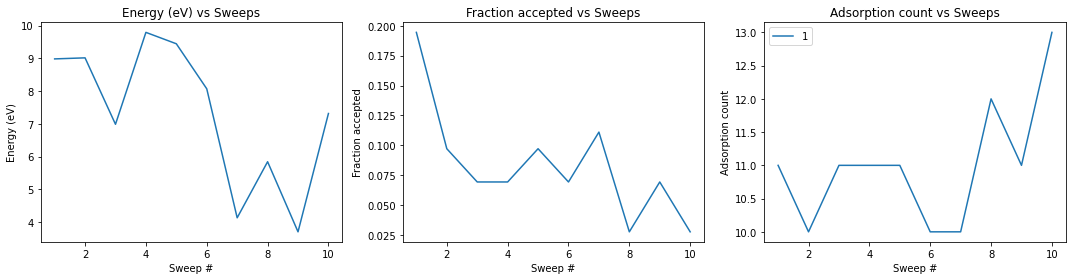

In [5]:
import copy

run_slab = copy.deepcopy(slab_batch)

mcmc = MCMC(
    calc=nff_calc,
    canonical=False,
    testing=False,
    surface_name=surface_name,
    element=element,
    adsorbates=adsorbates,
    ads_coords=ads_positions,
    relax=relax,
    offset=offset,
    offset_data=offset_data,
    relax_steps=relax_steps,
    optimizer=optimizer,
)

start = perf_counter()
# call the main function
mcmc.mcmc_run(
    total_sweeps=num_sweeps,
    sweep_size=sweep_size,
    start_temp=temp,
    pot=chem_pot, alpha=alpha, slab=run_slab
)

stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [6]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)